In my [previous notebook](https://www.kaggle.com/teddykoker/training-cellular-automata-part-i-game-of-life) we explored how we could use a CNN to create a cellular automata (CA) by recurrently passing the state of the grid through itself. Now we'll solve one of the tasks [arseny-n](https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning) solved with a hard coded CA by learning the CA instead!

In [1]:
import os
import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
data_path = Path('abstraction-and-reasoning-challenge')
train_path = data_path / 'training'
valid_path = data_path / 'evaluation'
test_path = data_path / 'test'

train_tasks = { task.stem: json.load(task.open()) for task in train_path.iterdir() } 
valid_tasks = { task.stem: json.load(task.open()) for task in valid_path.iterdir() } 

In [3]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    
def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])
        
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])


def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

def augment(tasks):
    # bottom up flipping
    tasks_1 = []
    for task in tasks:
        augmended_task = {}
        augmended_task['input'] = task['input'][::-1]
        augmended_task['output'] = task['output'][::-1]
        tasks_1.append(augmended_task)
        
    
    tasks_2 = []
    for task in tasks:
        augmended_task = {}
        augmended_task['input'] = task['input'][::-1]
        augmended_task['output'] = task['output'][::-1]
        for ii in range(len(augmended_task['output'])):
            augmended_task['output'][ii] = augmended_task['output'][ii][::-1]
        for ii in range(len(augmended_task['input'])):
            augmended_task['input'][ii] = augmended_task['input'][ii][::-1]
            
        tasks_2.append(augmended_task)
        
    tasks_3 = []
    for task in tasks:
        augmended_task = {}
        augmended_task['input'] = []
        augmended_task['output'] = []
        for ii in range(len(task['output'])):
            augmended_task['output'].append(task['output'][ii][::-1])
            augmended_task['input'].append(task['input'][ii][::-1])

        tasks_3.append(augmended_task)
    
    
    return tasks + tasks_1 + tasks_2 + tasks_3
    

In [4]:
tasks = train_tasks["00d62c1b"]["train"]
task = augment(tasks)
#[0,1,2,3,4,5]
#[0,1,2,3,4,5][::-1]

## First Task: db3e9e38

The task we'll first try is relitively straight foward; given a central orange "pillar", form stairs of alternating blue and orange in each direction. `arseny-n` showed that this could be solved with a CA consisting of three rules.

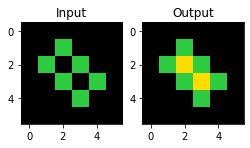

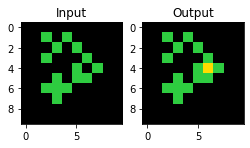

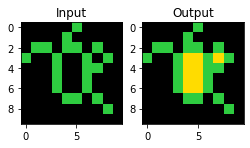

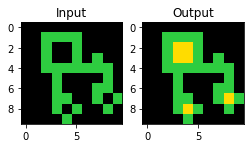

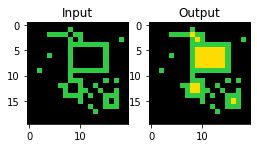

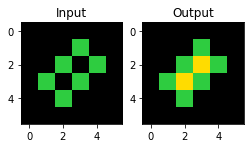

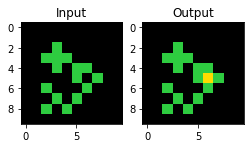

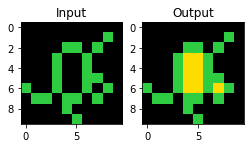

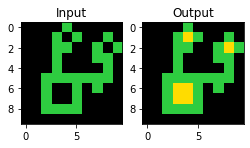

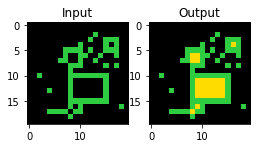

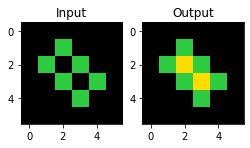

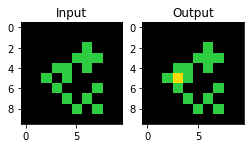

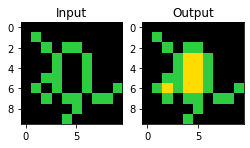

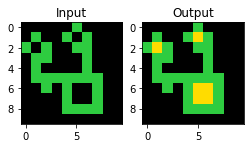

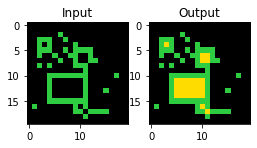

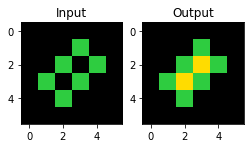

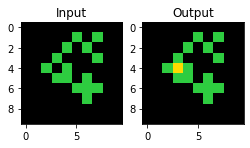

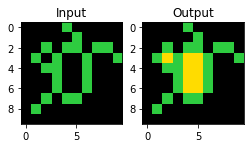

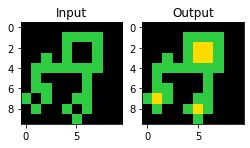

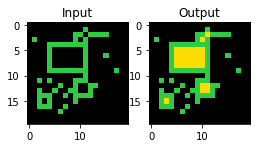

In [5]:
#task = train_tasks["00d62c1b"]["train"]
for sample in task:
    plot_sample(sample)

## The Model

The model consists of a single 3x3 convolutional layer, followed by a 1x1 convolutional layer, just like my last notebook. Here `num_states` represents how many values a single cell could have; in this case 10, one for each color. Down the road, we may want to add a hidden state, concatinating it to the input, then removing it from the output.

The foward pass of the model will repeatedly pass the grid state through the CA transition for `steps` number of times.

In [6]:
class CAModel(nn.Module):
    def __init__(self, num_states):
        super(CAModel, self).__init__()
        self.transition = nn.Sequential(
            nn.Conv2d(num_states, 128, kernel_size=5, padding=2),     
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Conv2d(128, num_states, kernel_size=1)
        )
        
    def forward(self, x, steps=1):
        for _ in range(steps):
            x = self.transition(torch.softmax(x, dim=1))
        return x
    
# class CAModel(nn.Module):
#     def __init__(self, num_states):
#         super(CAModel, self).__init__()
        
#         self.conv1 = nn.Conv2d(num_states, 128, kernel_size=5, padding=2)   
#         self.conv2 = nn.Conv2d(128, num_states, kernel_size=1)
        
#         #F.conv2d(input, weight, bias=None, stride=1, padding=2, dilation=1, 
                 
#     def forward(self, x, steps=1):
#         for _ in range(steps):

#             x = self.conv1(F.softmax(x, dim=1))
#             x = self.conv2(F.sigmoid(x))
#         return x
    

## Training

This "recurrent CNN" can be quite to difficult to train. After trying a few ideas, this seemed to be the best approach that I encountered:

* For every value $n$ = $1, ..., N$:
    1. Train the model with $n$ `steps` to produce the output from input
    2. Train the model with 1 `steps` to produce output from output
        * This enforces that the CA stabilizes after reaching a solution
        
In this way the model will try to get as close to a solution as possible in 1 step, then try to get closer in the next step, and so on until $N$ steps. For now I will use $N = 10$ = `max_steps`. I will also set the learning rate to decay with each additional step: $LR = 0.1 / (n * 2) $

In [7]:
def solve_task(task, max_steps=10):
    model = CAModel(10).to(device)
    model = model.train()
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    losses = np.zeros((max_steps - 1) * num_epochs)

    for num_steps in range(1, max_steps):
        optimizer = torch.optim.Adam(model.parameters(), lr=(0.1 / (num_steps * 2)))
        
        for e in range(num_epochs):
            optimizer.zero_grad()
            loss = 0.0

            for sample in task:
                # predict output from input
                x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
                y = torch.tensor(sample["output"]).long().unsqueeze(0).to(device)
                y_pred = model(x, num_steps)
                loss += criterion(y_pred, y)
                
                # predit output from output
                # enforces stability after solution is reached
                y_in = torch.from_numpy(inp2img(sample["output"])).unsqueeze(0).float().to(device)
                y_pred = model(y_in, 1) 
                loss += criterion(y_pred, y)
#                 lamb = torch.tensor(0.02).float().to(device)
#                 l2_reg = torch.tensor(0.).float().to(device)
#                 for param in model.parameters():
#                     l2_reg += torch.norm(param)
#                 loss += lamb * l2_reg

            loss.backward()
            optimizer.step()
            losses[(num_steps - 1) * num_epochs + e] = loss.item()
    return model, num_steps, losses
                

In [8]:
@torch.no_grad()
def predict(model, task):
    predictions = []
    for sample in task:
        x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
        pred = model(x, 100).argmax(1).squeeze().cpu().numpy()
        predictions.append(pred)
    return predictions
    

In [9]:
#task = train_tasks["00d62c1b"]["train"]
model, num_steps, losses = solve_task(task)

$n$ is incremented every 100 epochs, so we can see that it reaches a good solution after 3 steps (epoch 300).

Now lets see if it at least correctly outputs the training set. To be save we'll give the model $n=100$ steps:

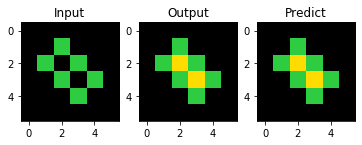

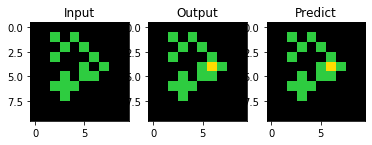

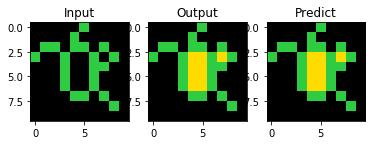

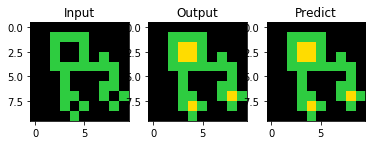

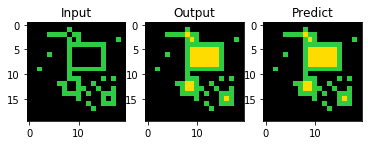

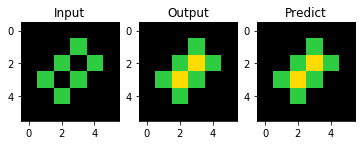

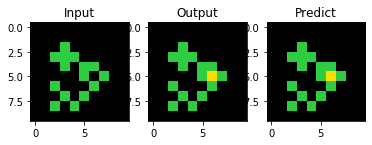

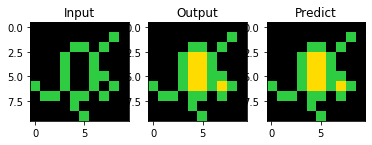

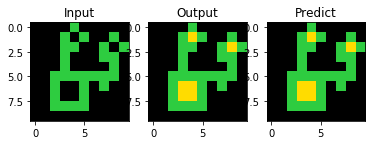

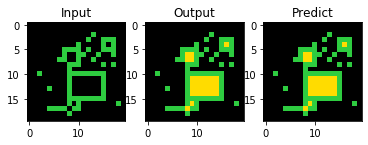

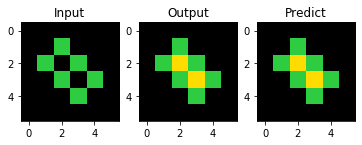

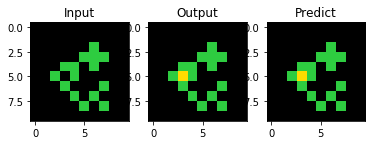

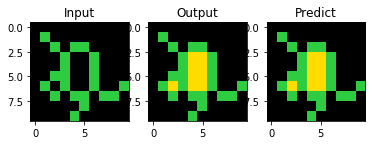

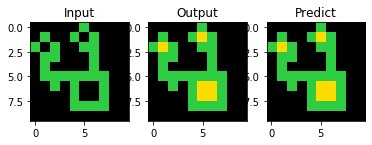

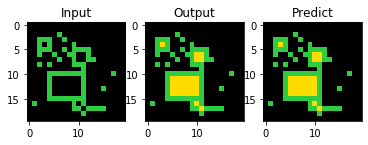

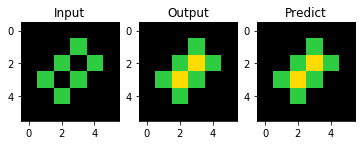

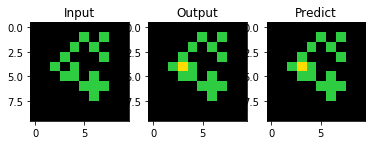

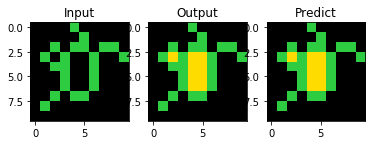

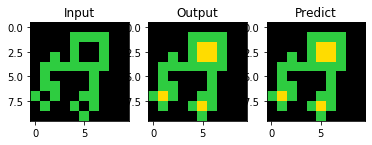

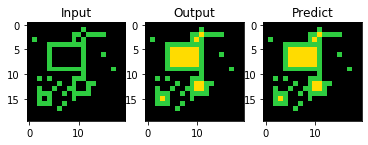

In [28]:
predictions = predict(model.eval(), task)
for i in range(len(task)):
    plot_sample(task[i], predictions[i])

It works! Now lets see if it generalized to the test question:

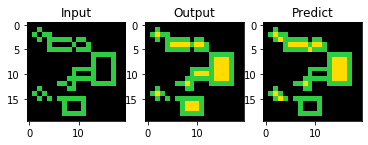

In [29]:
test = train_tasks["00d62c1b"]["test"]
predictions = predict(model.eval(), test)
for i in range(len(test)):
    plot_sample(test[i], predictions[i])

Fantastic! The coolest part now is that we can animate our solution to see the CA in action:

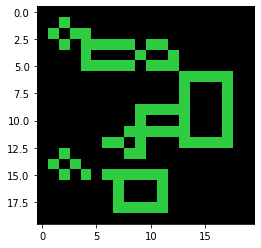

In [16]:
def animate_solution(model, sample):
    x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)

    @torch.no_grad()
    def animate(i):
        pred = model(x, i)
        im.set_data(pred.argmax(1).squeeze().cpu().numpy())

    fig, ax = plt.subplots()
    im = ax.imshow(x.argmax(1).squeeze().cpu().numpy(), cmap=cmap, norm=norm)
    return animation.FuncAnimation(fig, animate, frames=100, interval=120)
    
anim = animate_solution(model.eval(), train_tasks["00d62c1b"]["test"][0])
HTML(anim.to_jshtml())

We can see that the CA quickly gets to a solution and then stabilizes.

## More Tasks

Now that we know we can train a CA for one task, will it work on others?

In [30]:
def evaluate(tasks):
    result = []
    predictions = []
    for idx, task in tqdm(tasks.items()):
        if input_output_shape_is_same(task):
            model, _, _ = solve_task(task["train"])
            pred = predict(model, task["test"])
            score = calk_score(task["test"], pred)
        else:
            pred = [el["input"] for el in task["test"]]
            score = [0] * len(task["test"])

        predictions.append(pred)
        result.append(score)
    return result, predictions

In [31]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

 13%|█▎        | 52/400 [17:30<2:32:58, 26.37s/it]

KeyboardInterrupt: 

We solve many of the tasks within the training set using our Neural Cellular Automata model! I did test on the validation set as well, and it correctly solved 17 of the tasks. There are a number of ways this model could be improved. Please let me know if you'd be interested in collaboration!

## Solved Tasks

0it [00:00, ?it/s]

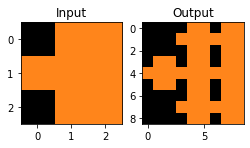

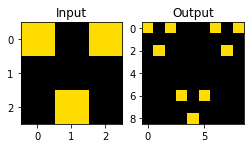

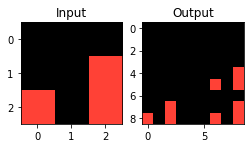

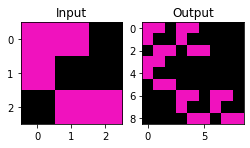

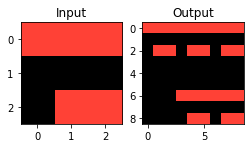

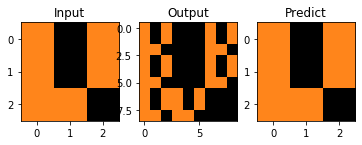

1it [00:01,  1.89s/it]

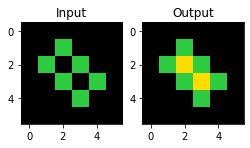

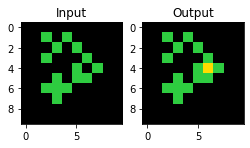

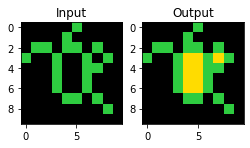

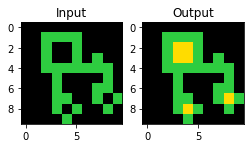

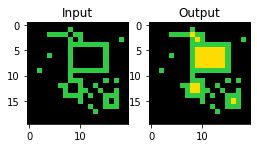

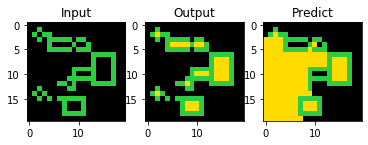

2it [00:03,  1.91s/it]

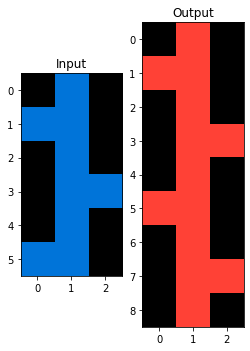

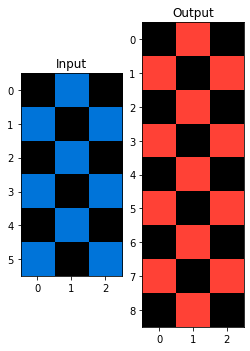

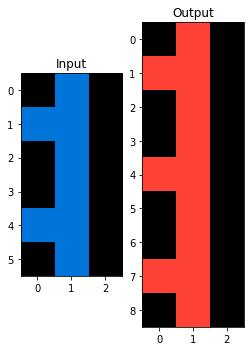

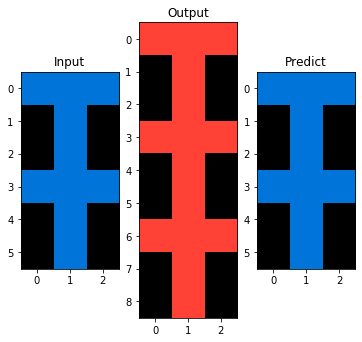

3it [00:05,  1.76s/it]

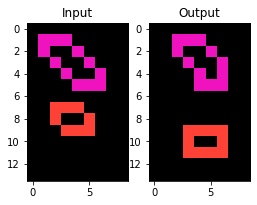

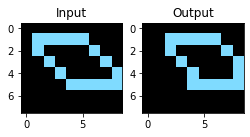

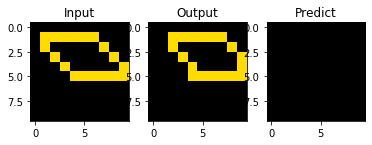

4it [00:06,  1.57s/it]

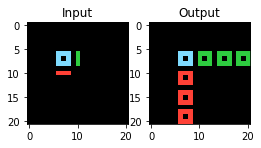

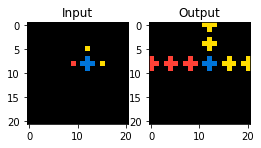

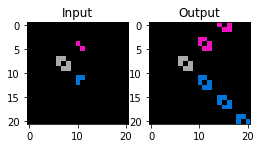

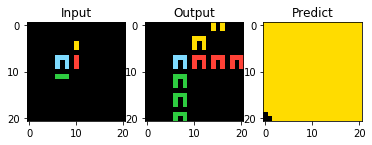

5it [00:07,  1.50s/it]

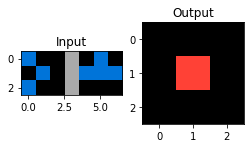

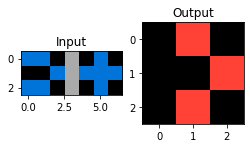

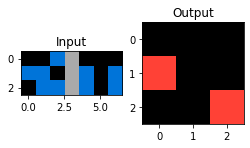

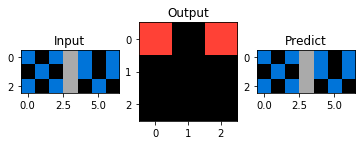

6it [00:08,  1.43s/it]

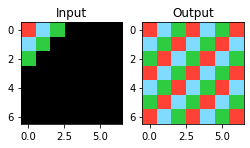

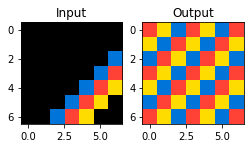

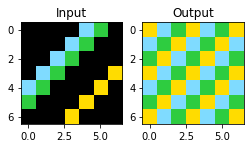

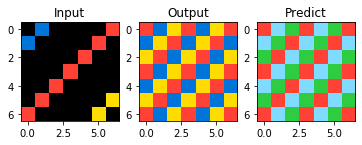

7it [00:10,  1.43s/it]

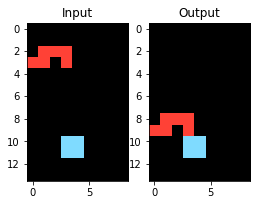

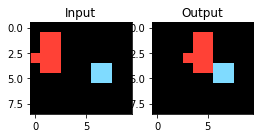

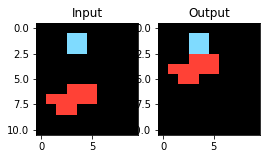

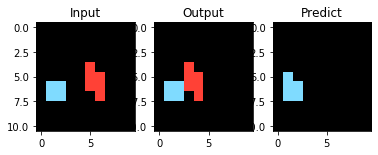

8it [00:11,  1.39s/it]

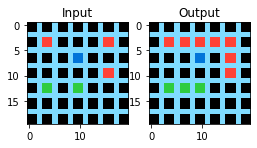

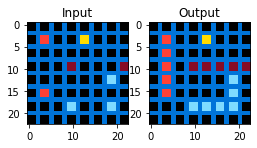

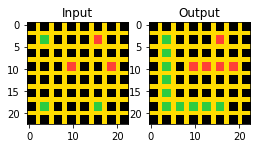

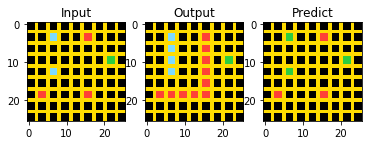

9it [00:13,  1.36s/it]

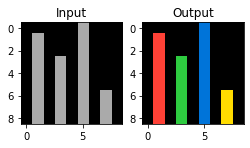

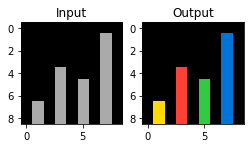

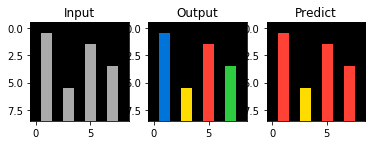

10it [00:14,  1.29s/it]

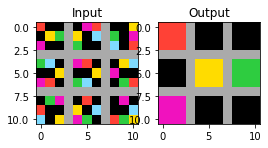

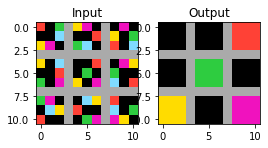

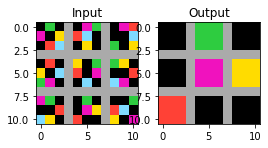

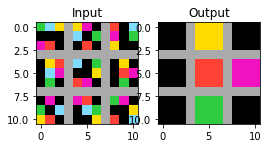

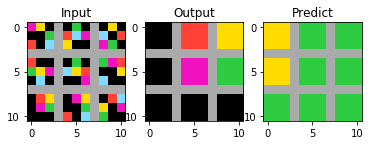

11it [00:15,  1.39s/it]

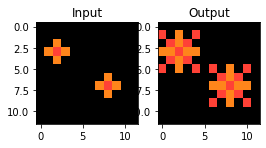

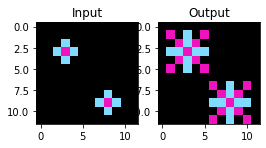

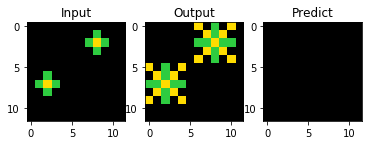

12it [00:16,  1.31s/it]

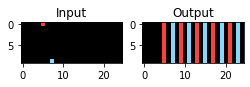

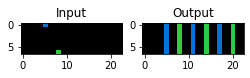

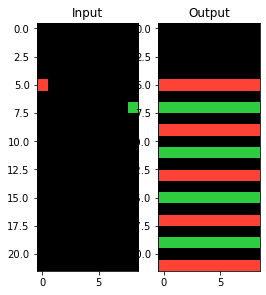

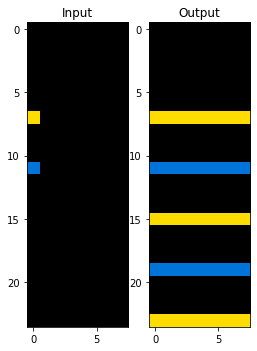

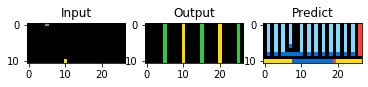

13it [00:18,  1.39s/it]

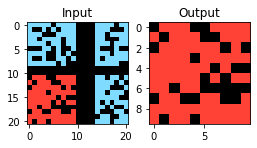

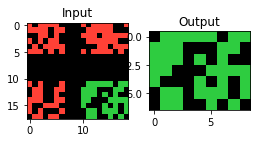

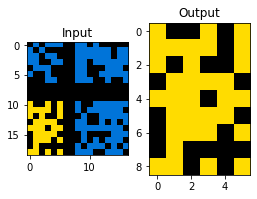

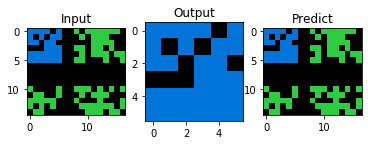

14it [00:19,  1.37s/it]

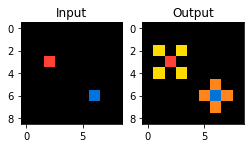

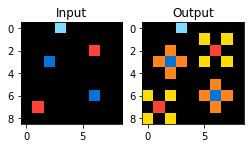

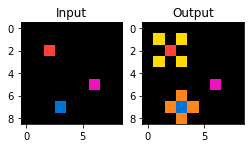

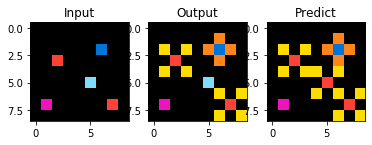

15it [00:21,  1.38s/it]

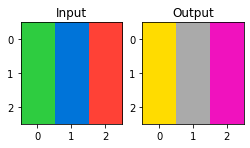

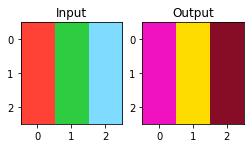

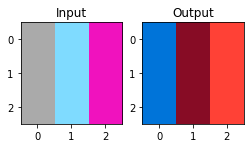

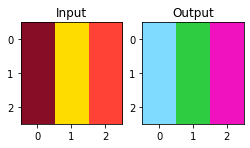

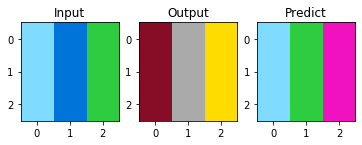

16it [00:22,  1.44s/it]

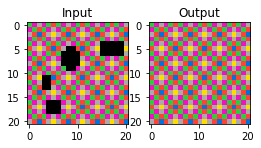

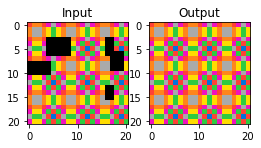

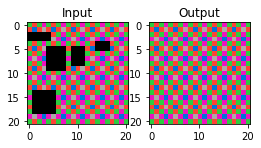

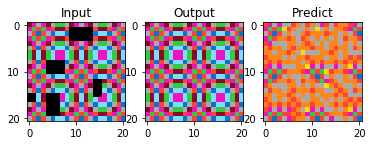

17it [00:24,  1.44s/it]

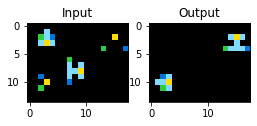

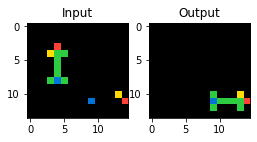

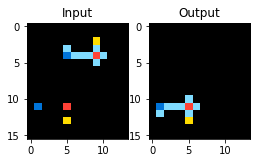

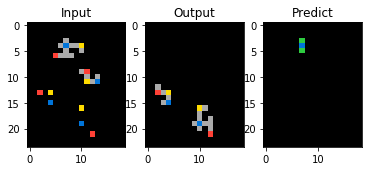

18it [00:25,  1.39s/it]

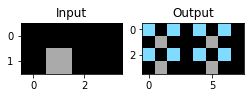

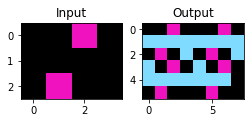

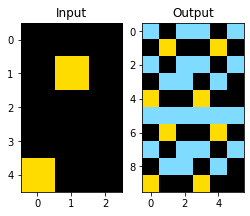

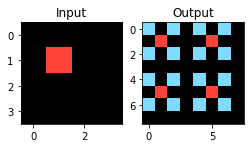

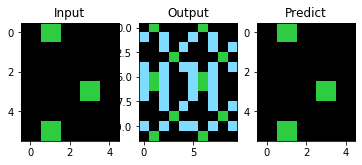

19it [00:27,  1.45s/it]

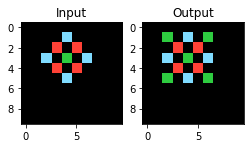

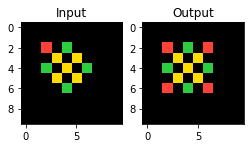

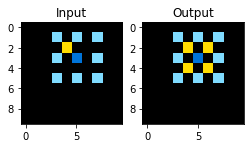

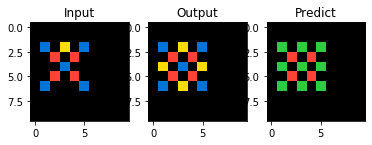

20it [00:28,  1.43s/it]

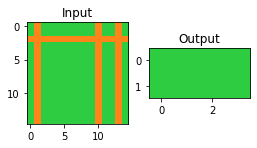

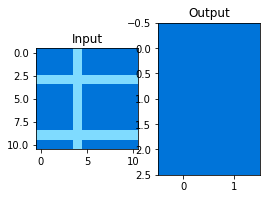

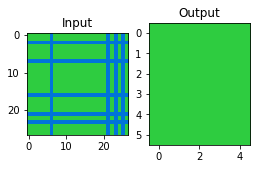

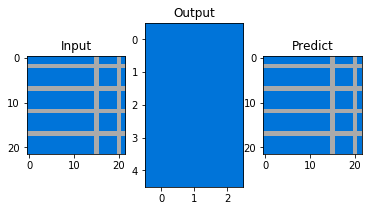

21it [00:29,  1.41s/it]

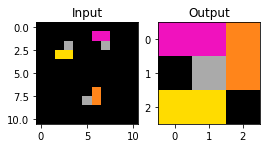

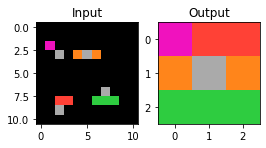

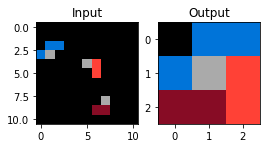

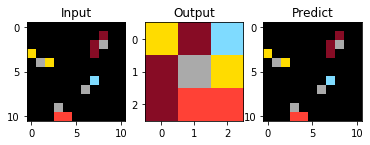

22it [00:31,  1.42s/it]

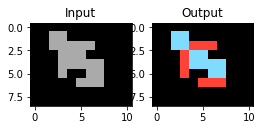

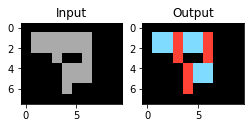

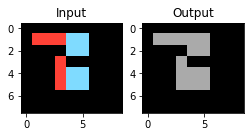

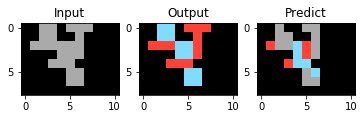

23it [00:32,  1.38s/it]

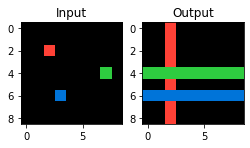

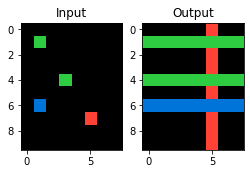

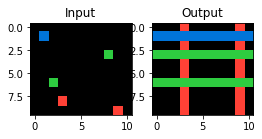

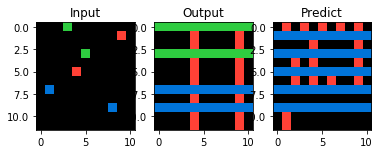

24it [00:33,  1.36s/it]

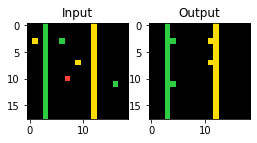

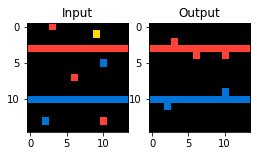

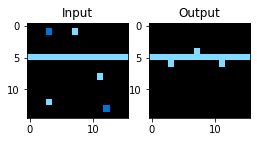

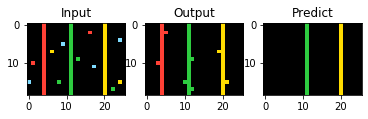

25it [00:35,  1.38s/it]

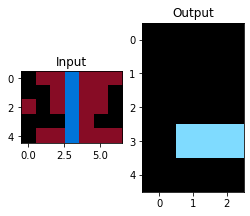

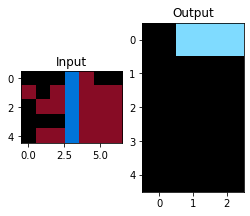

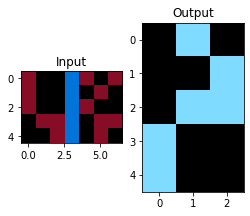

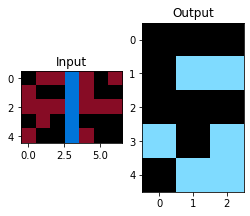

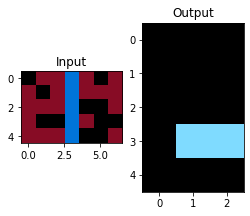

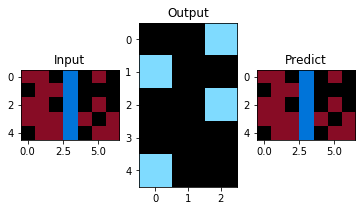

26it [00:37,  1.54s/it]

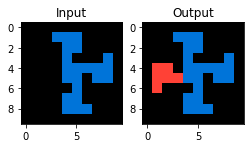

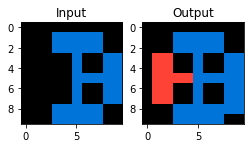

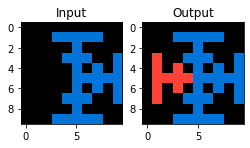

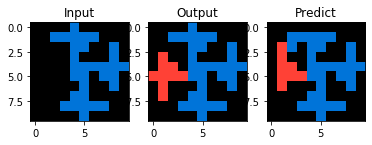

27it [00:38,  1.49s/it]

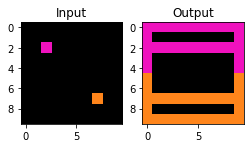

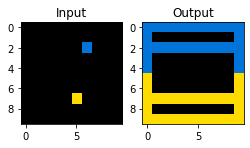

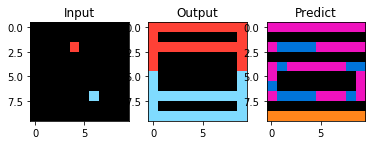

28it [00:39,  1.34s/it]

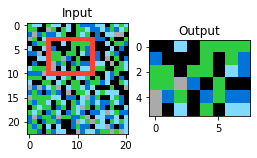

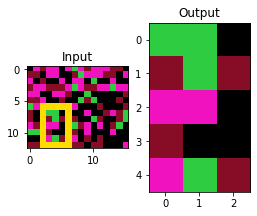

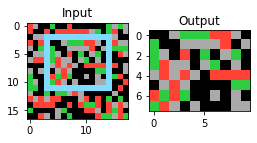

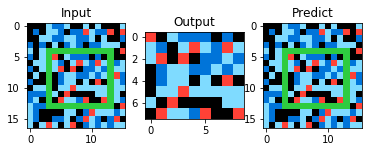

29it [00:40,  1.33s/it]

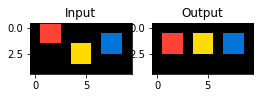

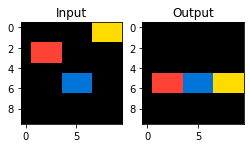

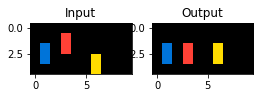

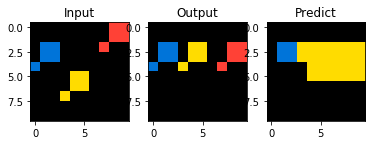

30it [00:42,  1.34s/it]

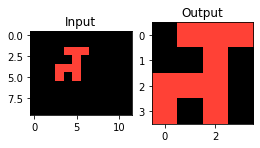

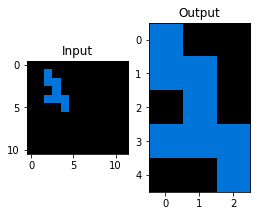

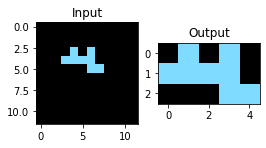

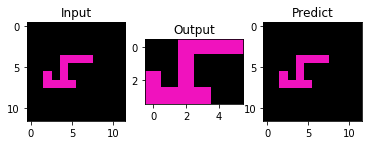

31it [00:43,  1.33s/it]

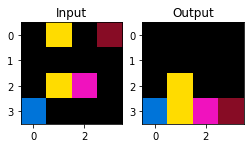

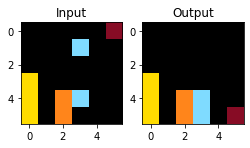

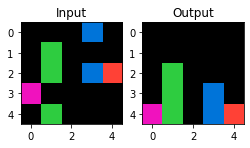

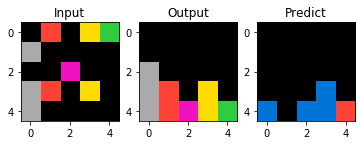

32it [00:44,  1.32s/it]

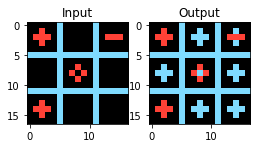

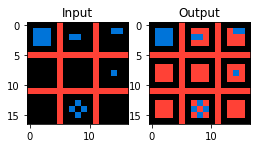

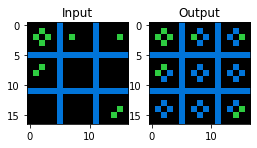

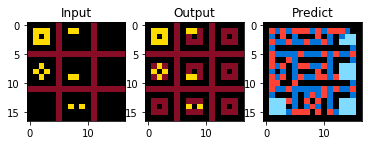

33it [00:46,  1.34s/it]

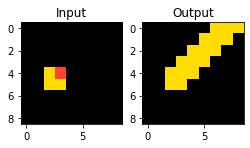

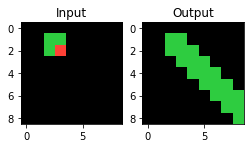

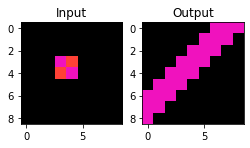

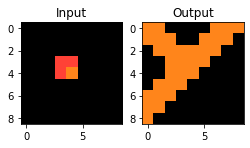

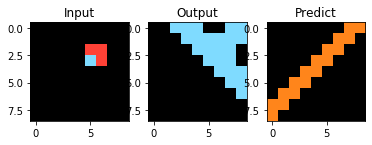

34it [00:47,  1.41s/it]

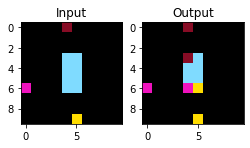

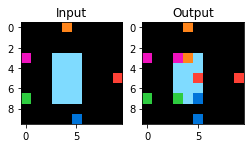

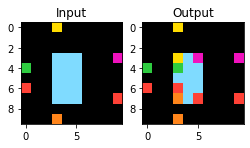

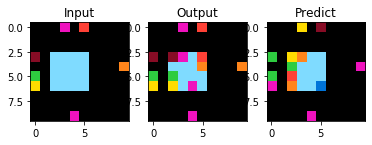

35it [00:49,  1.40s/it]

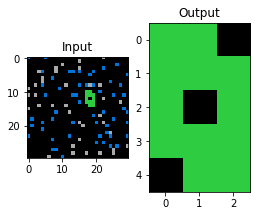

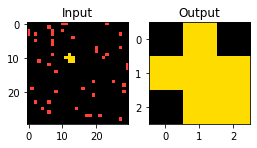

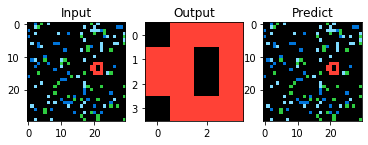

36it [00:50,  1.28s/it]

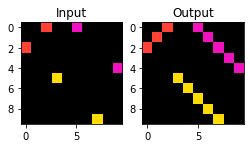

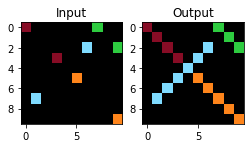

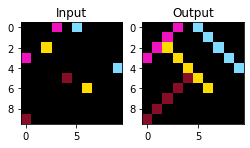

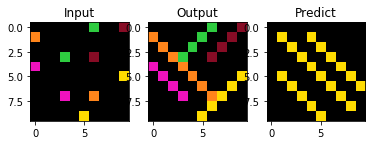

37it [00:51,  1.28s/it]

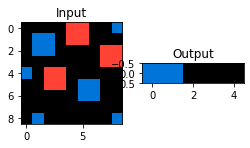

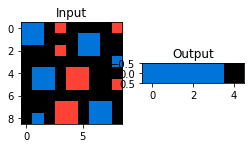

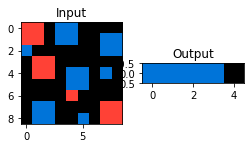

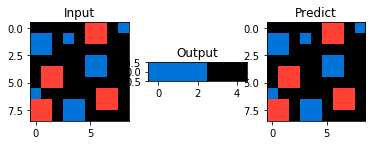

38it [00:52,  1.31s/it]

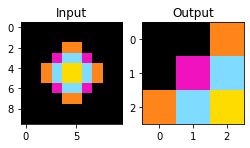

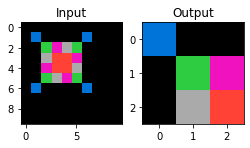

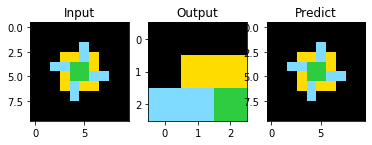

39it [00:53,  1.22s/it]

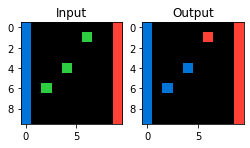

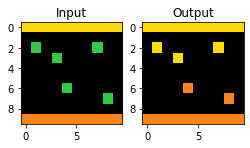

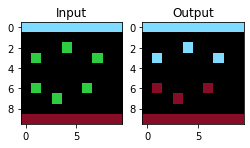

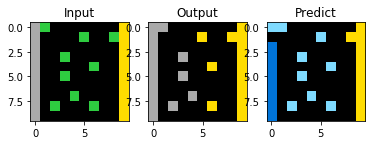

40it [00:55,  1.24s/it]

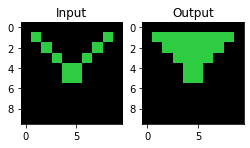

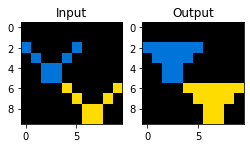

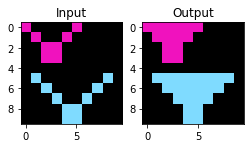

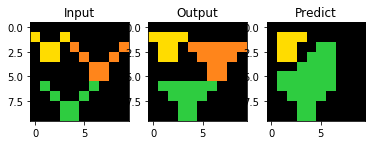

41it [00:56,  1.28s/it]

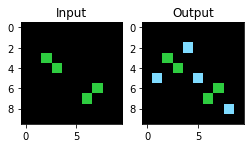

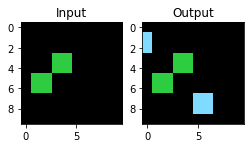

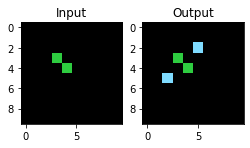

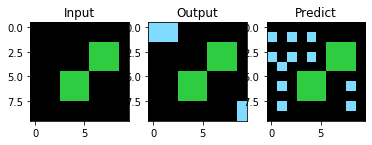

42it [00:57,  1.28s/it]

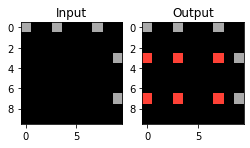

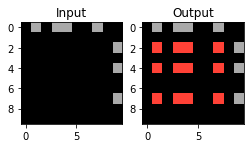

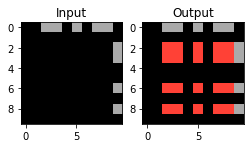

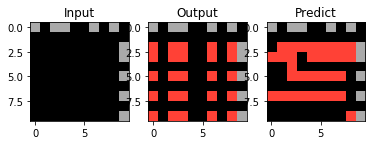

43it [00:59,  1.28s/it]

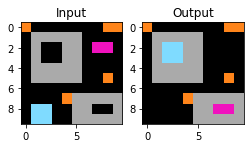

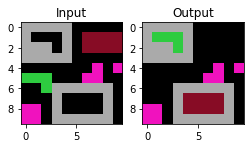

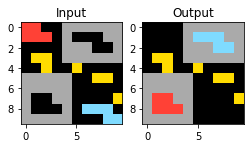

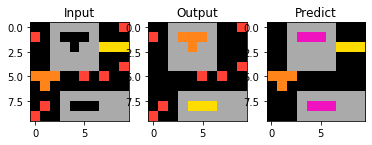

44it [01:00,  1.32s/it]

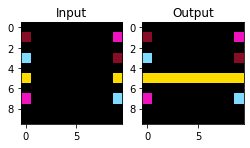

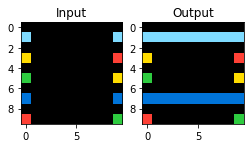

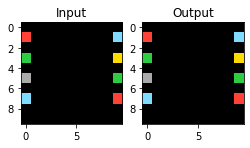

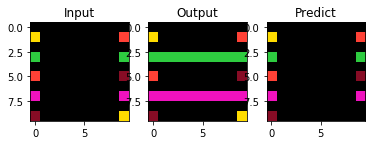

45it [01:01,  1.31s/it]

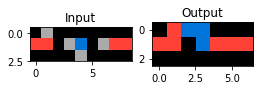

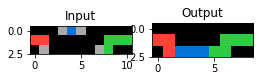

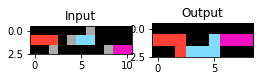

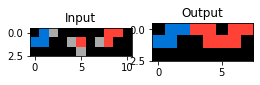

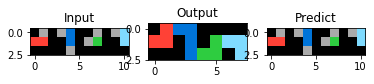

46it [01:03,  1.37s/it]

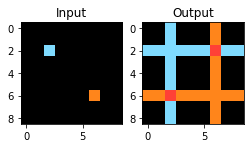

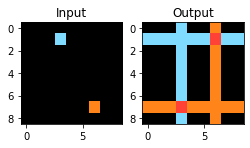

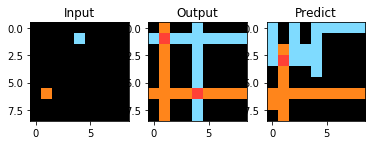

47it [01:04,  1.30s/it]

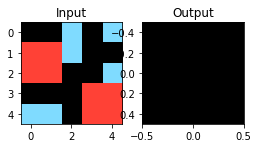

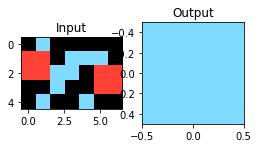

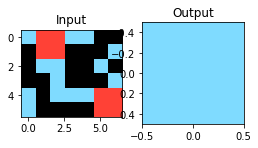

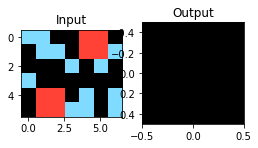

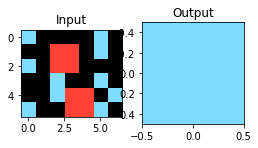

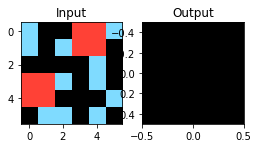

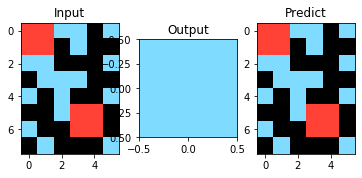

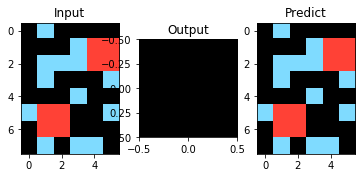

48it [01:07,  1.70s/it]

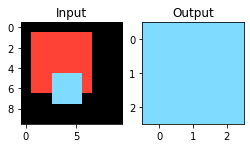

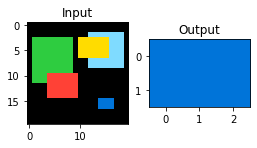

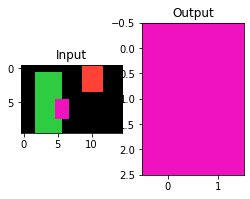

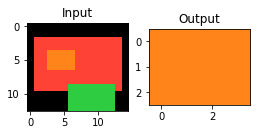

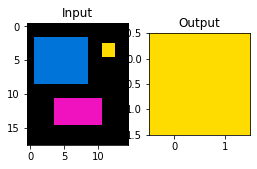

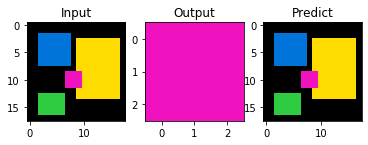

49it [01:08,  1.77s/it]

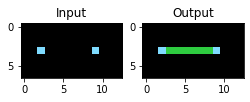

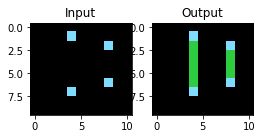

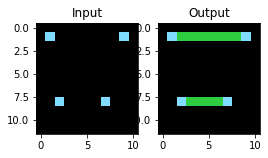

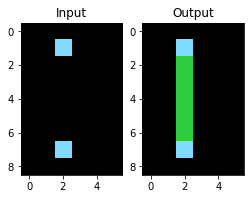

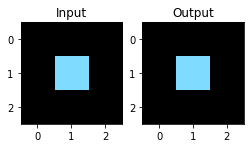

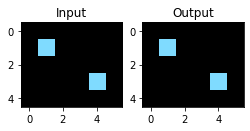

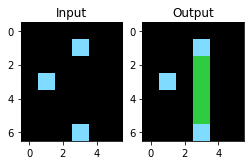

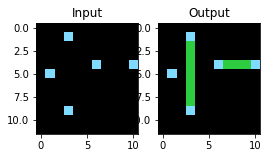

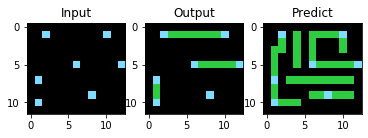

50it [01:11,  2.08s/it]

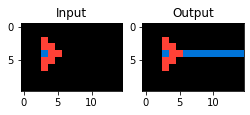

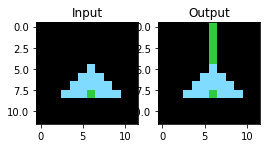

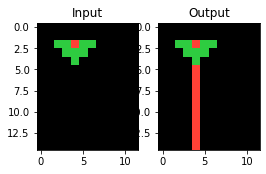

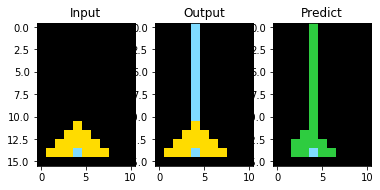

51it [01:13,  1.86s/it]

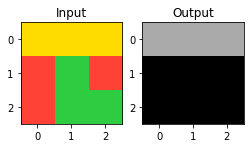

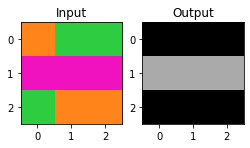

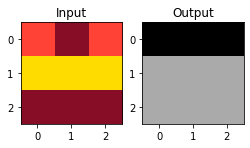

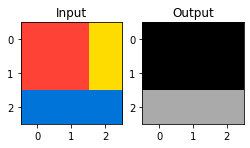

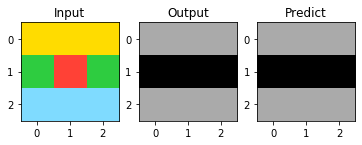

52it [01:14,  1.79s/it]

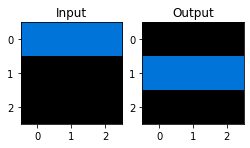

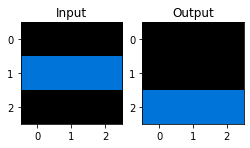

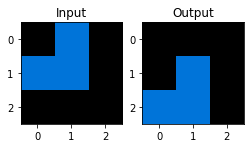

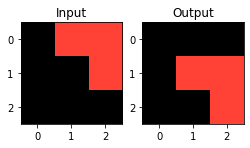

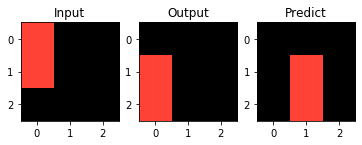

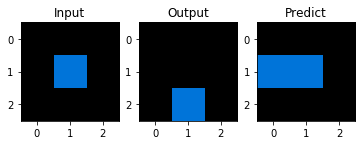

53it [01:16,  1.87s/it]

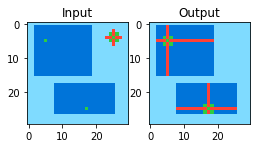

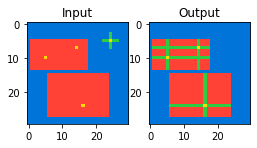

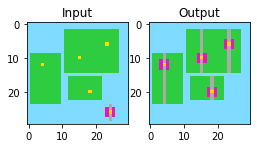

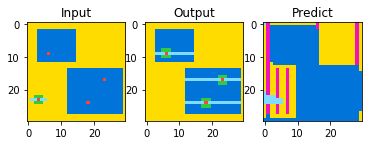

54it [01:18,  1.74s/it]

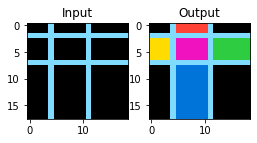

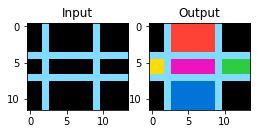

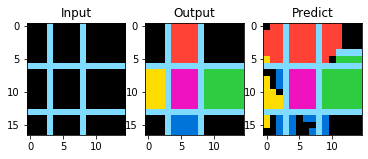

55it [01:19,  1.52s/it]

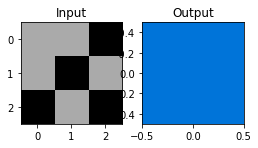

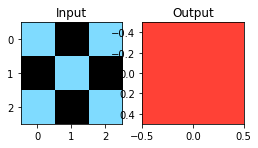

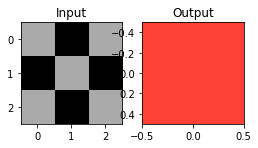

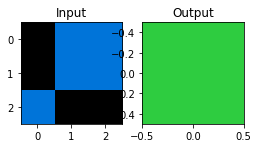

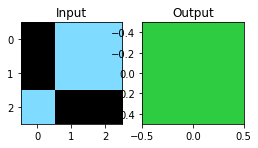

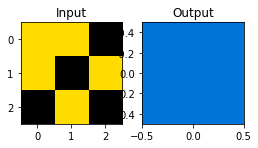

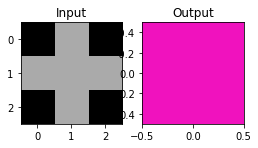

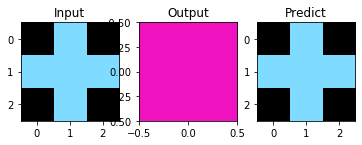

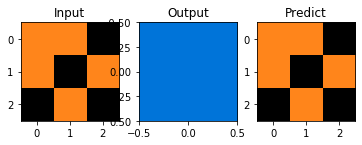

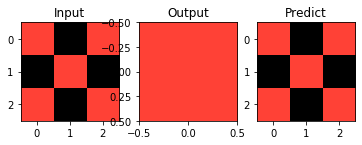

56it [01:22,  2.10s/it]

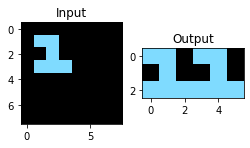

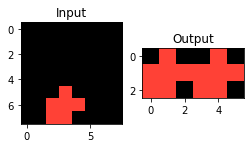

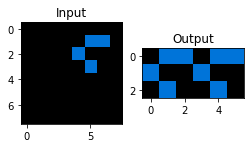

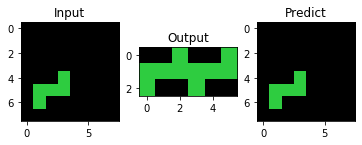

57it [01:23,  1.86s/it]

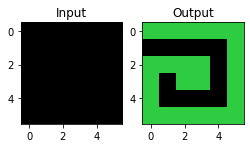

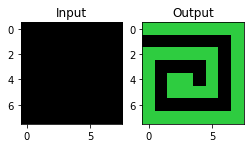

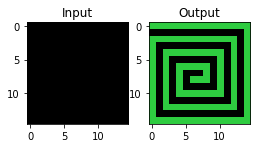

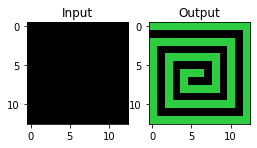

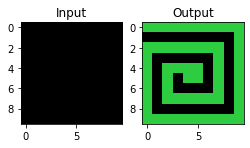

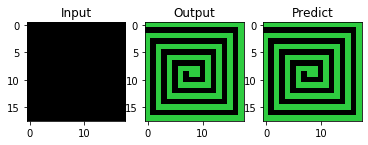

58it [01:25,  1.90s/it]

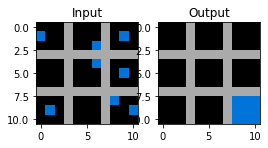

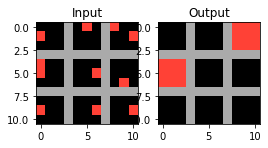

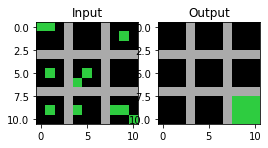

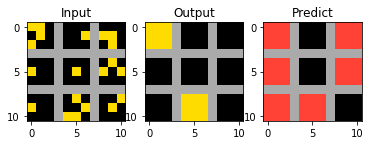

59it [01:27,  1.72s/it]

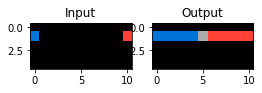

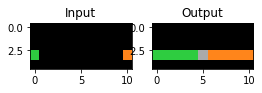

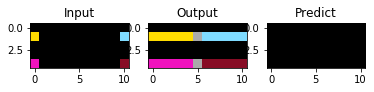

60it [01:28,  1.50s/it]

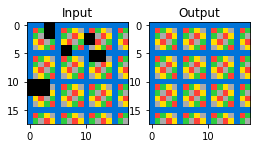

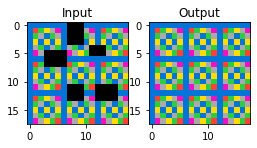

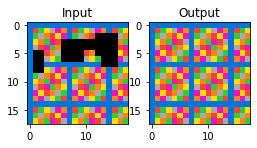

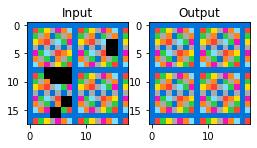

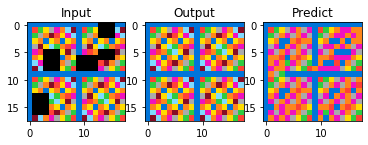

61it [01:29,  1.56s/it]

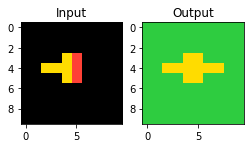

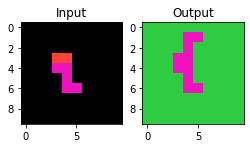

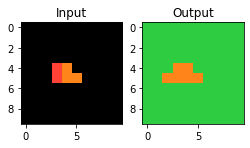

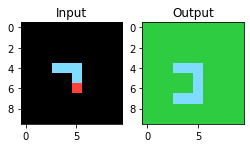

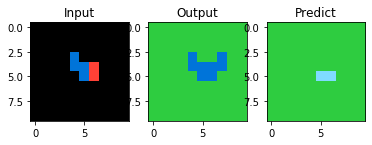

62it [01:31,  1.56s/it]

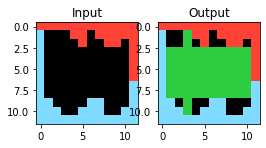

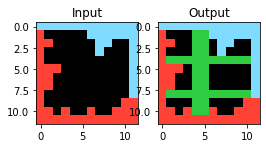

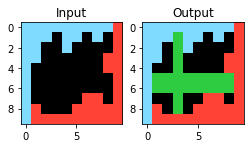

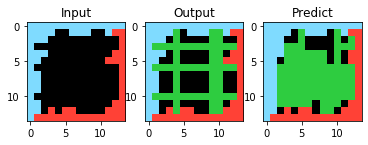

63it [01:32,  1.52s/it]

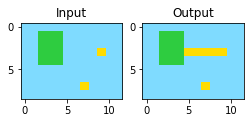

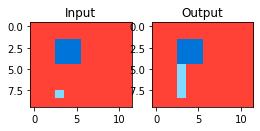

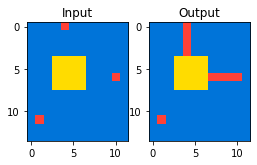

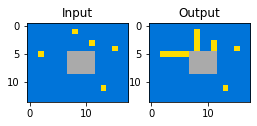

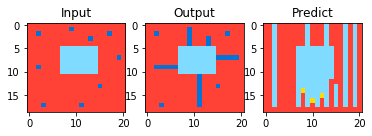

64it [01:34,  1.53s/it]

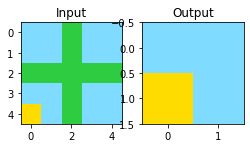

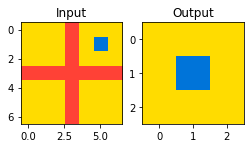

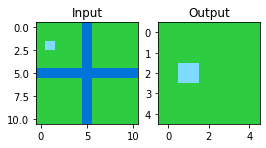

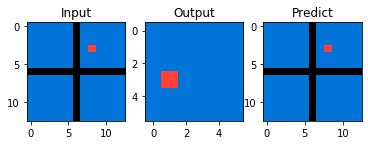

65it [01:35,  1.50s/it]

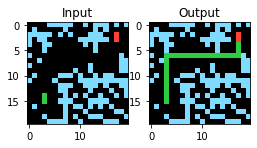

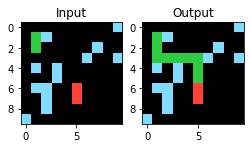

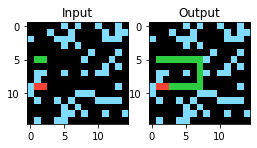

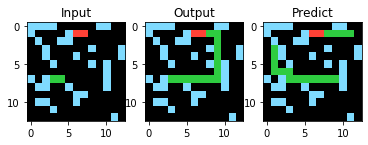

66it [01:37,  1.44s/it]

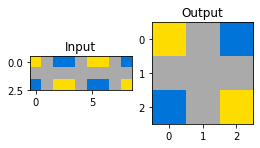

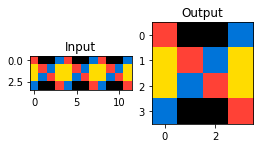

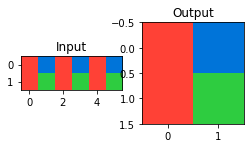

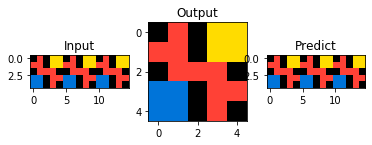

67it [01:38,  1.39s/it]

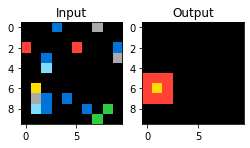

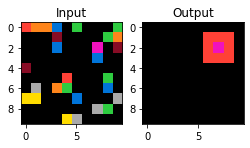

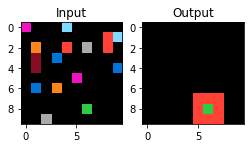

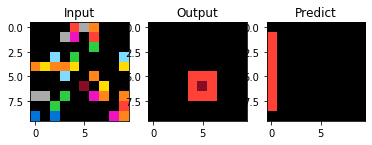

68it [01:39,  1.41s/it]

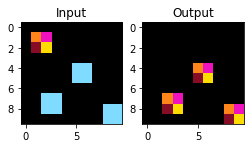

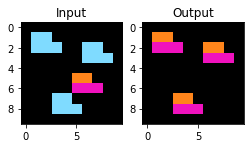

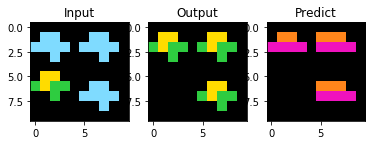

69it [01:40,  1.28s/it]

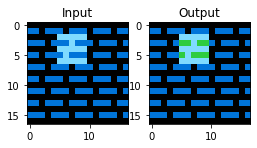

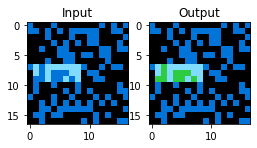

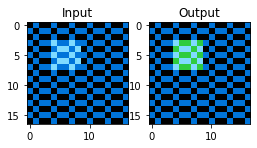

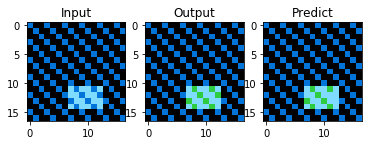

70it [01:42,  1.29s/it]

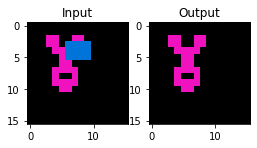

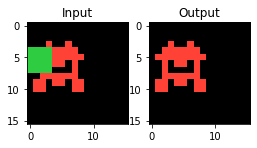

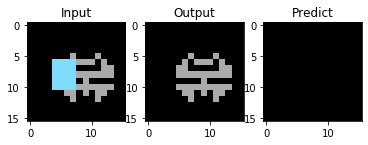

71it [01:43,  1.23s/it]

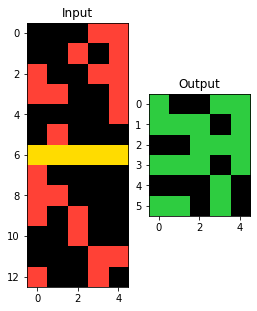

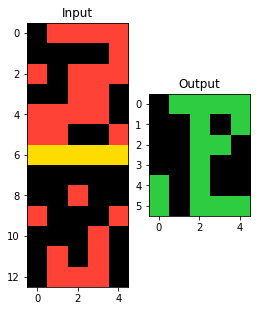

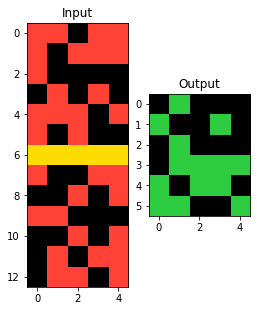

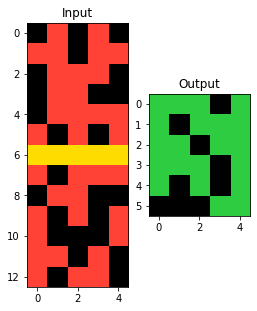

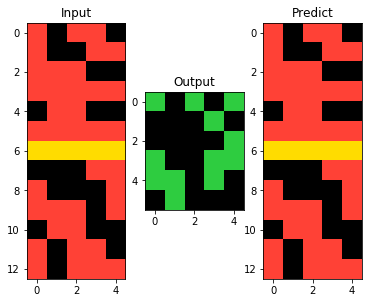

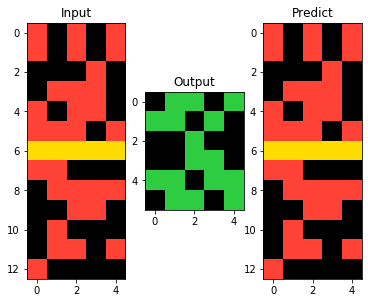

72it [01:45,  1.50s/it]

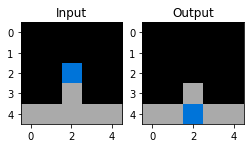

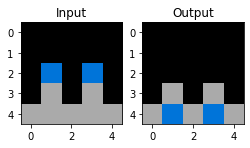

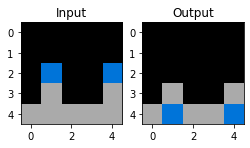

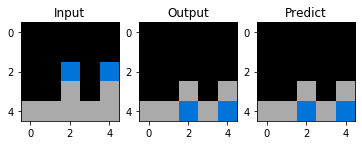

73it [01:46,  1.47s/it]

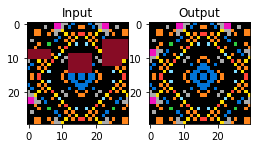

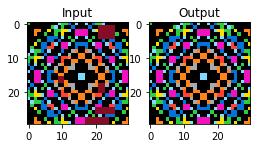

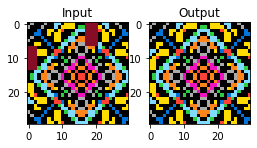

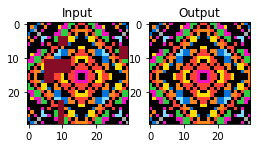

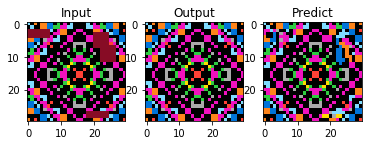

74it [01:48,  1.50s/it]

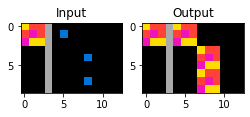

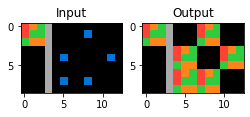

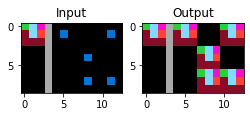

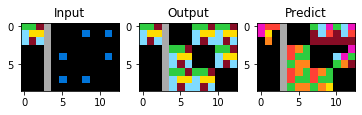

75it [01:49,  1.47s/it]

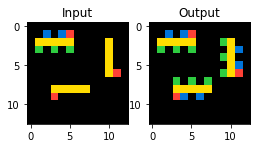

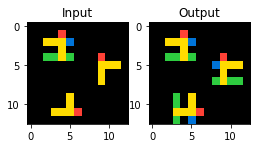

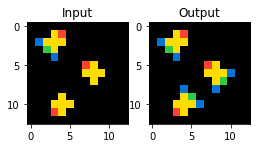

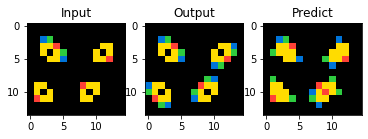

76it [01:51,  1.41s/it]

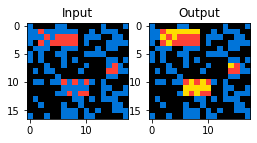

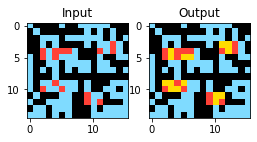

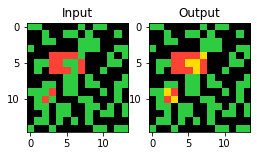

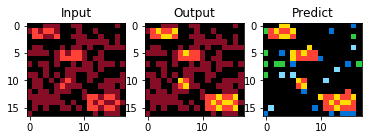

77it [01:52,  1.37s/it]

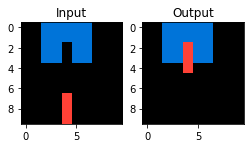

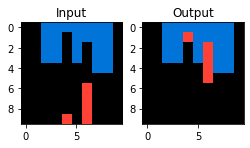

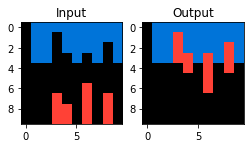

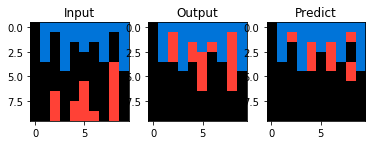

78it [01:53,  1.37s/it]

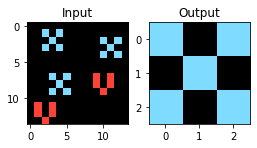

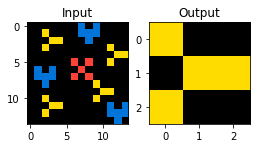

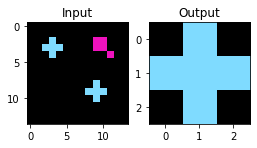

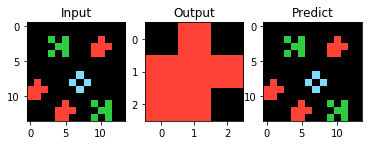

79it [01:55,  1.35s/it]

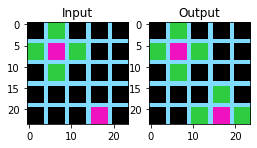

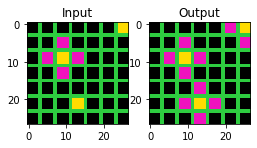

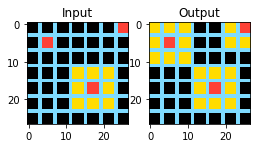

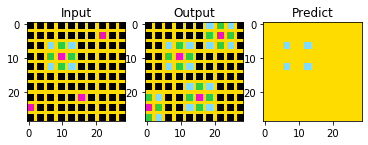

80it [01:56,  1.33s/it]

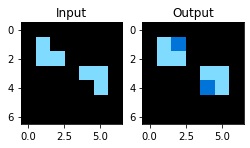

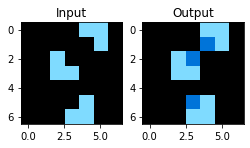

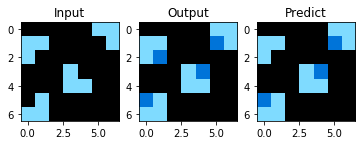

81it [01:57,  1.26s/it]

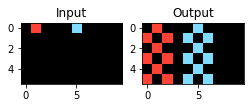

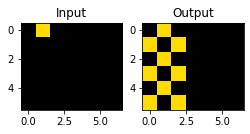

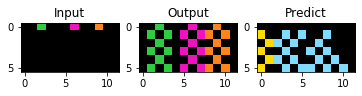

82it [01:58,  1.18s/it]

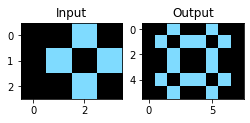

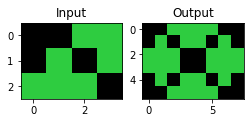

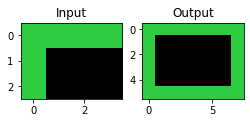

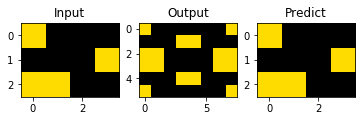

83it [01:59,  1.20s/it]

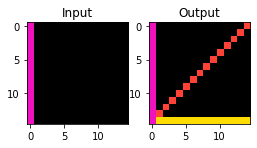

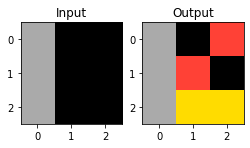

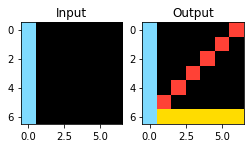

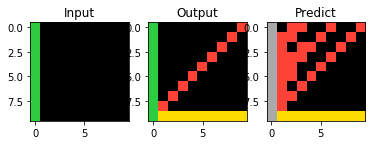

84it [02:01,  1.25s/it]

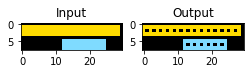

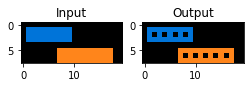

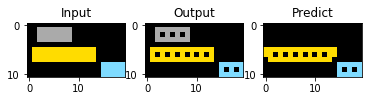

85it [02:02,  1.17s/it]

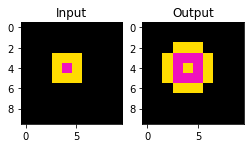

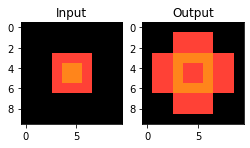

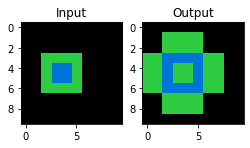

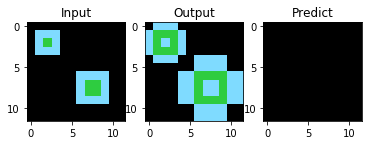

86it [02:03,  1.21s/it]

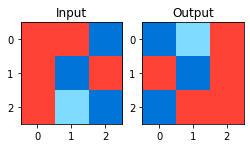

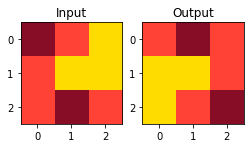

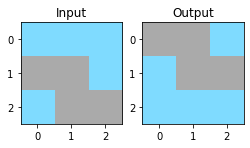

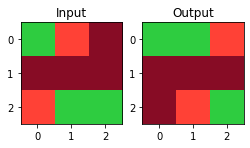

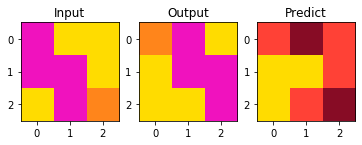

87it [02:04,  1.34s/it]

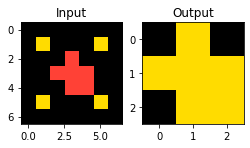

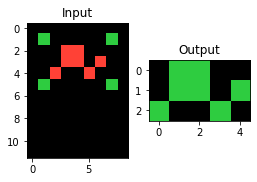

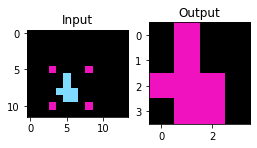

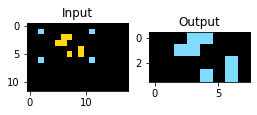

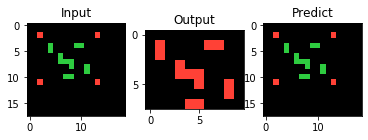

88it [02:06,  1.41s/it]

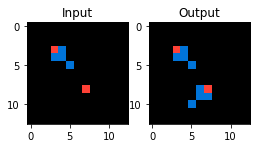

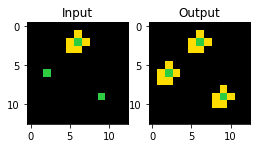

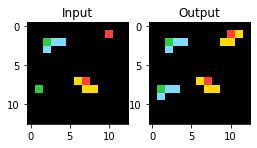

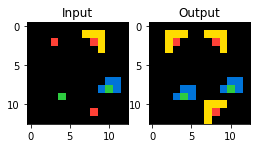

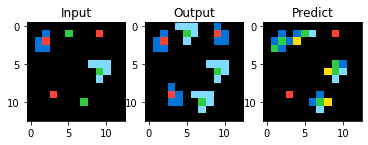

89it [02:08,  1.48s/it]

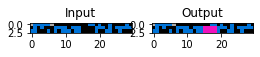

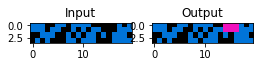

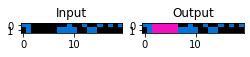

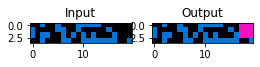

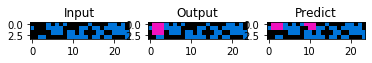

90it [02:09,  1.49s/it]

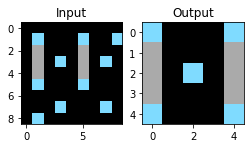

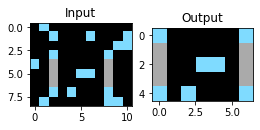

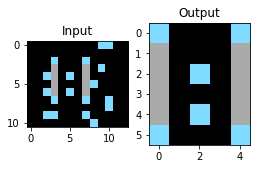

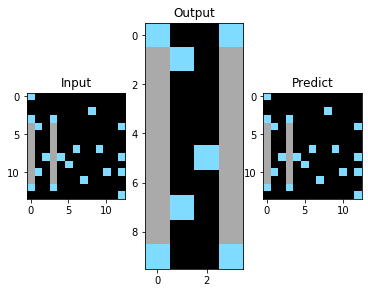

91it [02:11,  1.46s/it]

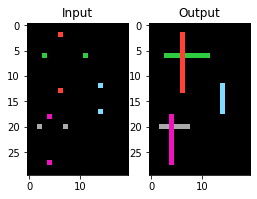

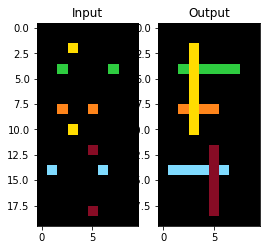

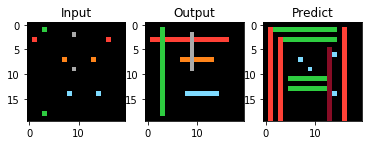

92it [02:12,  1.33s/it]

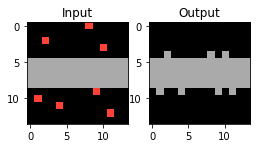

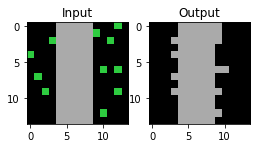

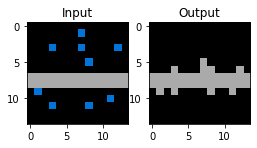

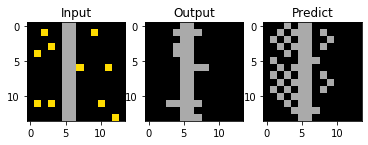

93it [02:13,  1.32s/it]

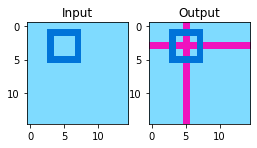

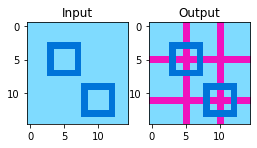

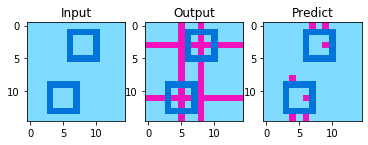

94it [02:14,  1.25s/it]

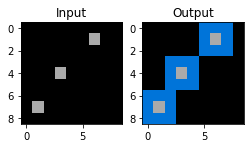

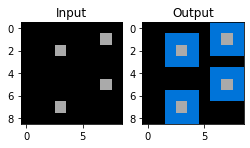

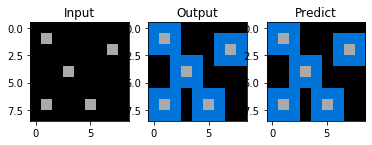

95it [02:15,  1.18s/it]

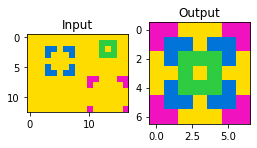

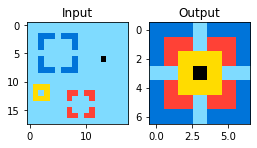

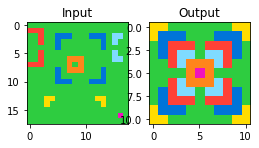

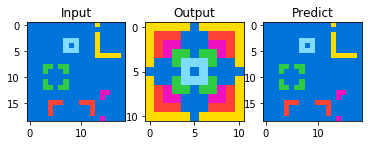

96it [02:16,  1.22s/it]

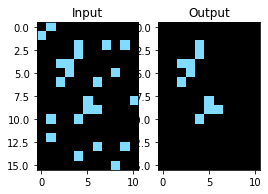

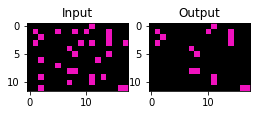

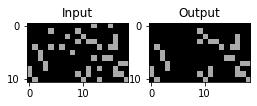

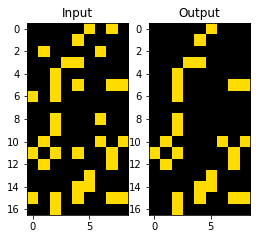

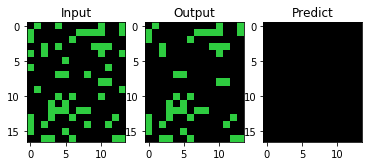

97it [02:18,  1.36s/it]

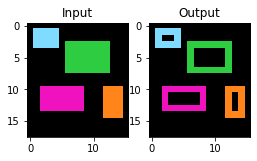

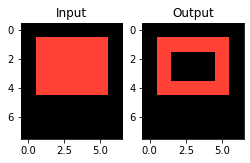

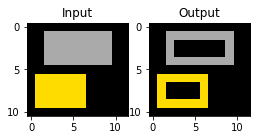

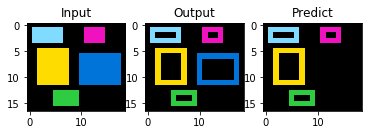

98it [02:19,  1.34s/it]

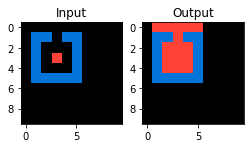

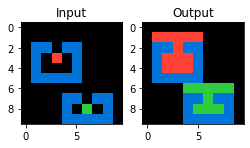

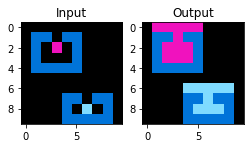

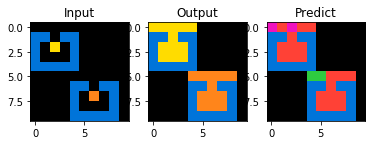

99it [02:21,  1.35s/it]

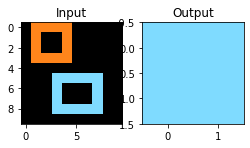

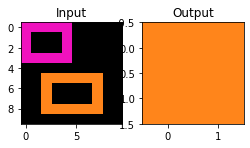

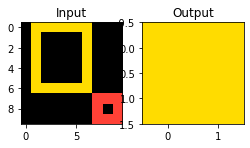

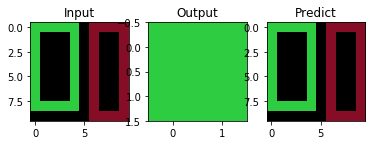

100it [02:22,  1.33s/it]

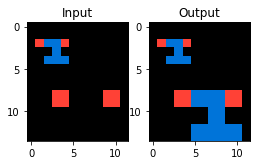

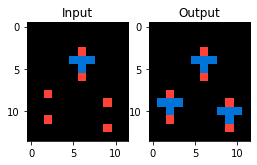

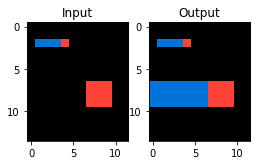

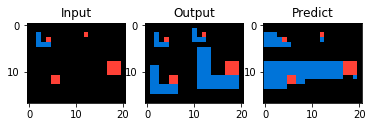

101it [02:23,  1.32s/it]

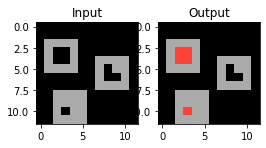

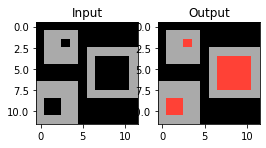

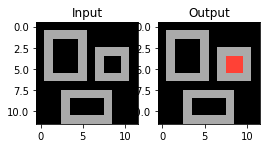

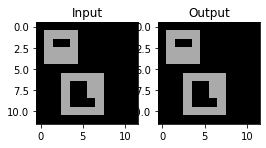

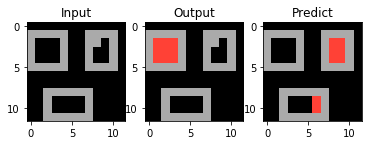

102it [02:25,  1.43s/it]

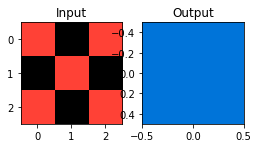

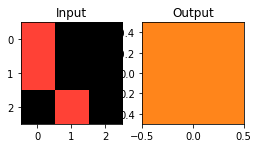

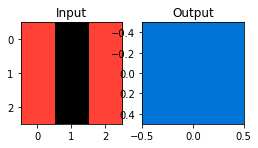

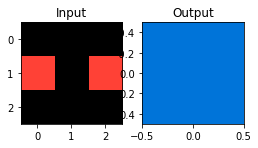

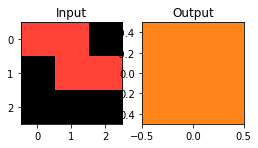

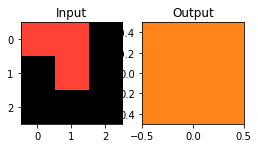

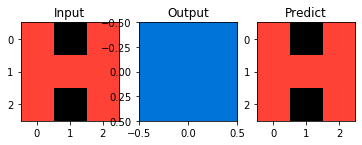

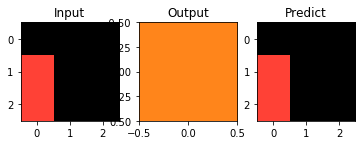

103it [02:28,  1.78s/it]

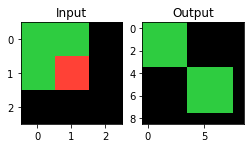

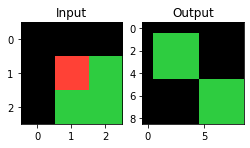

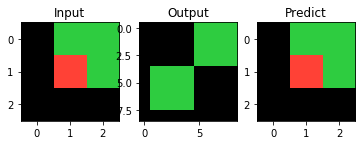

104it [02:29,  1.58s/it]

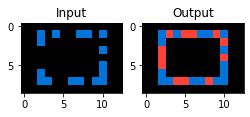

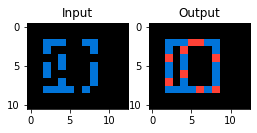

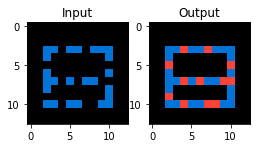

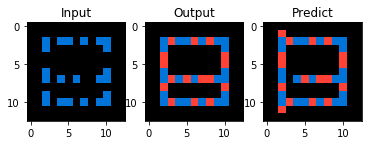

105it [02:30,  1.49s/it]

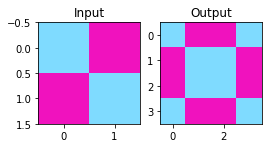

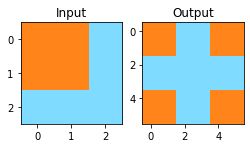

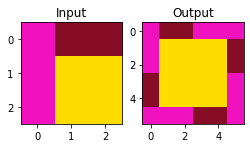

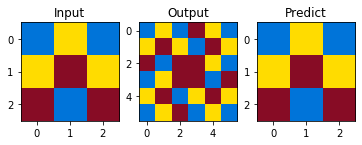

106it [02:31,  1.45s/it]

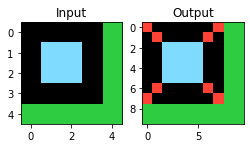

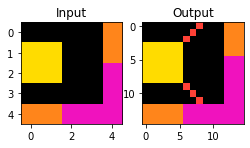

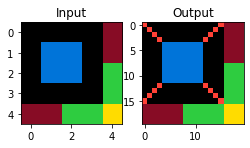

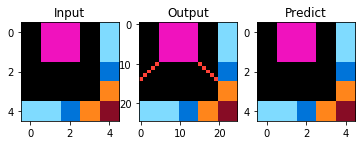

107it [02:33,  1.40s/it]

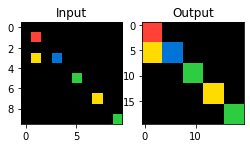

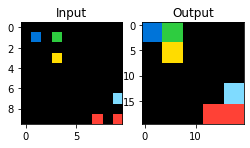

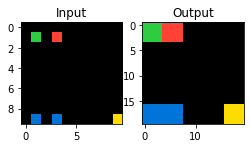

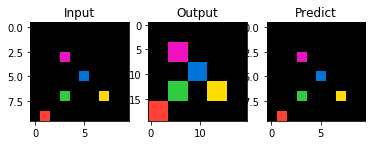

108it [02:34,  1.37s/it]

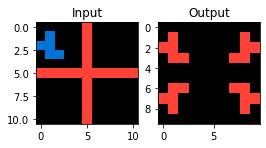

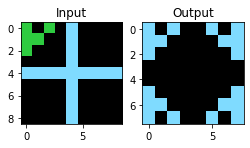

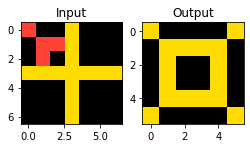

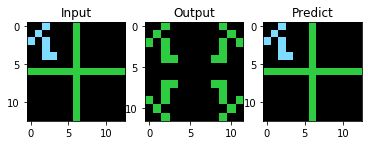

109it [02:35,  1.37s/it]

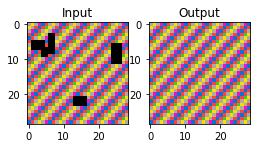

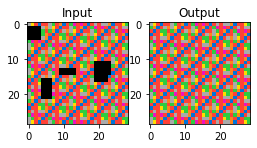

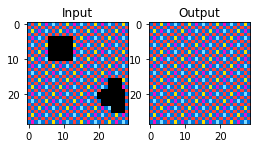

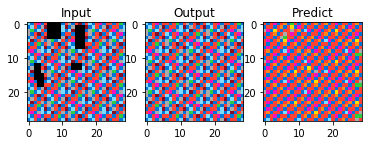

110it [02:37,  1.35s/it]

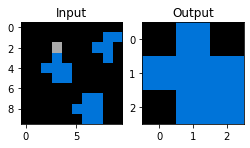

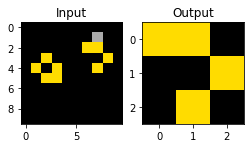

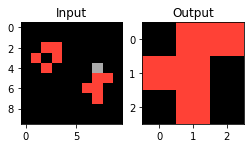

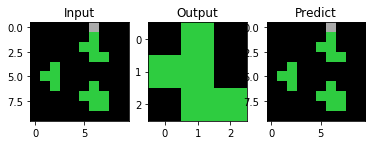

111it [02:38,  1.33s/it]

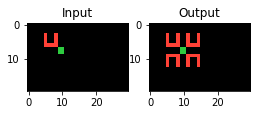

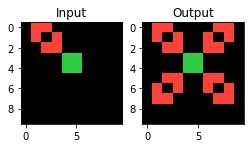

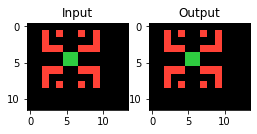

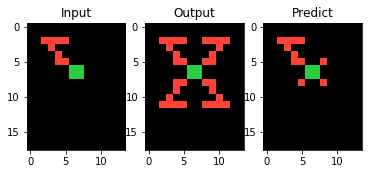

112it [02:39,  1.35s/it]

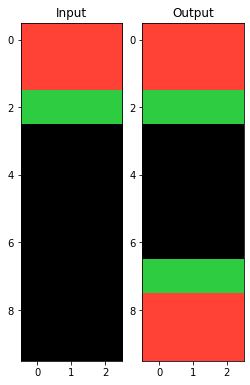

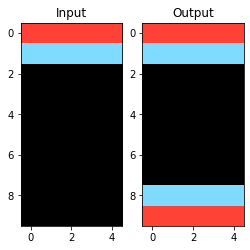

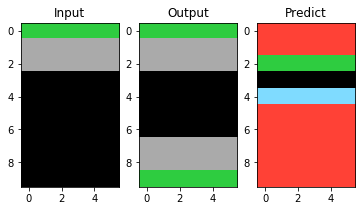

113it [02:40,  1.25s/it]

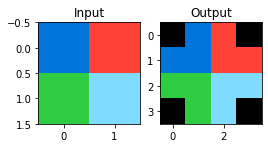

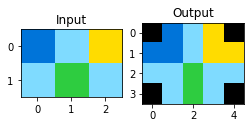

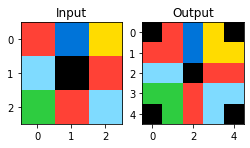

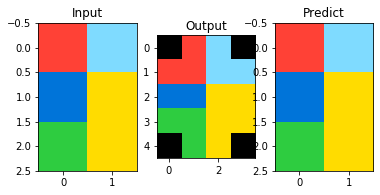

114it [02:42,  1.29s/it]

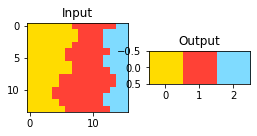

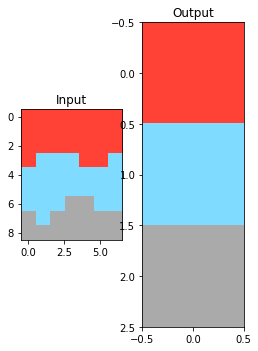

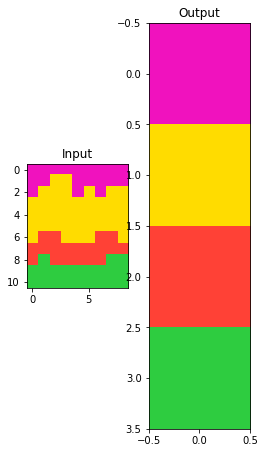

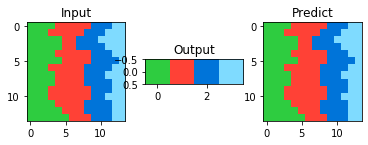

115it [02:43,  1.31s/it]

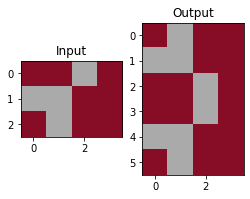

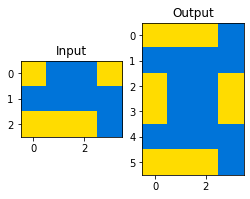

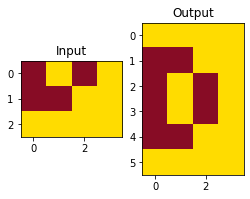

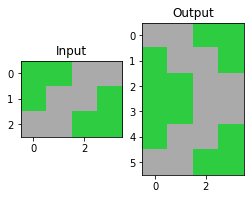

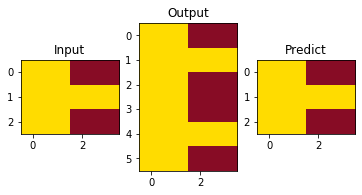

116it [02:45,  1.39s/it]

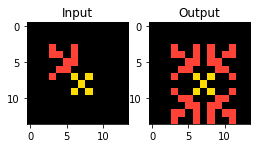

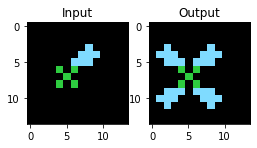

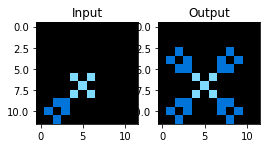

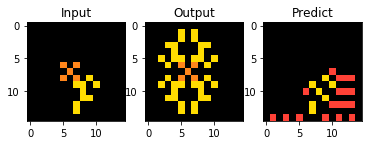

117it [02:46,  1.39s/it]

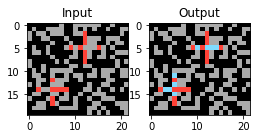

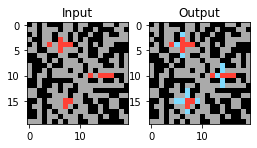

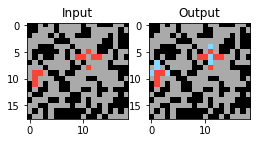

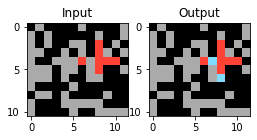

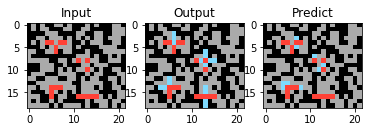

118it [02:48,  1.45s/it]

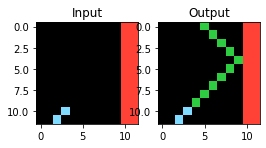

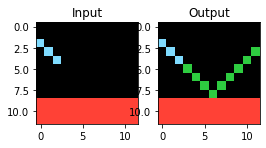

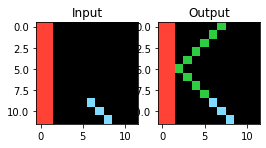

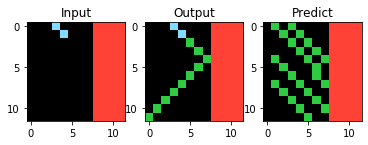

119it [02:49,  1.43s/it]

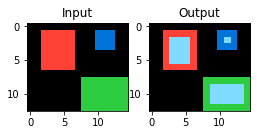

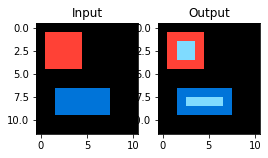

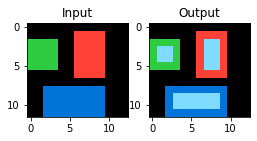

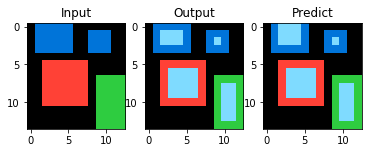

120it [02:50,  1.39s/it]

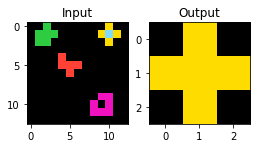

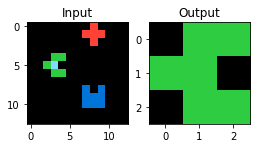

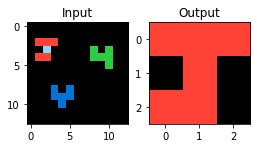

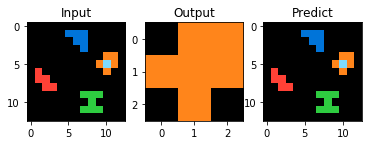

121it [02:52,  1.36s/it]

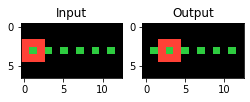

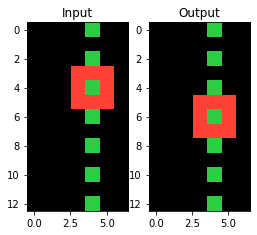

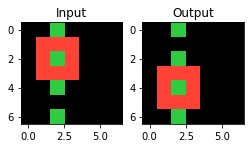

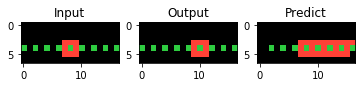

122it [02:53,  1.36s/it]

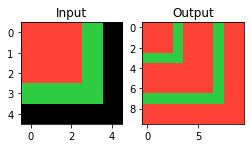

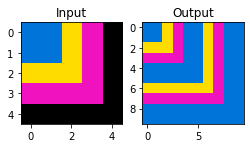

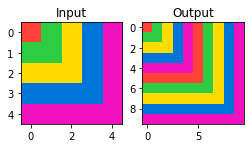

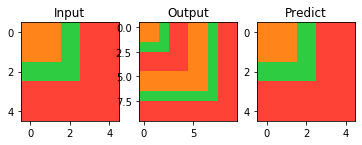

123it [02:54,  1.34s/it]

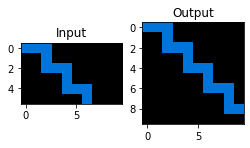

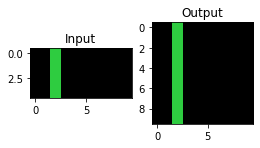

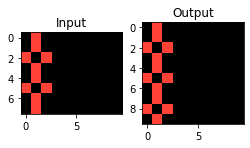

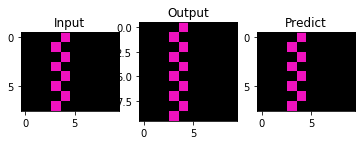

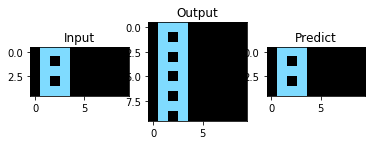

124it [02:56,  1.44s/it]

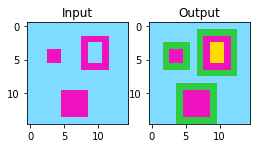

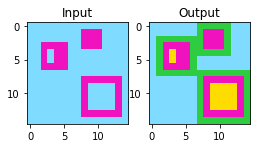

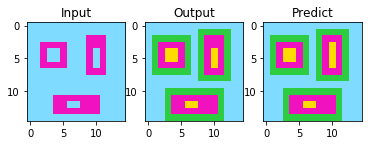

125it [02:57,  1.33s/it]

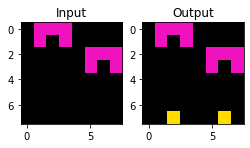

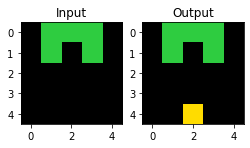

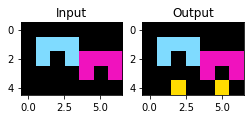

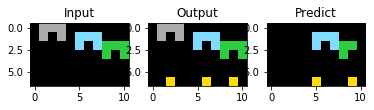

126it [02:58,  1.32s/it]

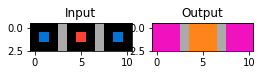

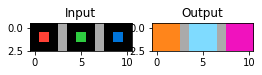

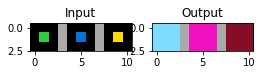

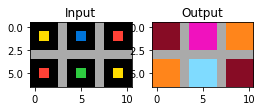

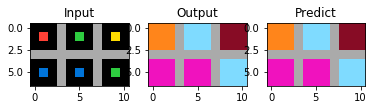

127it [03:00,  1.41s/it]

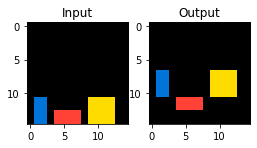

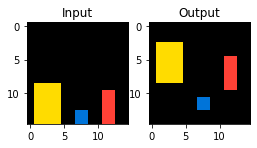

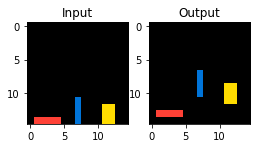

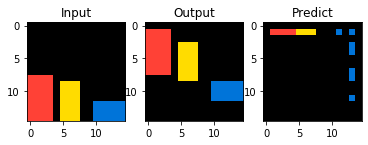

128it [03:01,  1.38s/it]

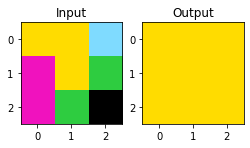

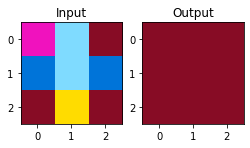

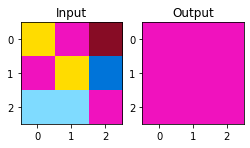

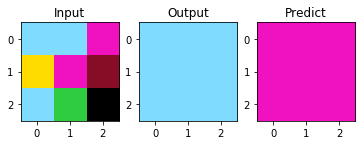

129it [03:02,  1.35s/it]

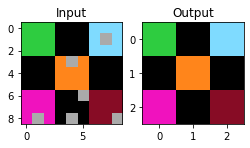

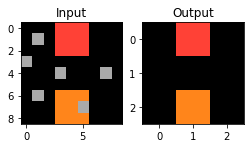

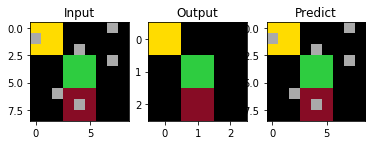

130it [03:04,  1.27s/it]

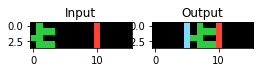

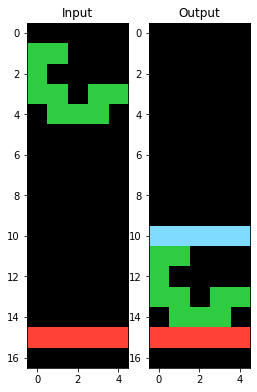

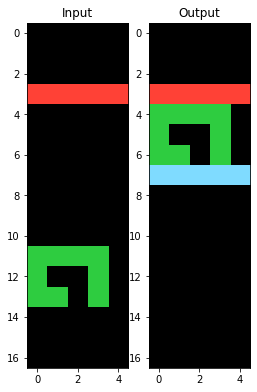

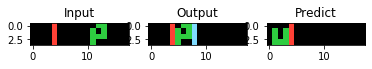

131it [03:05,  1.29s/it]

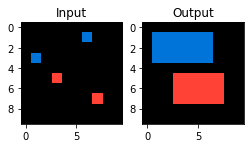

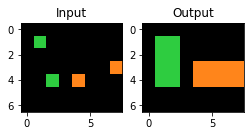

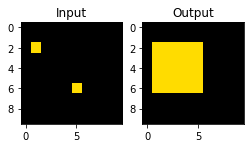

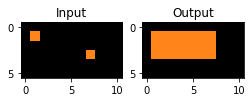

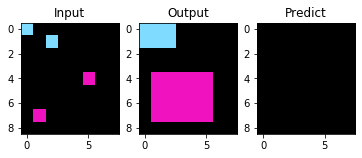

132it [03:06,  1.40s/it]

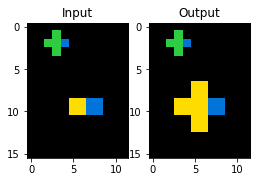

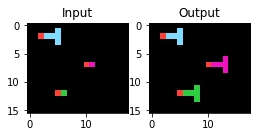

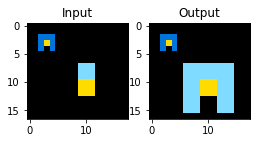

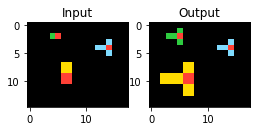

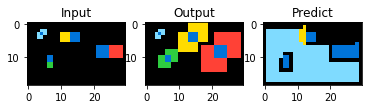

133it [03:08,  1.45s/it]

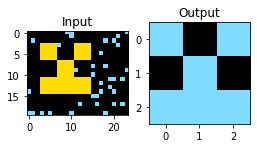

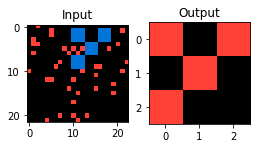

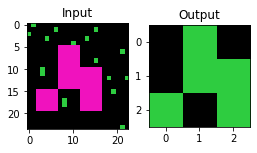

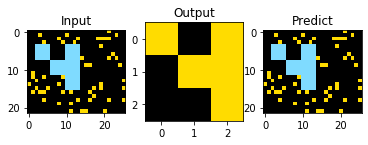

134it [03:09,  1.41s/it]

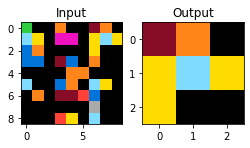

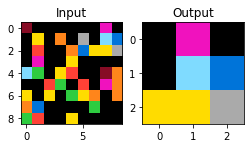

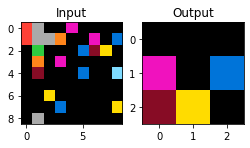

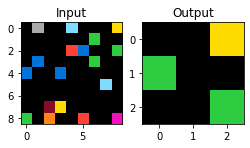

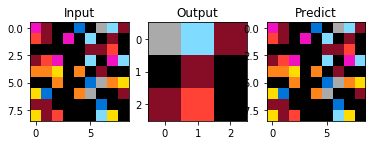

135it [03:11,  1.49s/it]

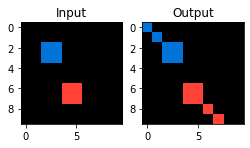

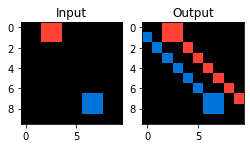

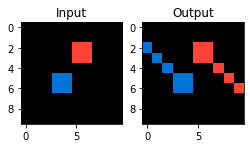

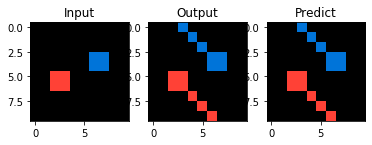

136it [03:12,  1.42s/it]

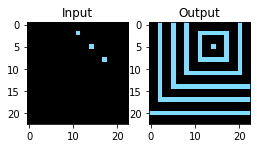

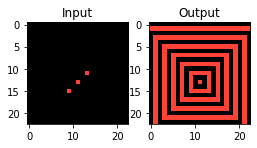

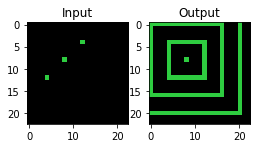

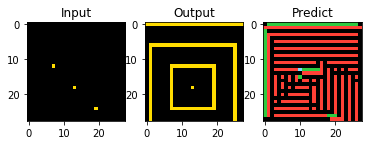

137it [03:14,  1.41s/it]

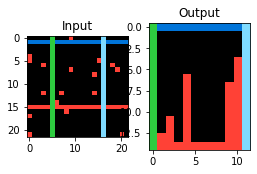

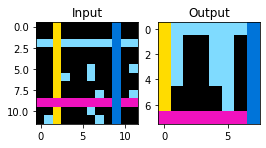

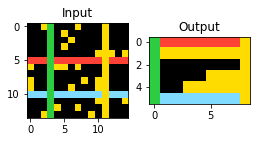

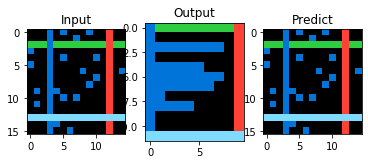

138it [03:15,  1.38s/it]

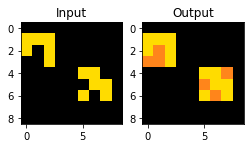

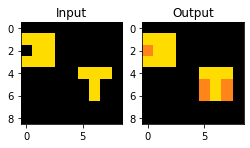

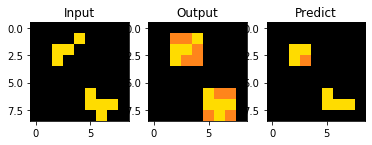

139it [03:16,  1.27s/it]

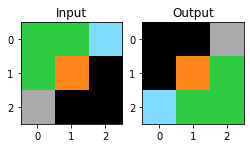

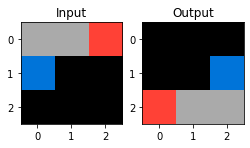

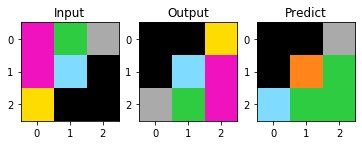

140it [03:17,  1.21s/it]

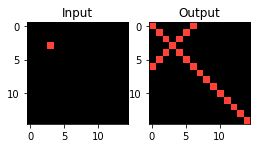

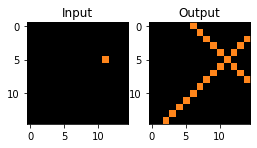

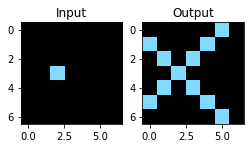

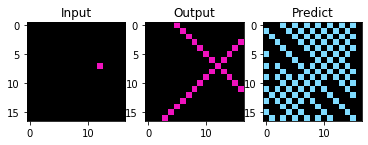

141it [03:18,  1.24s/it]

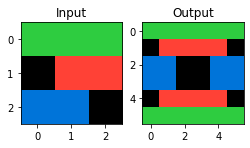

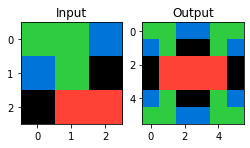

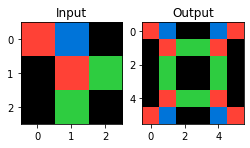

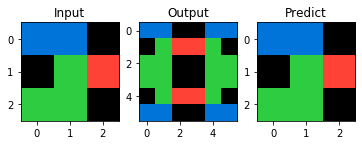

142it [03:20,  1.25s/it]

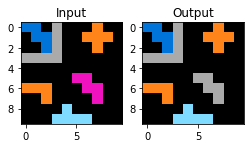

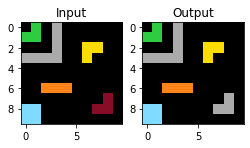

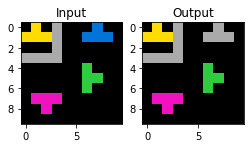

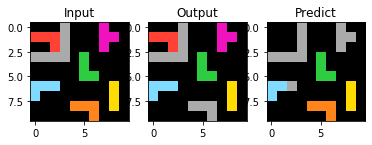

143it [03:21,  1.28s/it]

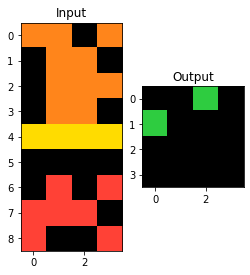

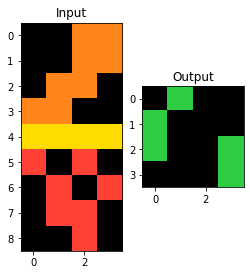

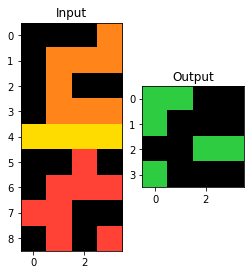

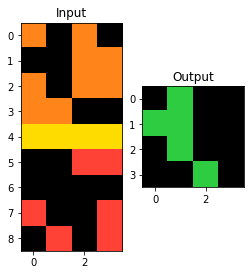

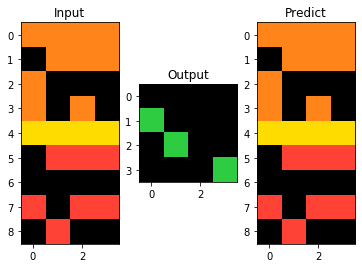

144it [03:23,  1.40s/it]

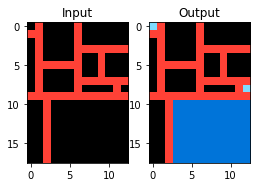

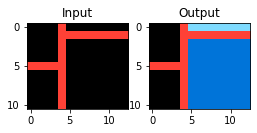

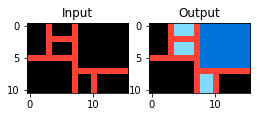

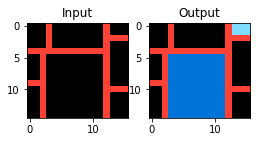

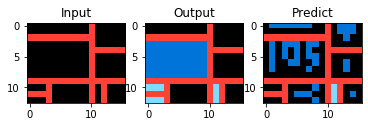

145it [03:24,  1.48s/it]

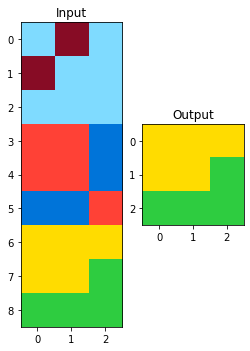

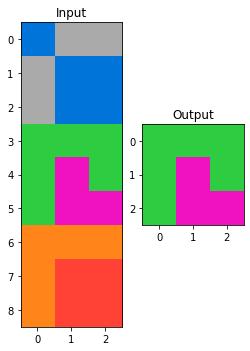

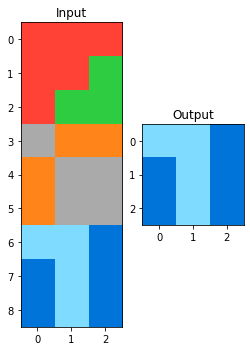

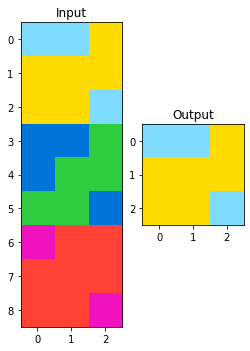

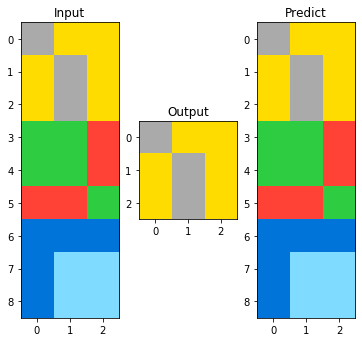

146it [03:26,  1.54s/it]

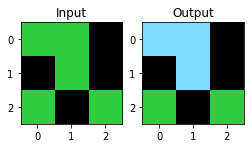

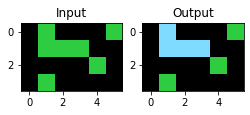

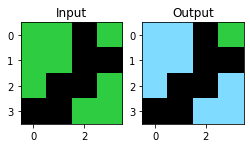

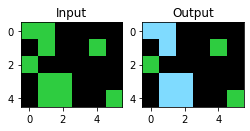

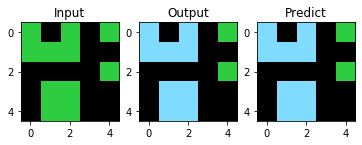

147it [03:28,  1.55s/it]

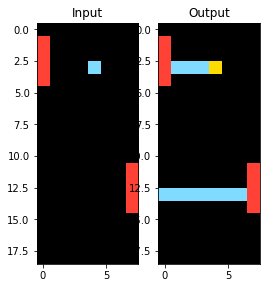

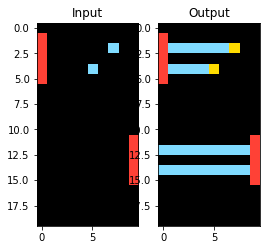

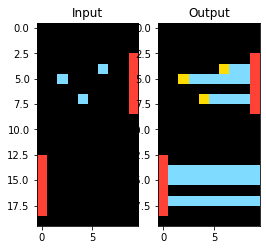

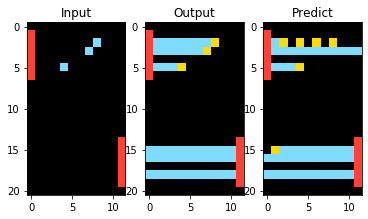

148it [03:29,  1.52s/it]

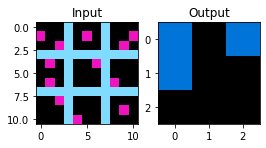

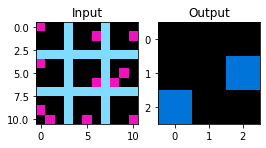

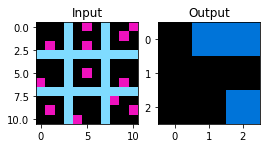

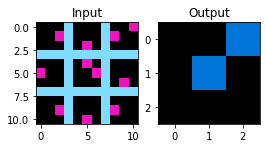

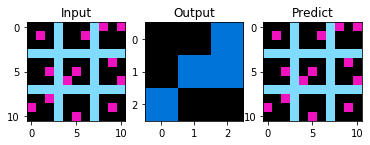

149it [03:31,  1.55s/it]

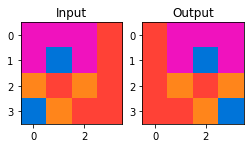

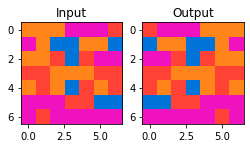

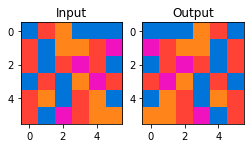

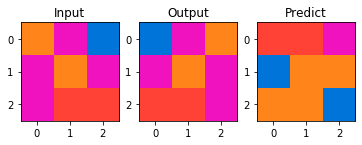

150it [03:32,  1.49s/it]

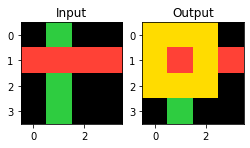

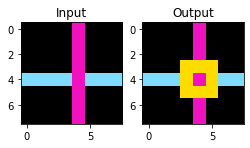

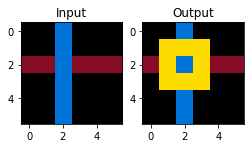

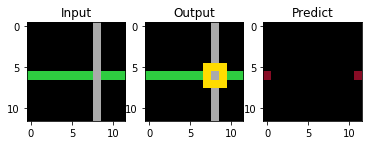

151it [03:33,  1.43s/it]

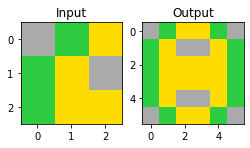

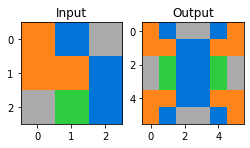

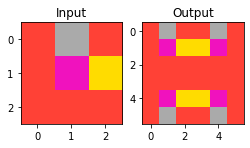

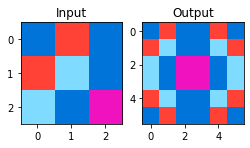

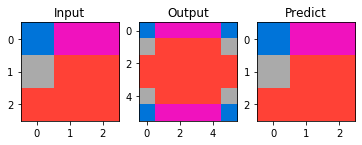

152it [03:35,  1.47s/it]

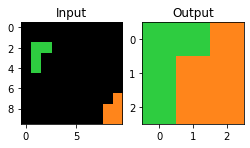

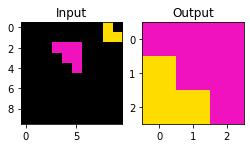

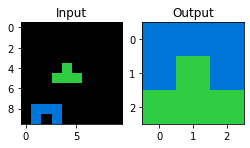

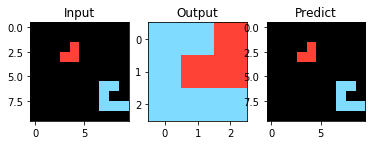

153it [03:36,  1.44s/it]

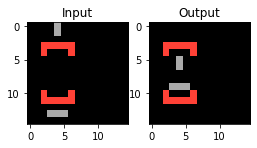

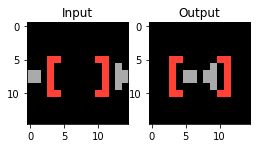

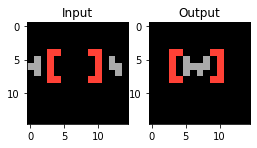

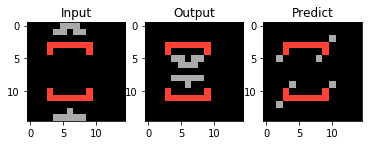

154it [03:38,  1.39s/it]

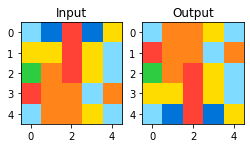

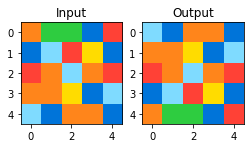

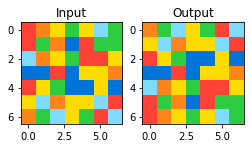

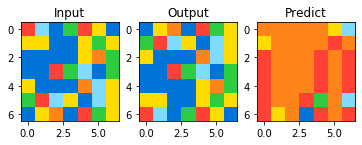

155it [03:39,  1.39s/it]

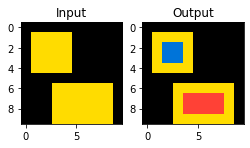

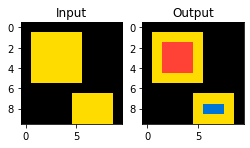

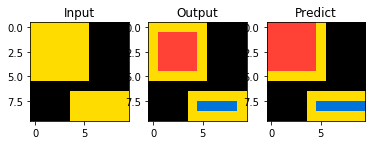

156it [03:40,  1.27s/it]

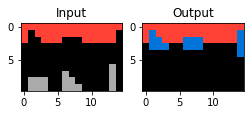

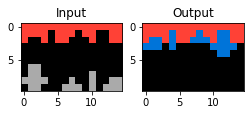

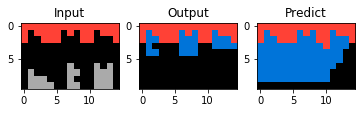

157it [03:41,  1.18s/it]

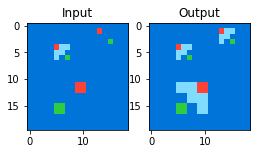

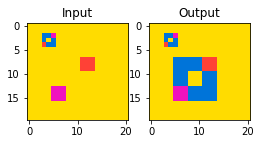

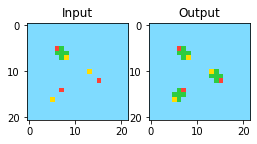

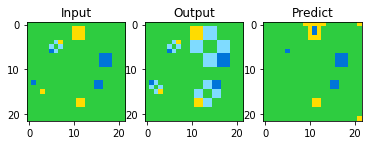

158it [03:42,  1.24s/it]

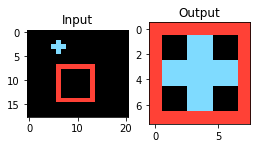

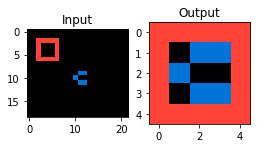

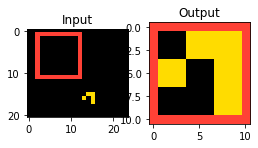

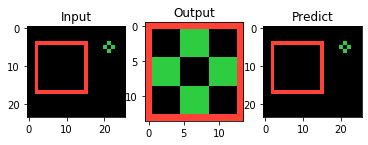

159it [03:44,  1.26s/it]

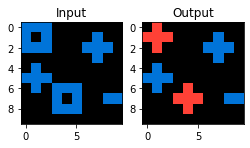

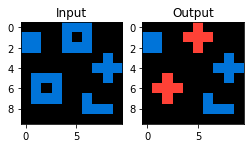

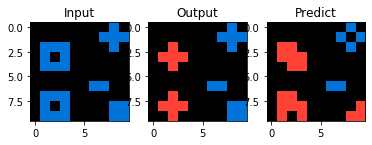

160it [03:45,  1.18s/it]

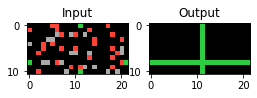

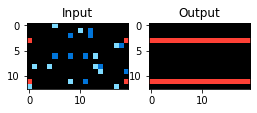

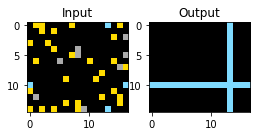

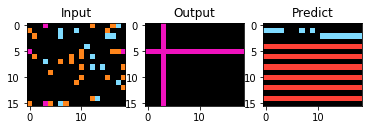

161it [03:46,  1.23s/it]

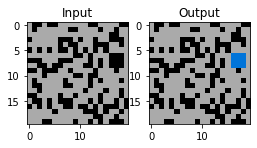

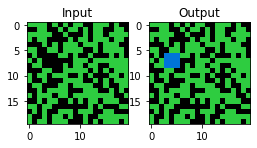

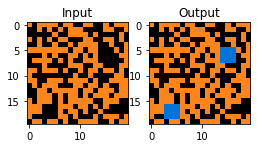

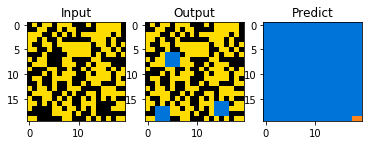

162it [03:47,  1.25s/it]

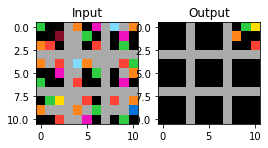

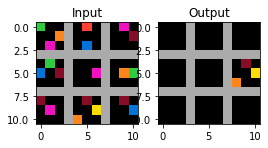

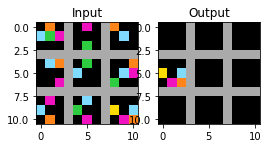

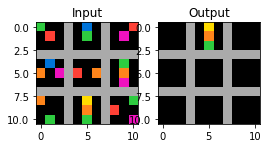

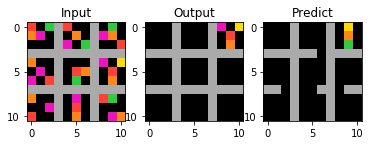

163it [03:49,  1.38s/it]

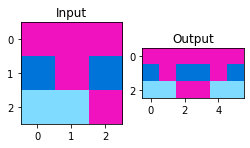

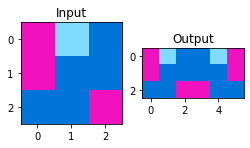

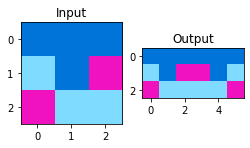

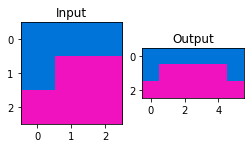

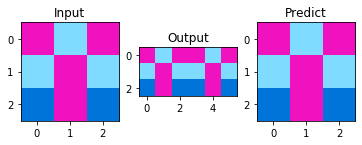

164it [03:50,  1.43s/it]

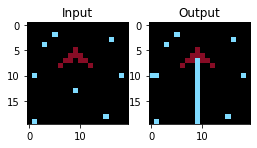

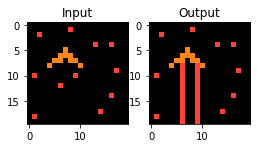

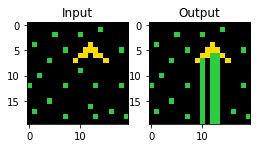

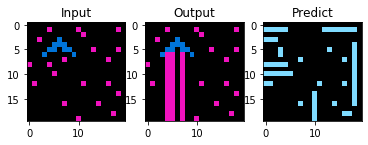

165it [03:52,  1.39s/it]

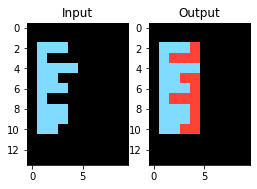

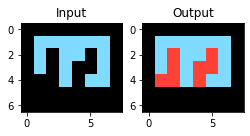

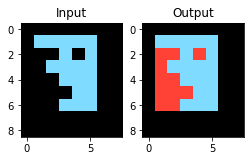

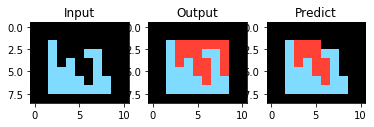

166it [03:53,  1.39s/it]

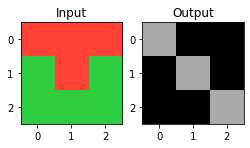

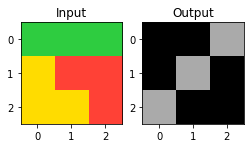

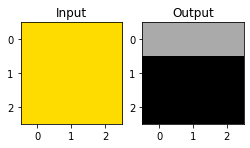

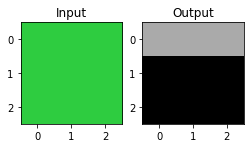

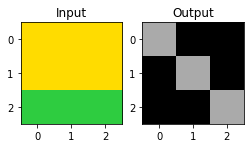

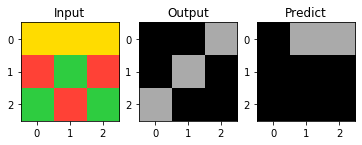

167it [03:55,  1.53s/it]

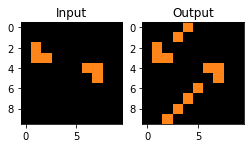

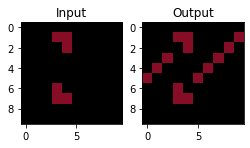

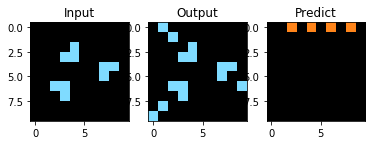

168it [03:56,  1.39s/it]

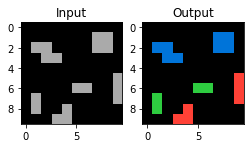

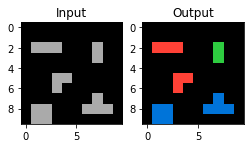

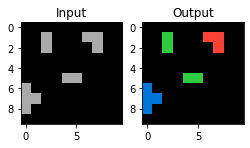

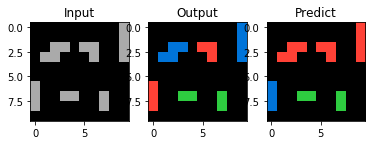

169it [03:57,  1.36s/it]

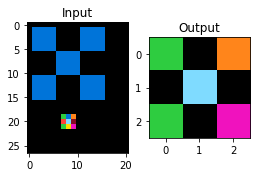

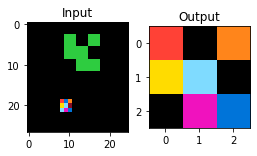

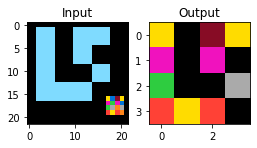

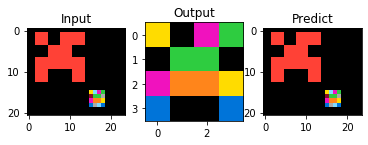

170it [03:59,  1.34s/it]

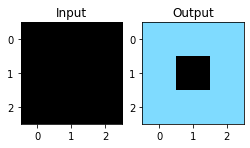

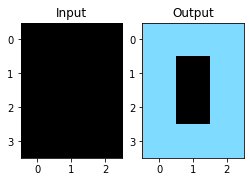

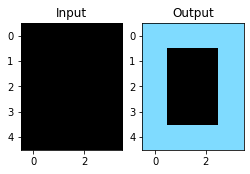

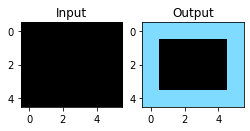

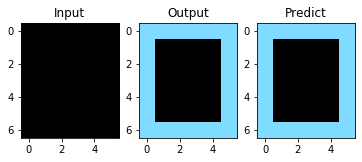

171it [04:00,  1.44s/it]

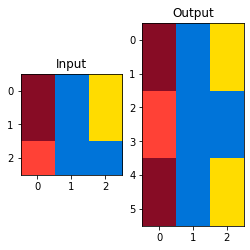

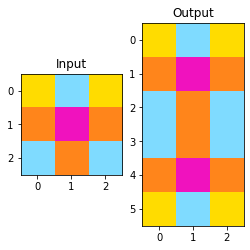

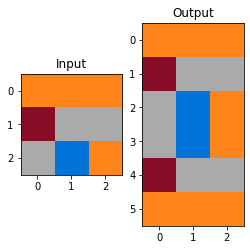

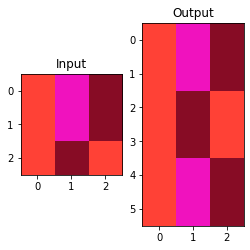

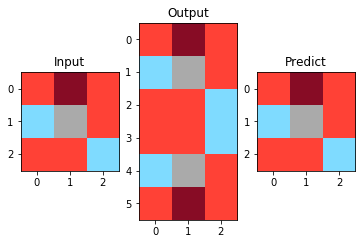

172it [04:02,  1.49s/it]

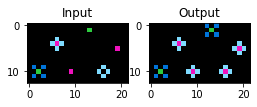

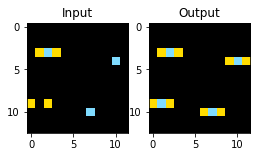

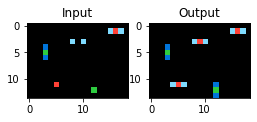

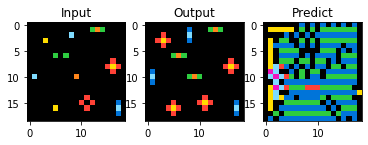

173it [04:03,  1.45s/it]

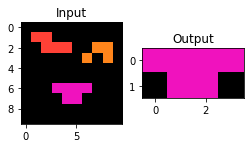

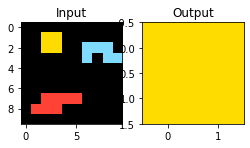

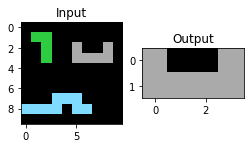

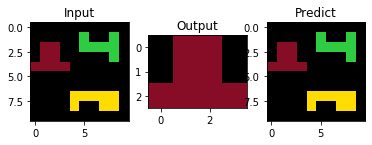

174it [04:05,  1.40s/it]

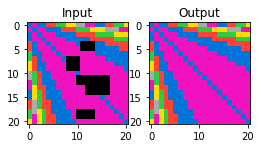

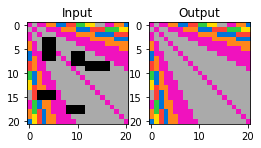

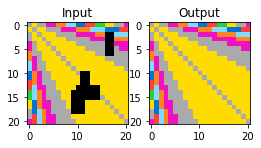

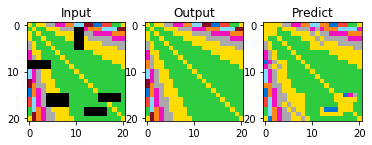

175it [04:06,  1.38s/it]

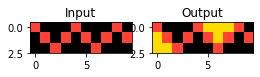

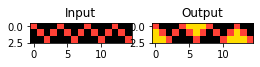

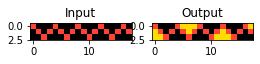

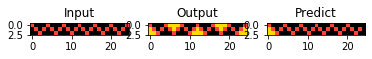

176it [04:07,  1.36s/it]

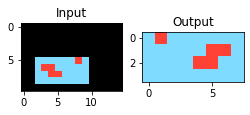

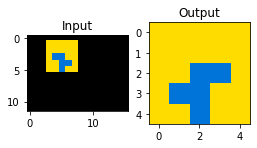

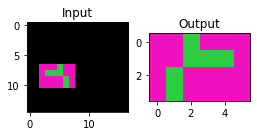

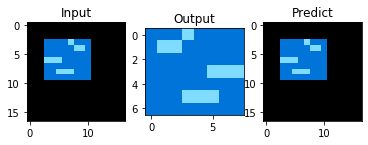

177it [04:08,  1.33s/it]

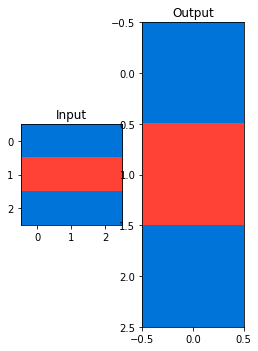

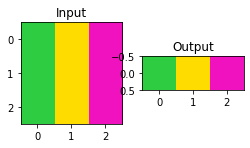

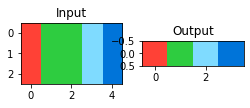

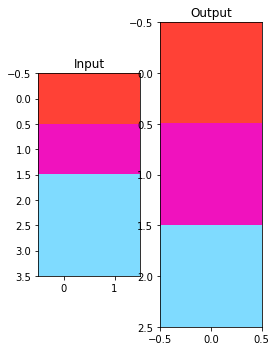

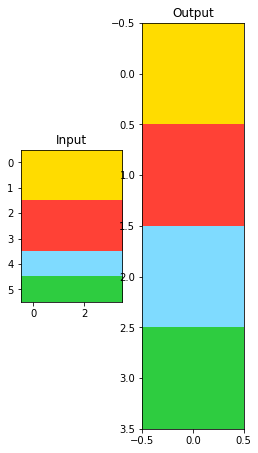

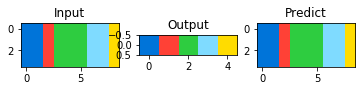

178it [04:11,  1.54s/it]

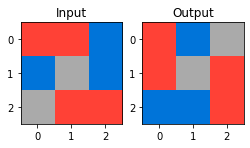

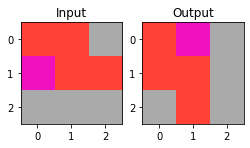

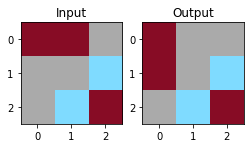

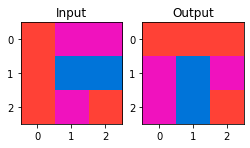

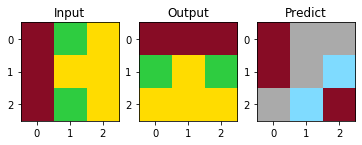

179it [04:12,  1.55s/it]

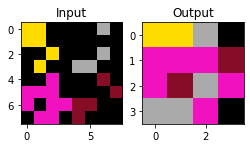

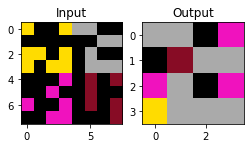

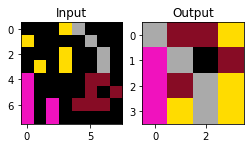

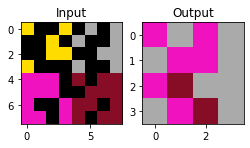

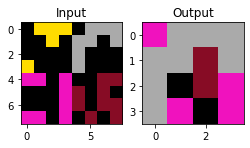

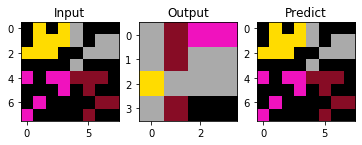

180it [04:14,  1.67s/it]

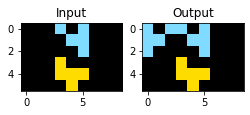

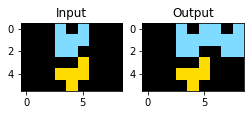

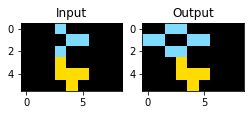

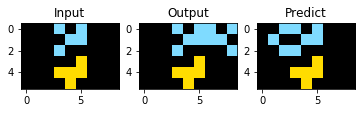

181it [04:15,  1.54s/it]

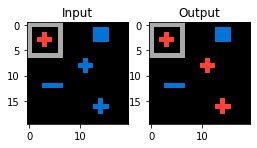

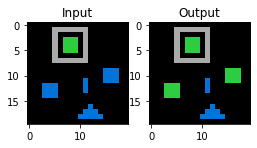

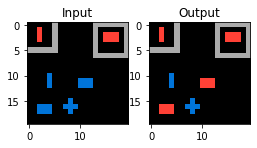

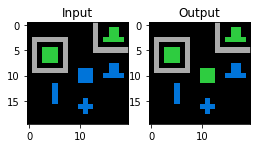

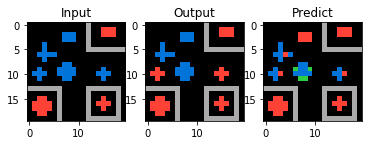

182it [04:17,  1.55s/it]

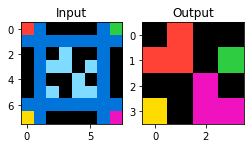

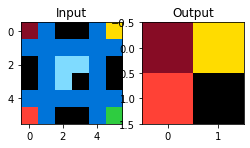

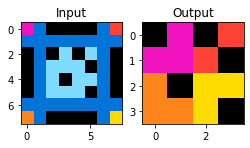

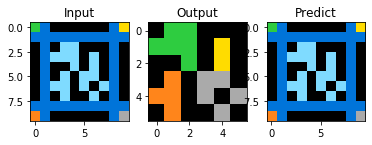

183it [04:18,  1.50s/it]

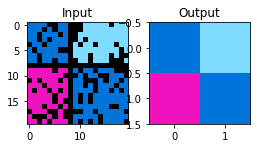

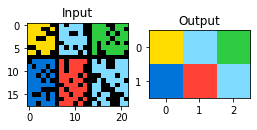

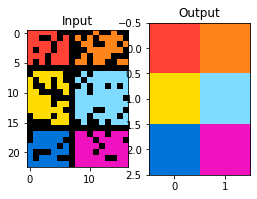

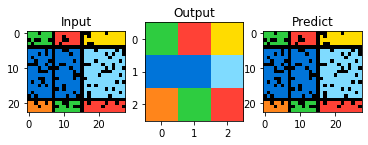

184it [04:20,  1.44s/it]

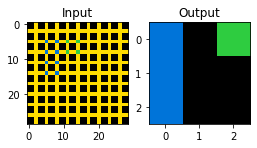

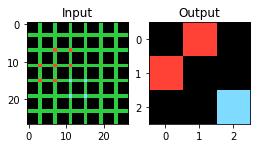

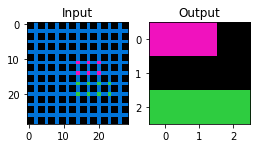

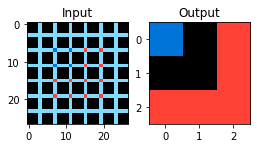

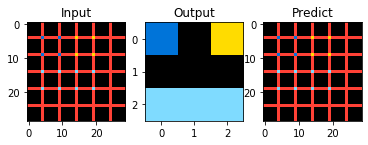

185it [04:21,  1.50s/it]

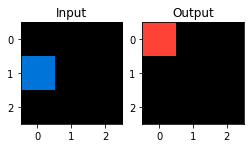

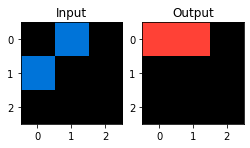

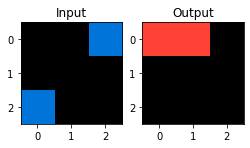

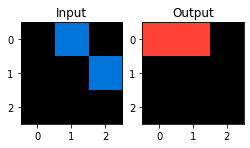

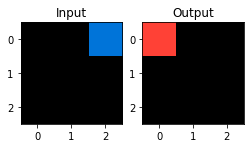

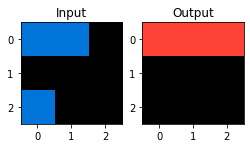

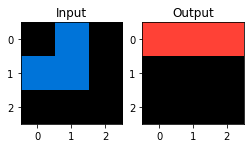

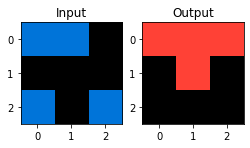

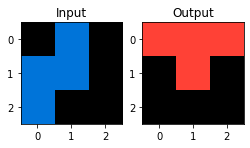

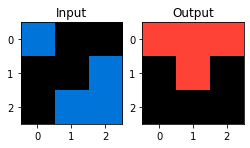

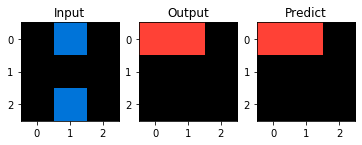

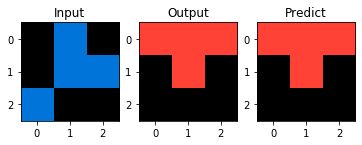

186it [04:25,  2.18s/it]

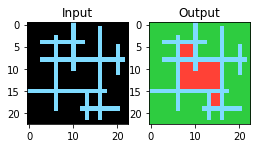

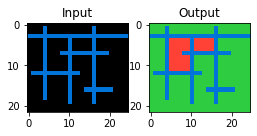

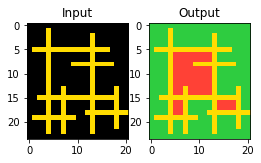

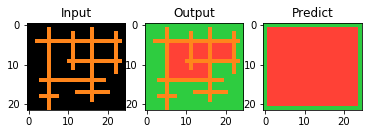

187it [04:26,  1.92s/it]

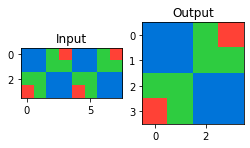

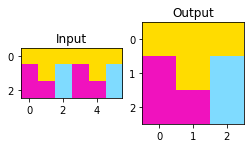

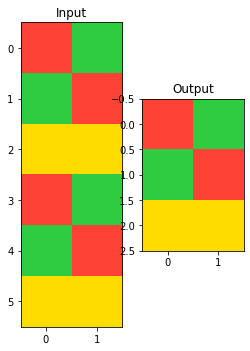

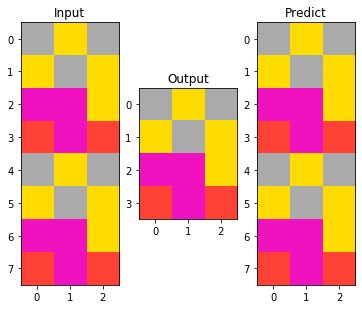

188it [04:28,  1.74s/it]

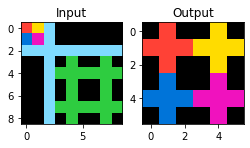

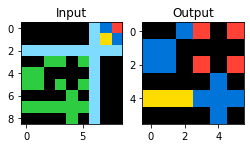

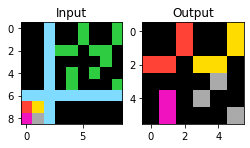

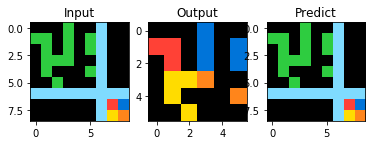

189it [04:29,  1.64s/it]

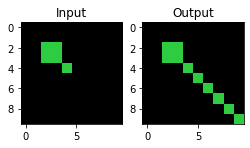

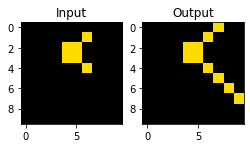

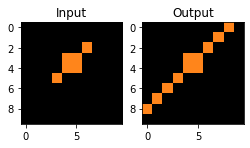

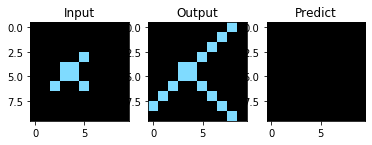

190it [04:30,  1.53s/it]

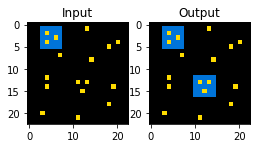

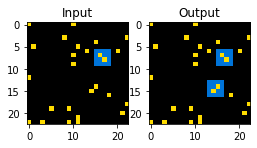

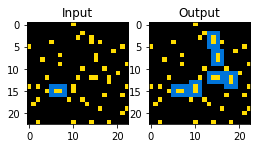

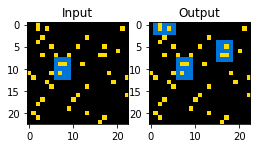

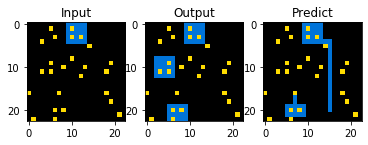

191it [04:32,  1.55s/it]

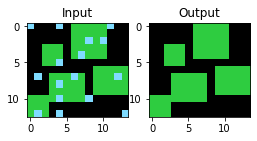

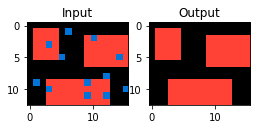

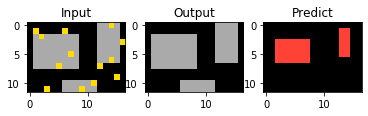

192it [04:33,  1.41s/it]

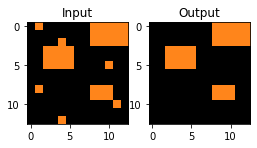

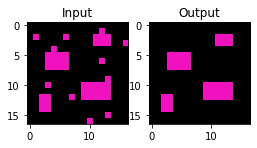

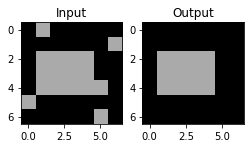

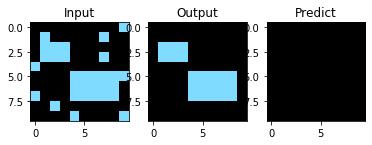

193it [04:34,  1.37s/it]

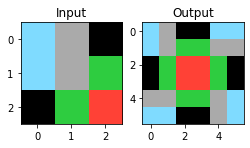

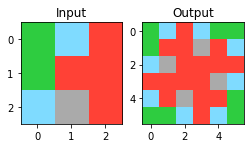

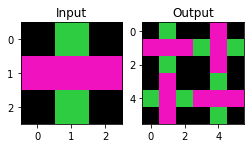

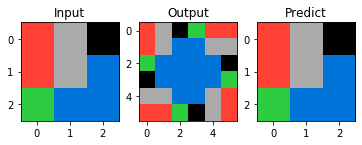

194it [04:35,  1.34s/it]

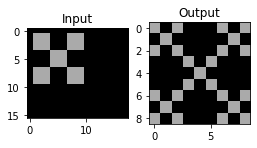

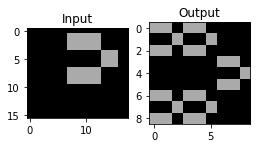

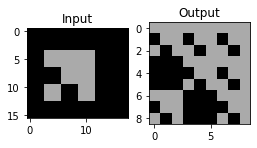

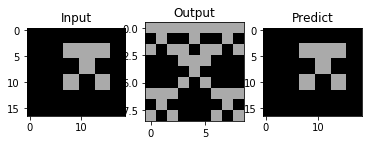

195it [04:37,  1.36s/it]

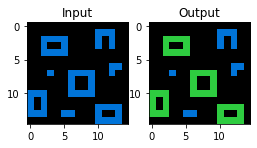

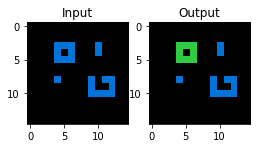

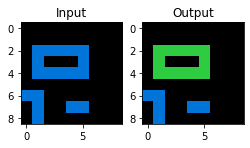

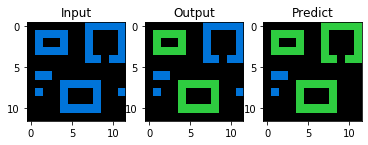

196it [04:38,  1.34s/it]

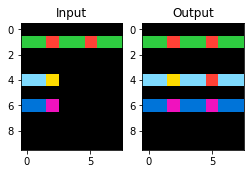

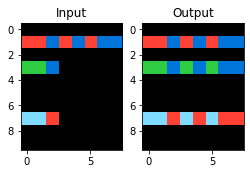

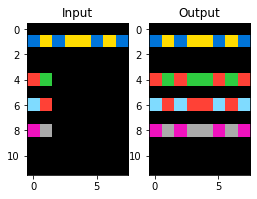

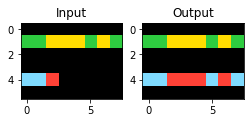

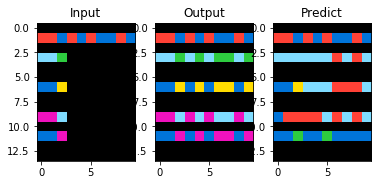

197it [04:40,  1.44s/it]

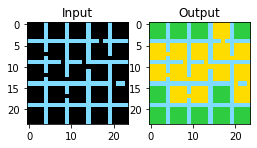

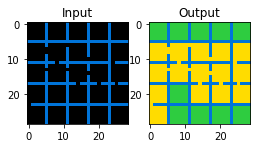

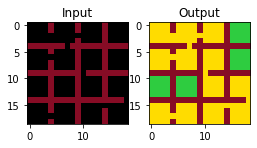

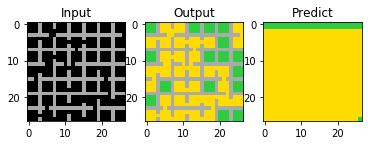

198it [04:41,  1.39s/it]

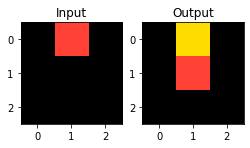

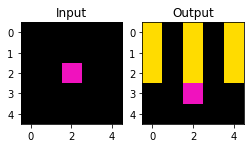

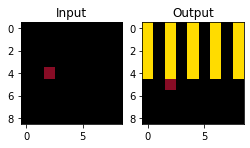

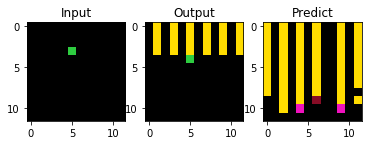

199it [04:42,  1.38s/it]

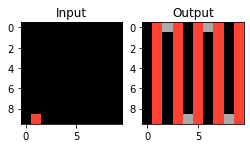

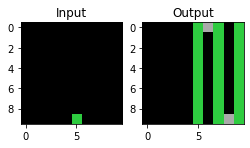

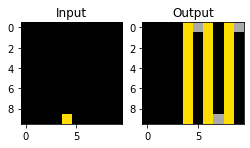

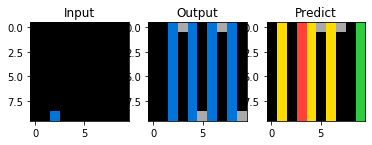

200it [04:44,  1.35s/it]

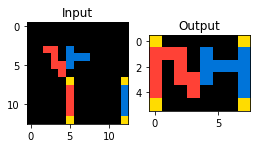

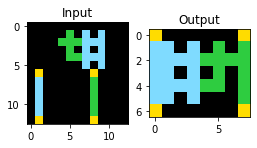

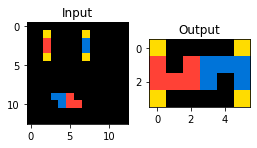

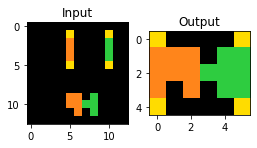

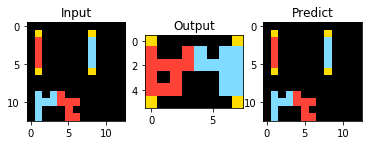

201it [04:45,  1.42s/it]

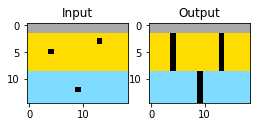

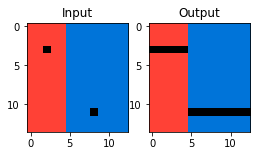

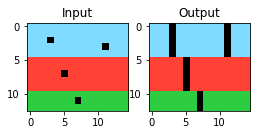

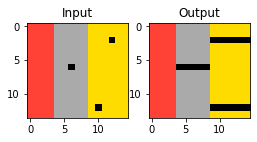

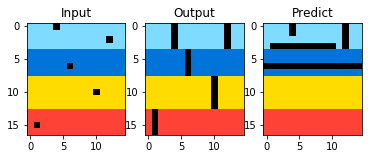

202it [04:47,  1.49s/it]

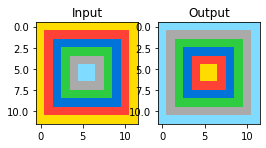

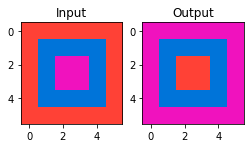

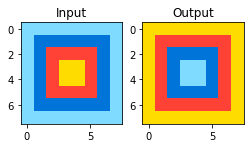

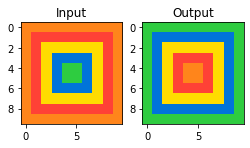

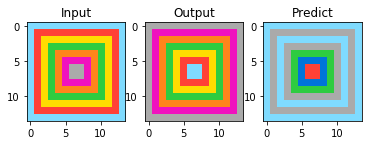

203it [04:49,  1.52s/it]

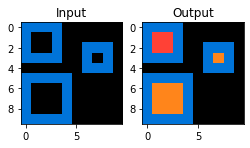

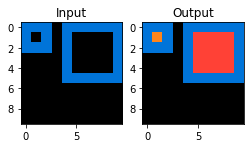

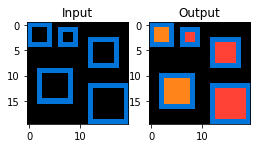

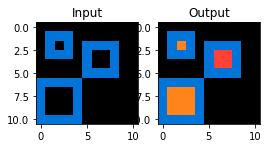

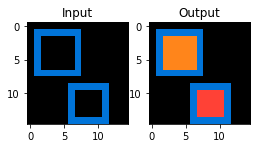

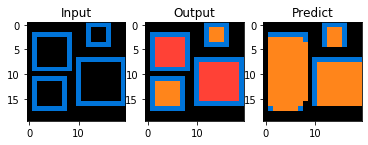

204it [04:50,  1.64s/it]

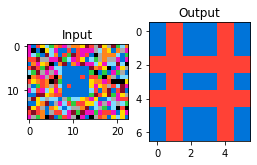

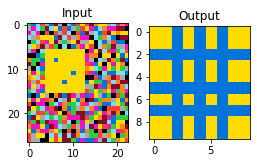

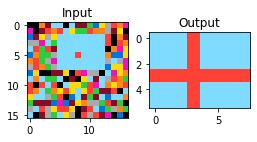

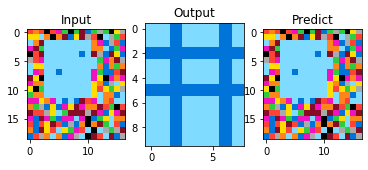

205it [04:52,  1.54s/it]

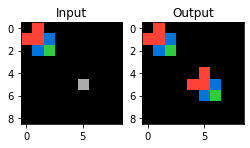

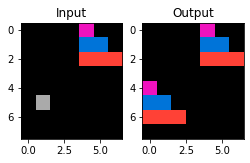

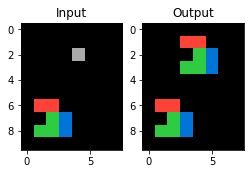

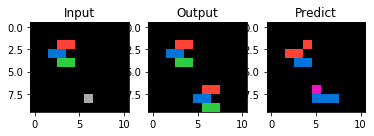

206it [04:53,  1.50s/it]

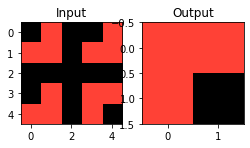

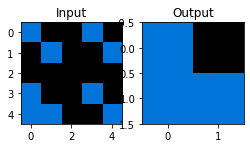

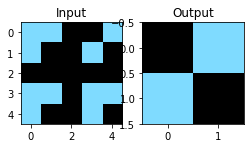

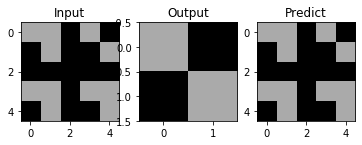

207it [04:54,  1.44s/it]

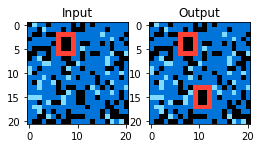

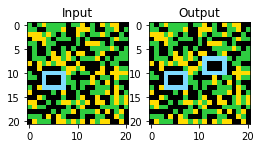

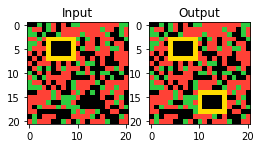

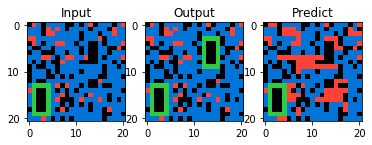

208it [04:56,  1.41s/it]

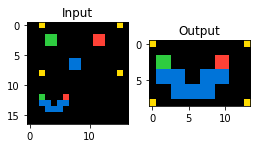

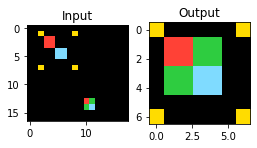

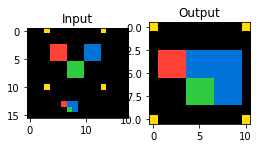

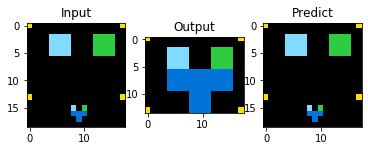

209it [04:57,  1.40s/it]

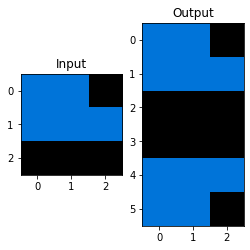

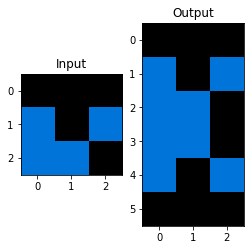

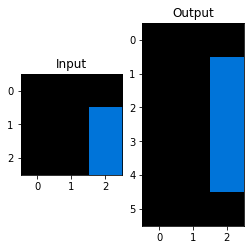

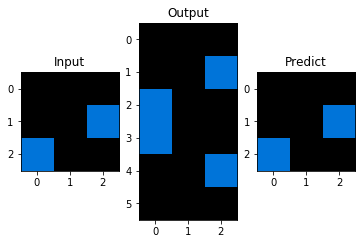

210it [04:59,  1.38s/it]

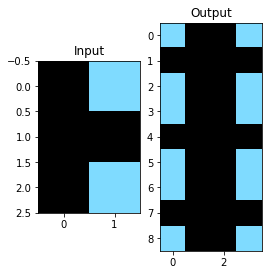

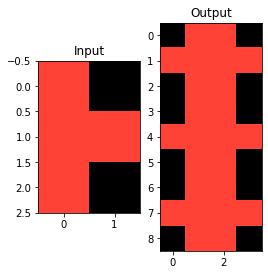

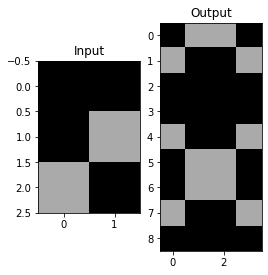

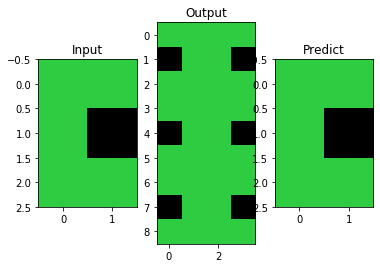

211it [05:00,  1.39s/it]

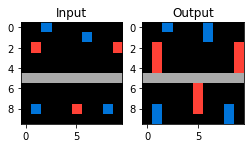

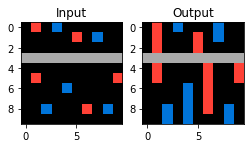

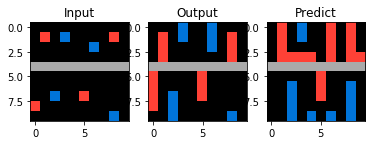

212it [05:01,  1.29s/it]

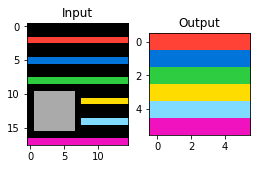

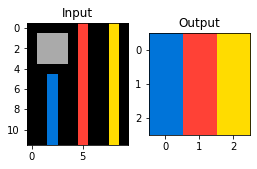

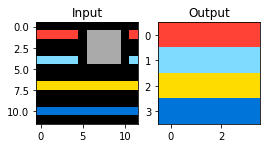

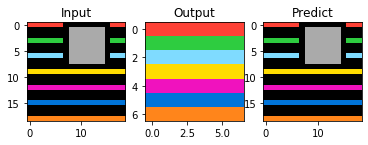

213it [05:02,  1.30s/it]

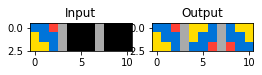

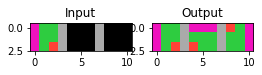

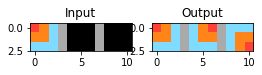

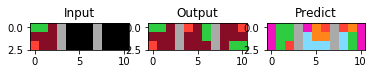

214it [05:04,  1.28s/it]

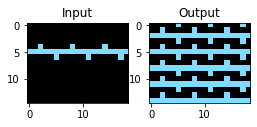

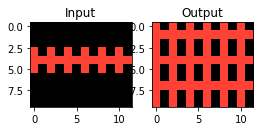

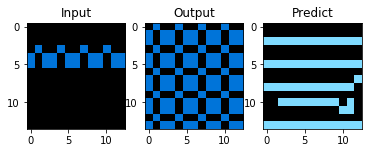

215it [05:05,  1.22s/it]

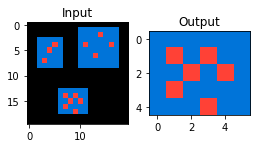

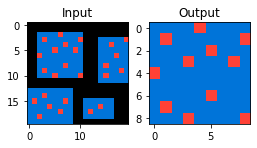

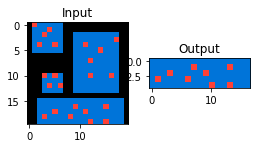

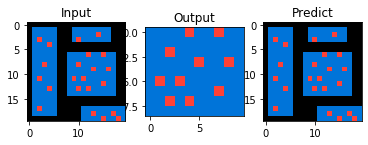

216it [05:06,  1.24s/it]

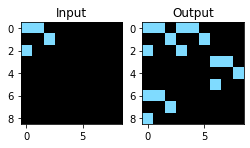

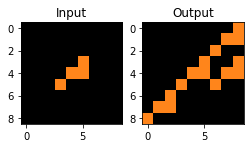

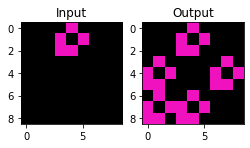

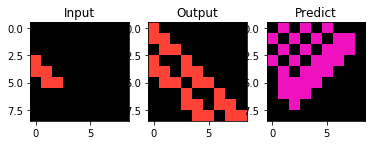

217it [05:07,  1.28s/it]

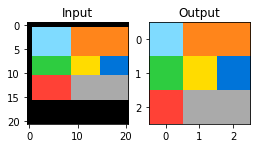

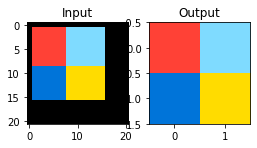

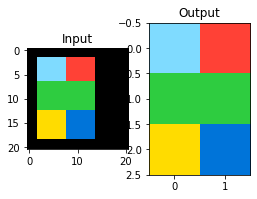

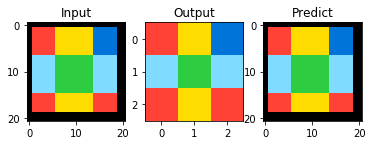

218it [05:09,  1.30s/it]

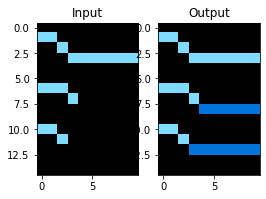

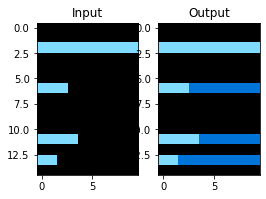

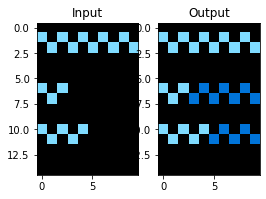

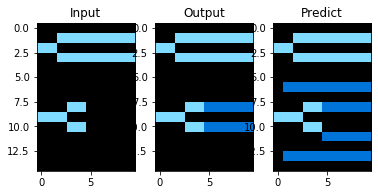

219it [05:10,  1.31s/it]

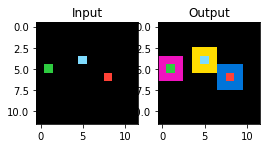

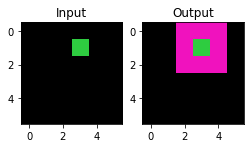

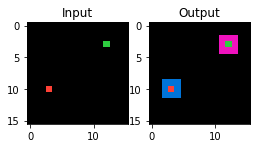

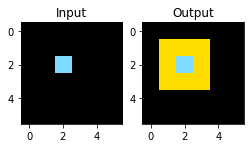

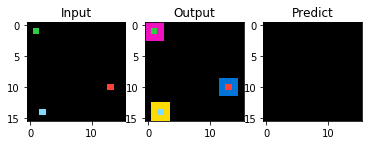

220it [05:12,  1.42s/it]

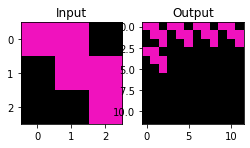

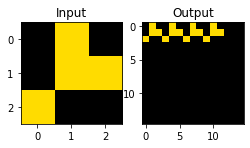

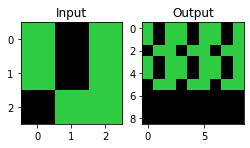

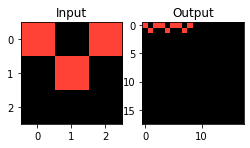

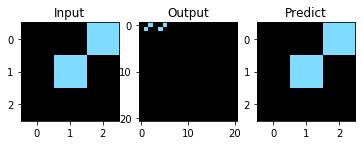

221it [05:13,  1.47s/it]

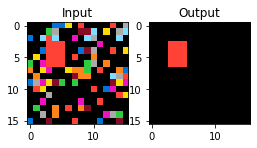

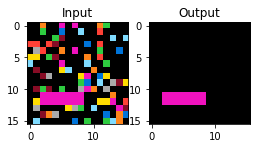

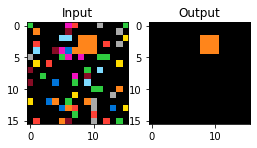

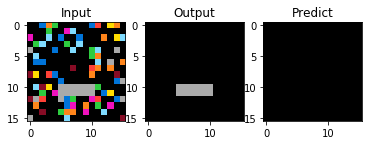

222it [05:15,  1.44s/it]

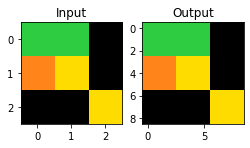

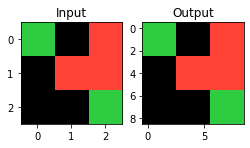

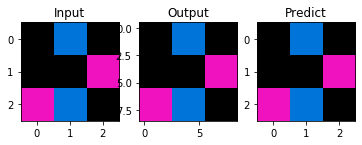

223it [05:16,  1.31s/it]

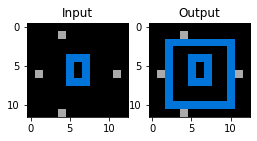

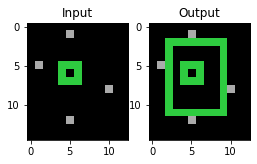

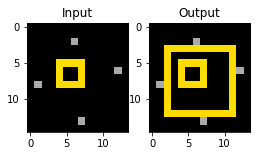

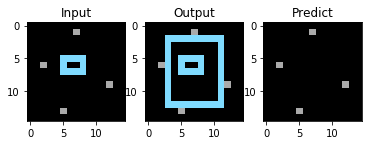

224it [05:17,  1.30s/it]

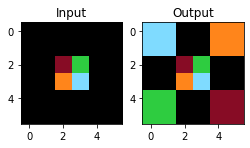

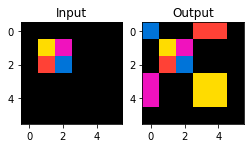

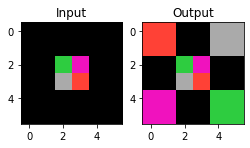

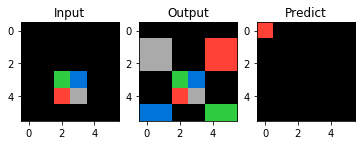

225it [05:18,  1.33s/it]

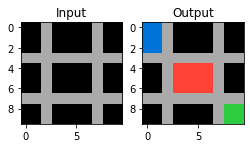

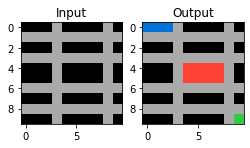

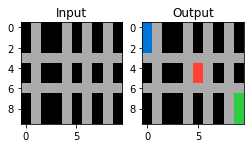

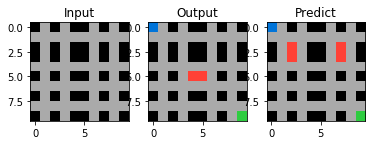

226it [05:20,  1.31s/it]

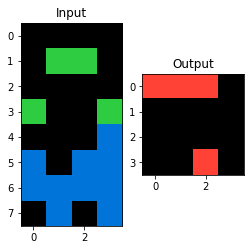

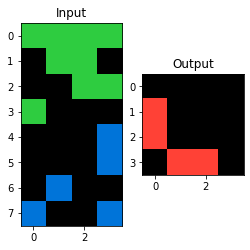

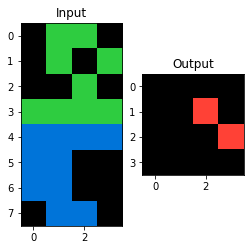

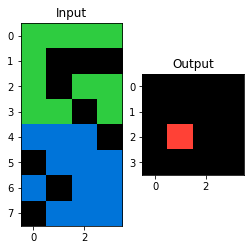

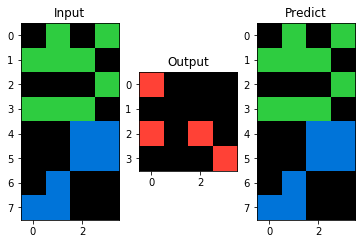

227it [05:21,  1.41s/it]

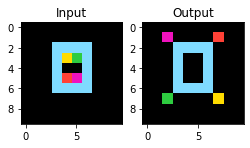

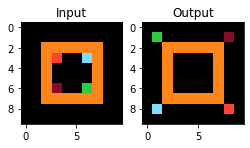

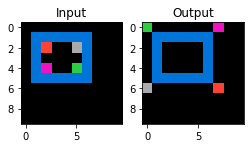

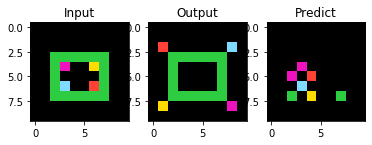

228it [05:23,  1.40s/it]

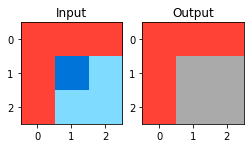

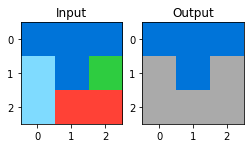

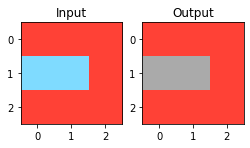

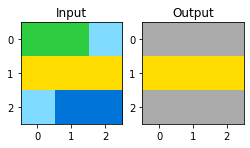

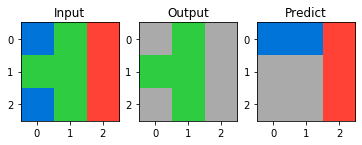

229it [05:24,  1.44s/it]

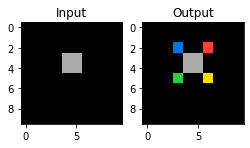

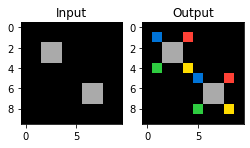

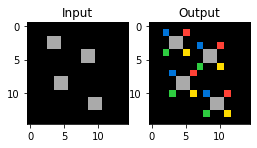

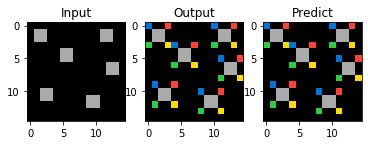

230it [05:25,  1.42s/it]

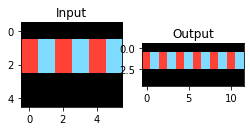

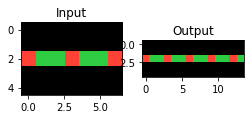

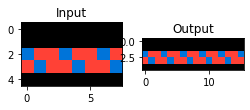

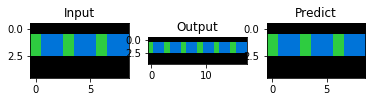

231it [05:27,  1.37s/it]

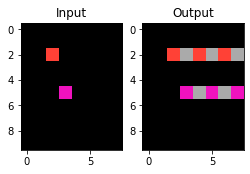

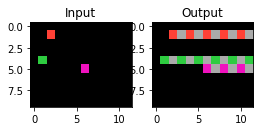

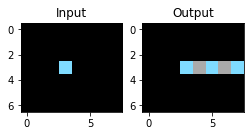

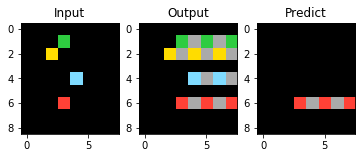

232it [05:28,  1.35s/it]

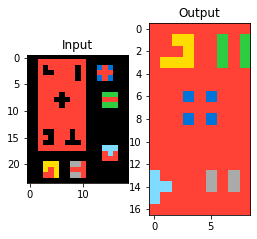

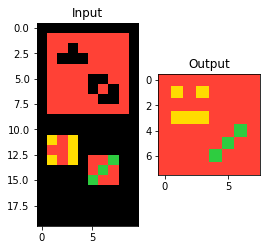

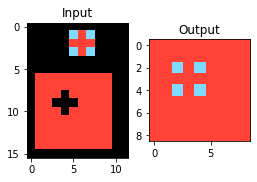

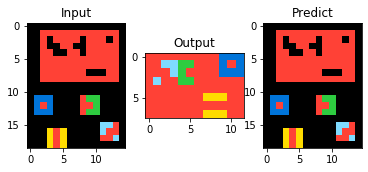

233it [05:29,  1.37s/it]

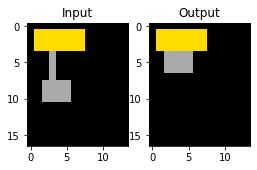

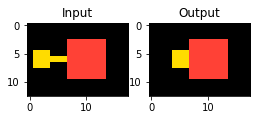

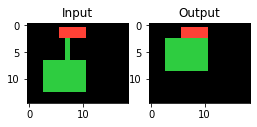

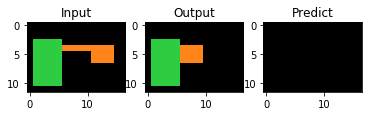

234it [05:31,  1.34s/it]

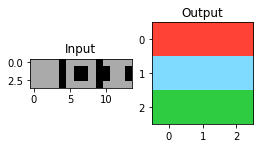

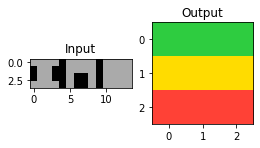

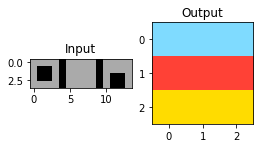

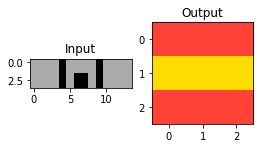

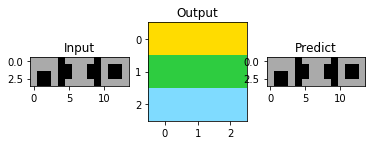

235it [05:32,  1.43s/it]

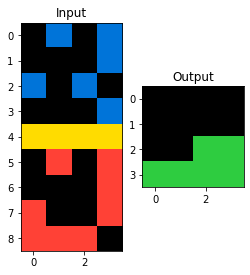

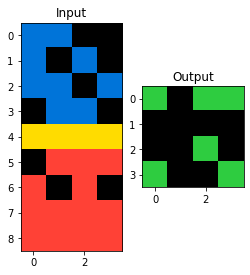

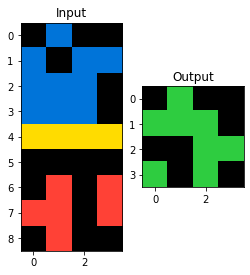

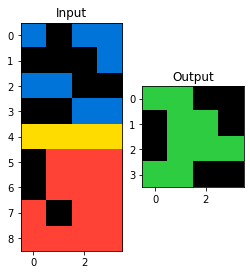

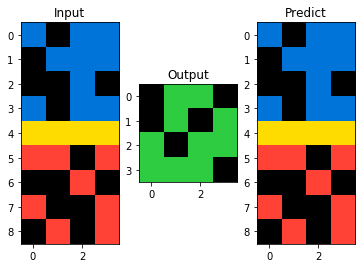

236it [05:34,  1.50s/it]

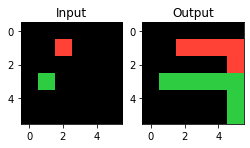

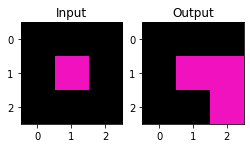

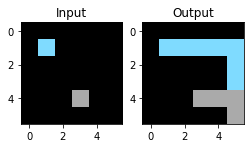

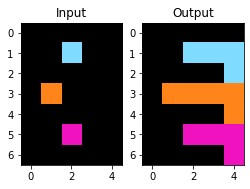

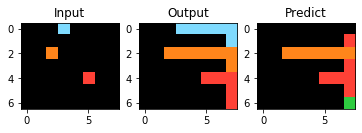

237it [05:36,  1.52s/it]

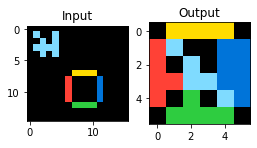

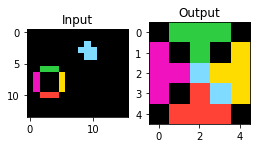

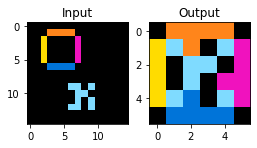

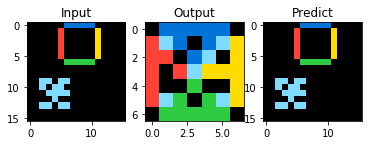

238it [05:37,  1.48s/it]

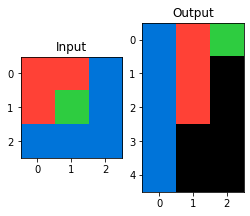

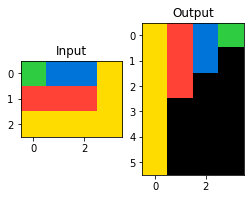

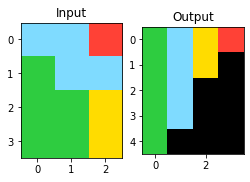

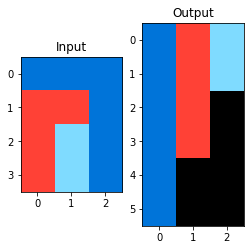

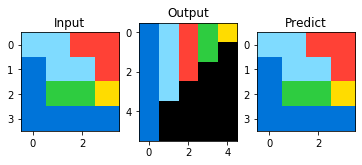

239it [05:39,  1.52s/it]

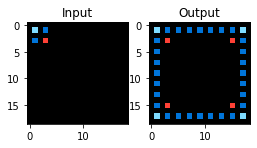

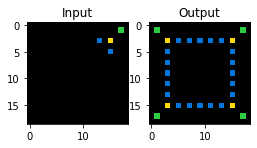

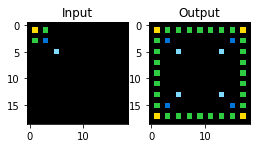

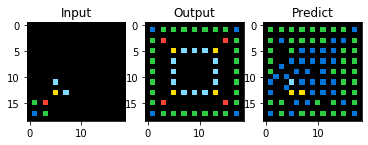

240it [05:40,  1.48s/it]

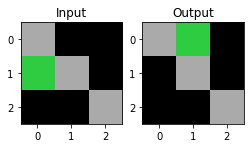

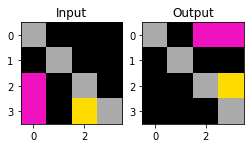

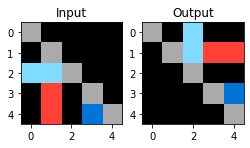

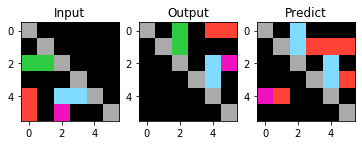

241it [05:41,  1.42s/it]

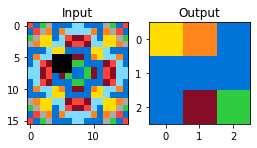

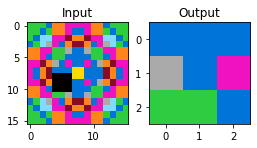

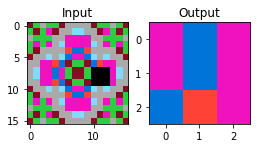

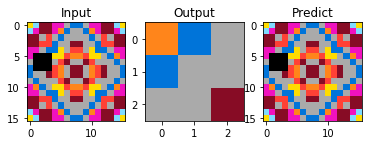

242it [05:43,  1.38s/it]

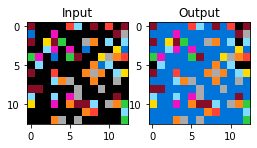

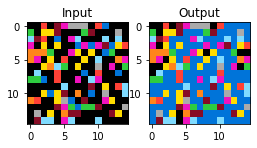

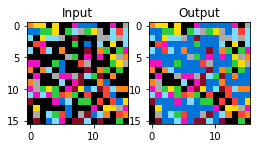

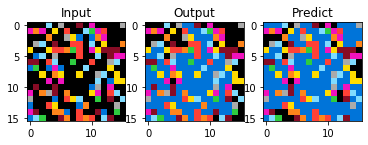

243it [05:44,  1.38s/it]

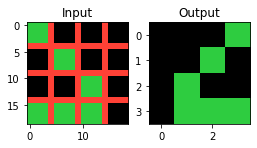

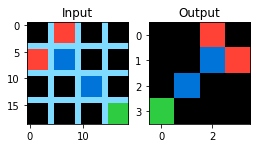

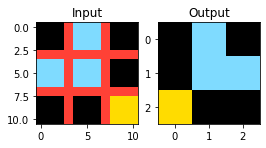

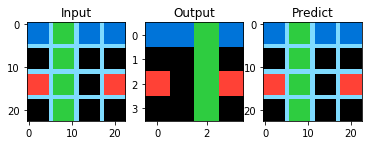

244it [05:45,  1.35s/it]

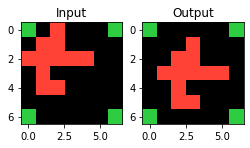

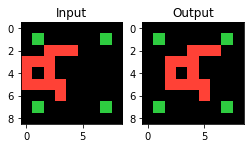

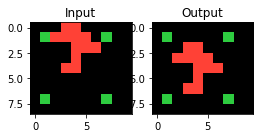

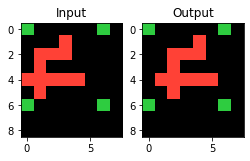

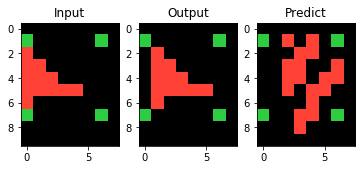

245it [05:47,  1.45s/it]

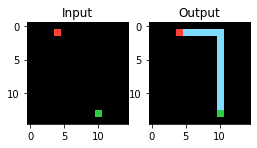

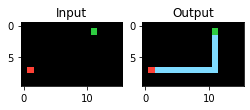

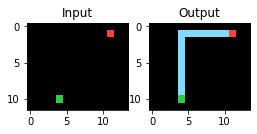

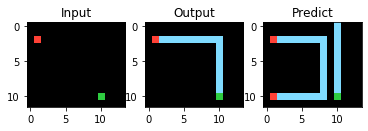

246it [05:48,  1.39s/it]

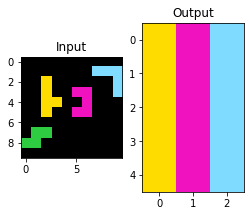

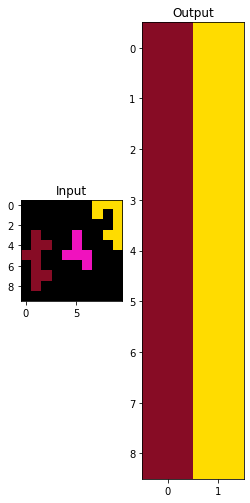

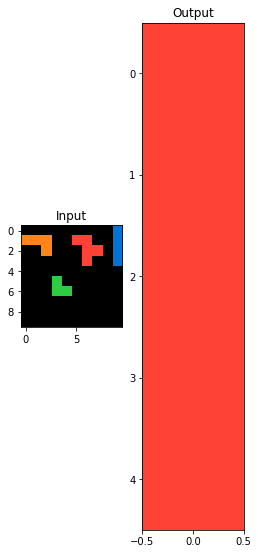

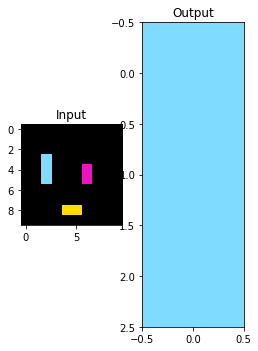

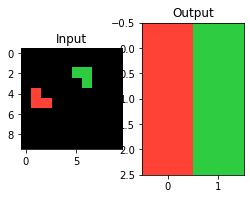

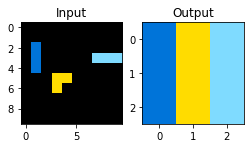

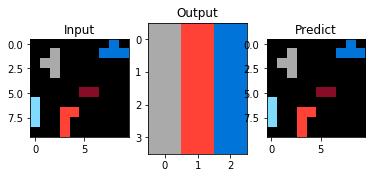

247it [05:50,  1.67s/it]

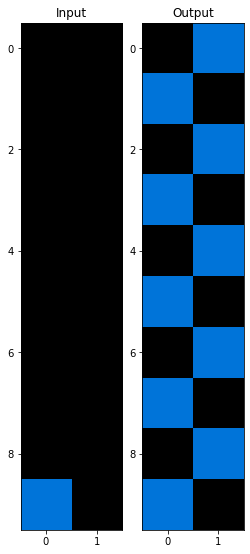

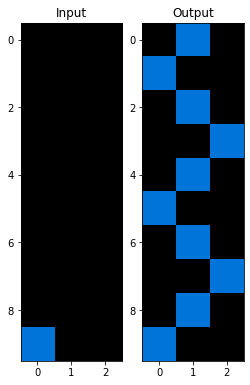

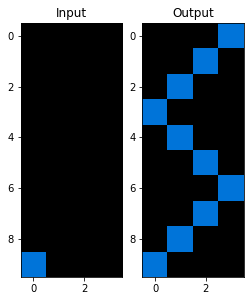

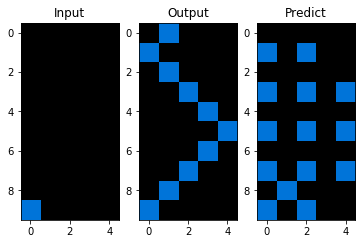

248it [05:52,  1.57s/it]

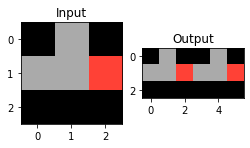

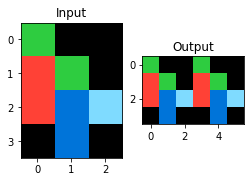

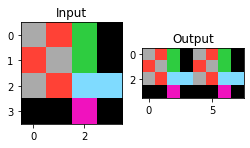

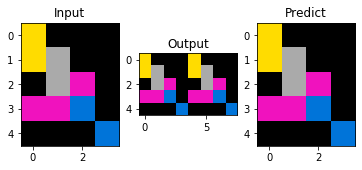

249it [05:53,  1.49s/it]

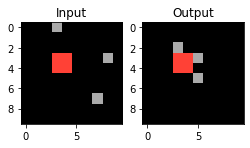

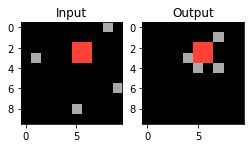

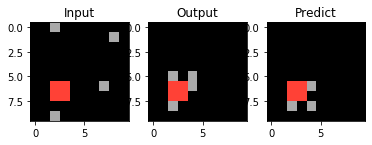

250it [05:54,  1.36s/it]

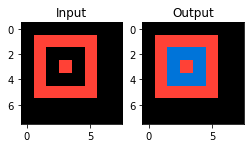

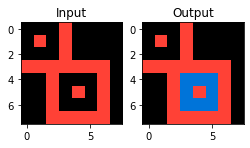

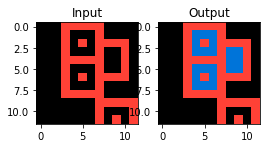

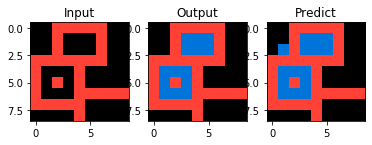

251it [05:55,  1.34s/it]

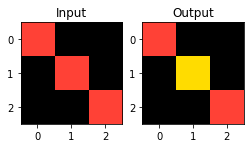

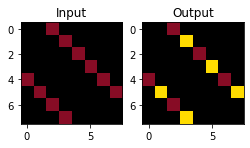

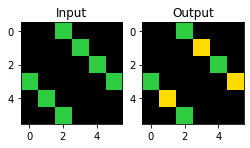

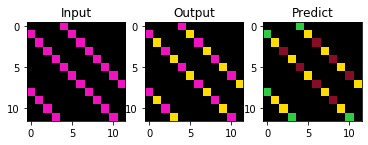

252it [05:57,  1.32s/it]

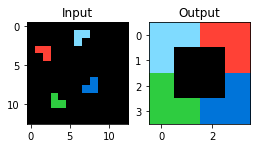

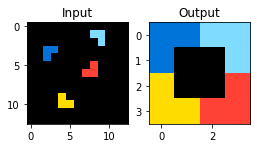

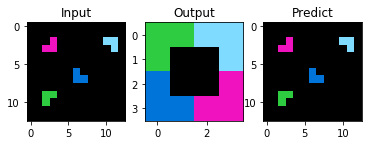

253it [05:58,  1.25s/it]

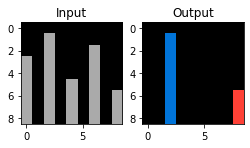

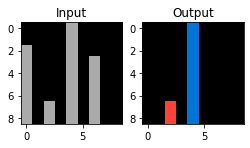

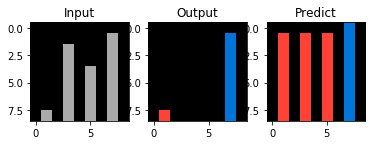

254it [05:59,  1.18s/it]

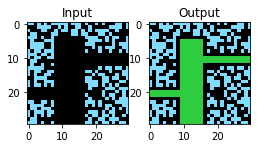

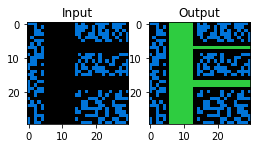

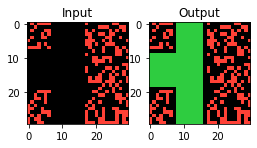

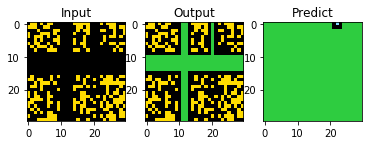

255it [06:00,  1.21s/it]

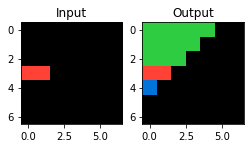

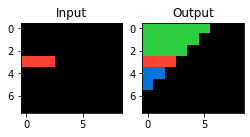

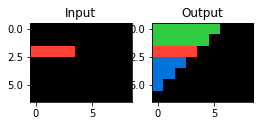

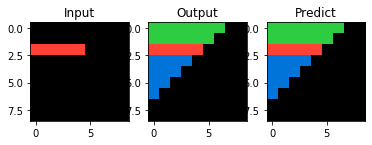

256it [06:01,  1.26s/it]

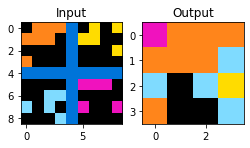

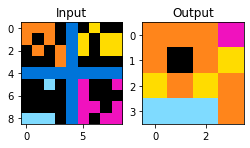

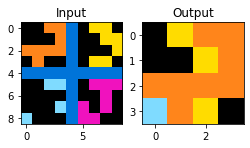

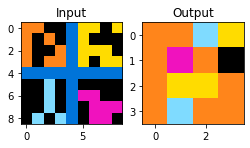

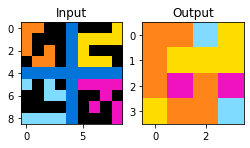

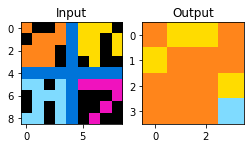

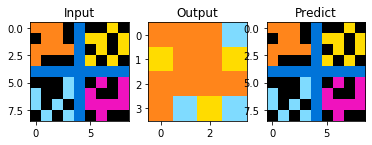

257it [06:04,  1.53s/it]

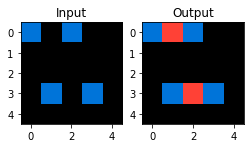

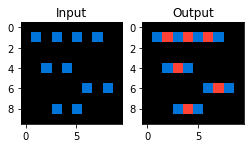

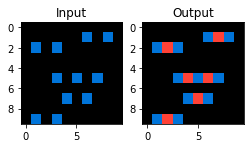

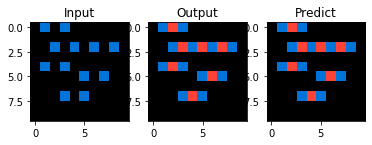

258it [06:05,  1.49s/it]

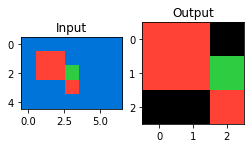

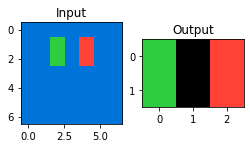

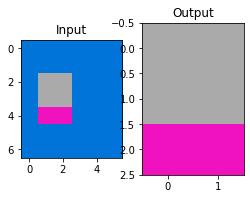

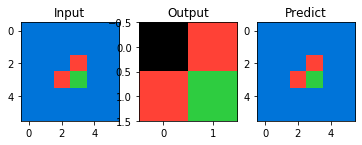

259it [06:06,  1.43s/it]

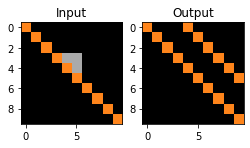

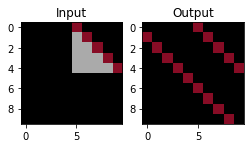

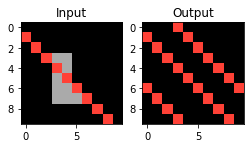

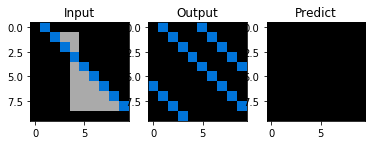

260it [06:08,  1.41s/it]

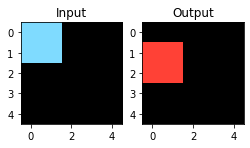

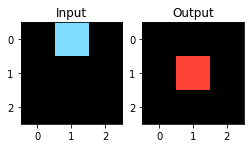

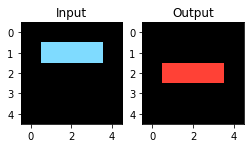

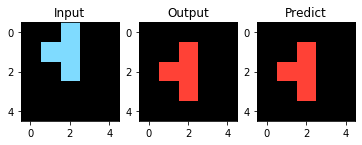

261it [06:09,  1.37s/it]

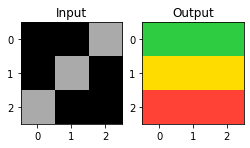

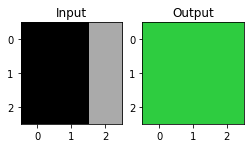

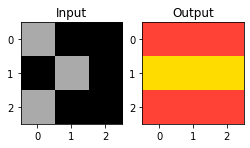

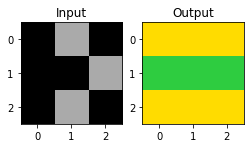

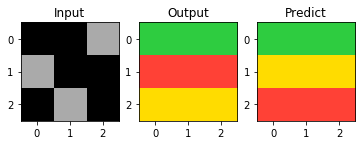

262it [06:11,  1.43s/it]

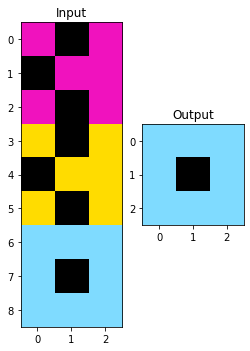

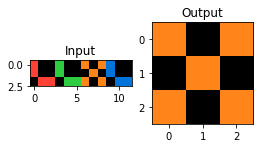

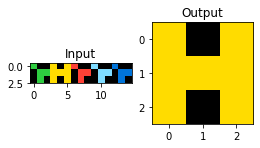

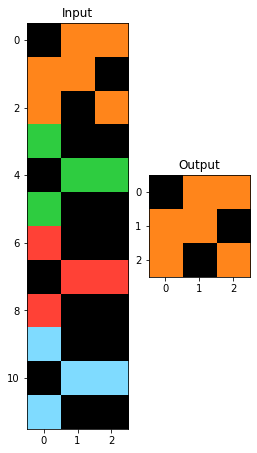

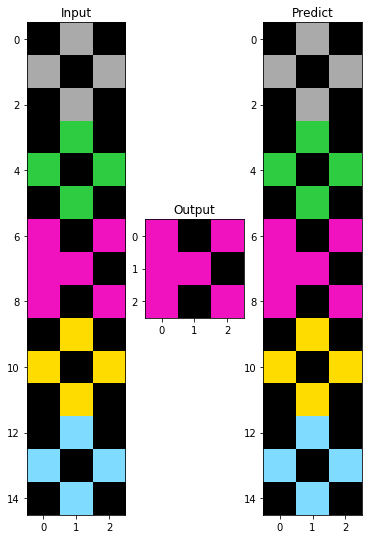

263it [06:12,  1.52s/it]

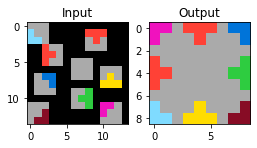

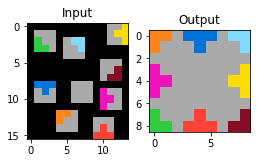

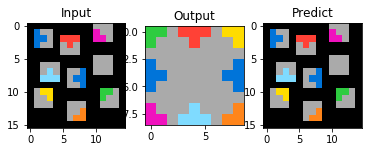

264it [06:13,  1.37s/it]

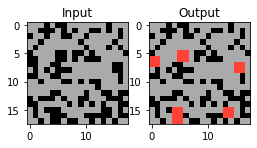

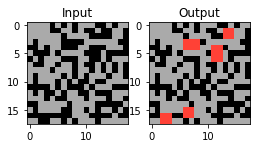

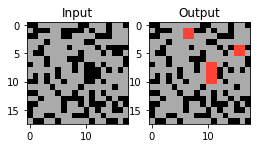

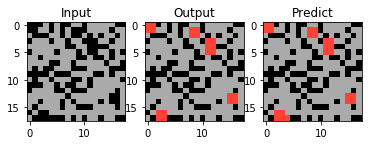

265it [06:15,  1.37s/it]

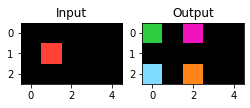

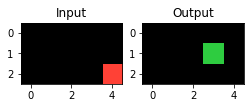

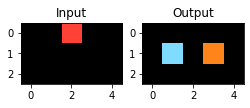

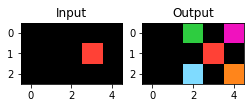

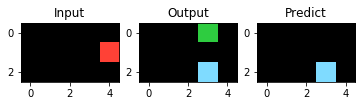

266it [06:16,  1.42s/it]

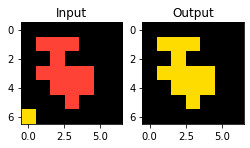

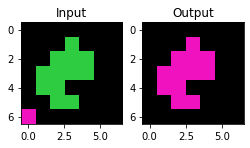

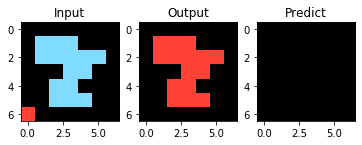

267it [06:17,  1.30s/it]

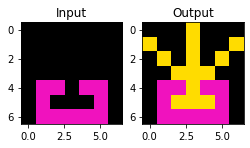

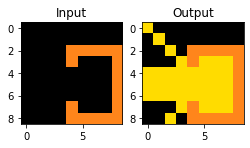

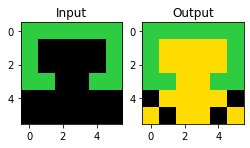

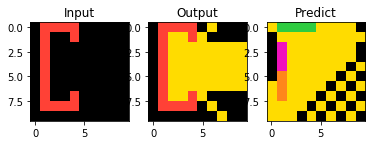

268it [06:19,  1.32s/it]

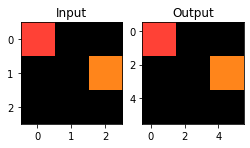

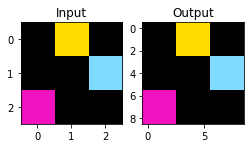

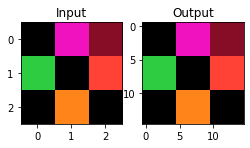

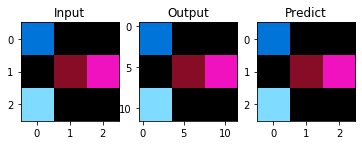

269it [06:20,  1.31s/it]

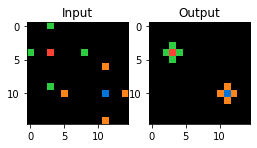

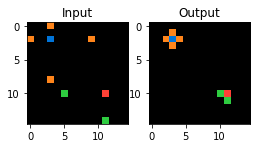

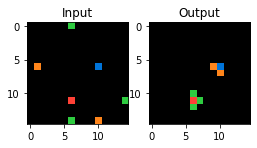

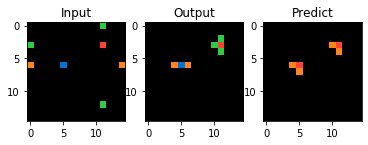

270it [06:21,  1.31s/it]

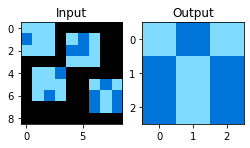

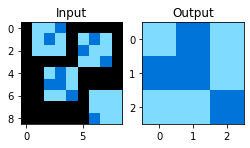

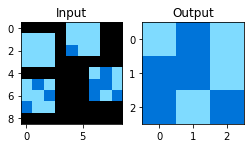

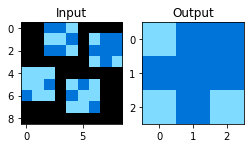

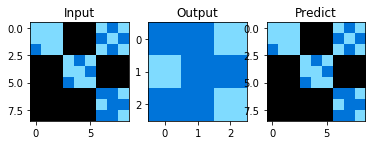

271it [06:23,  1.41s/it]

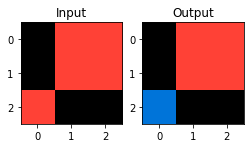

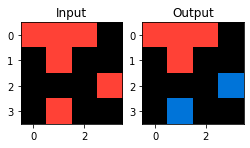

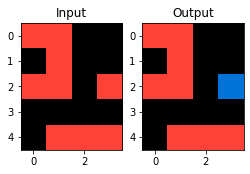

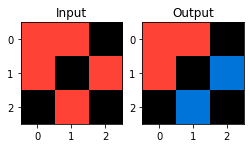

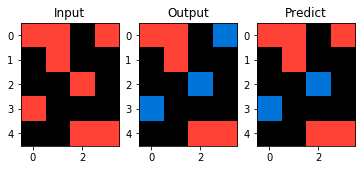

272it [06:24,  1.46s/it]

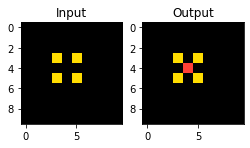

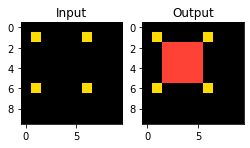

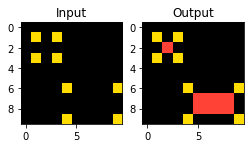

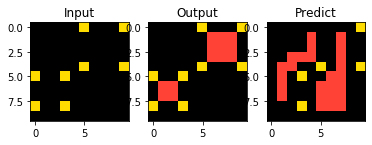

273it [06:26,  1.43s/it]

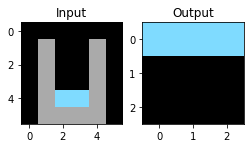

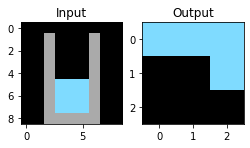

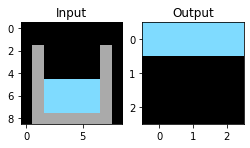

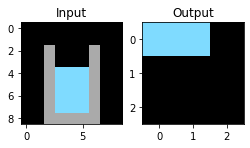

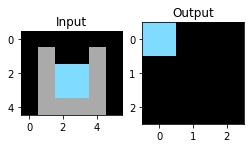

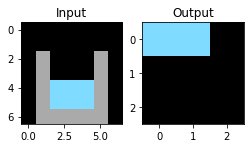

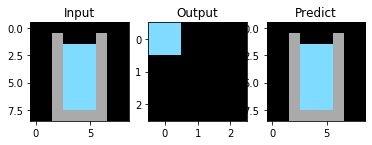

274it [06:28,  1.65s/it]

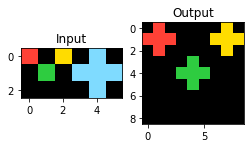

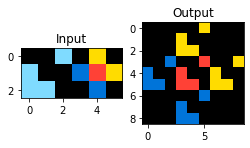

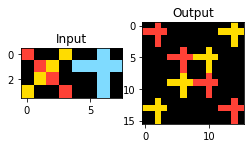

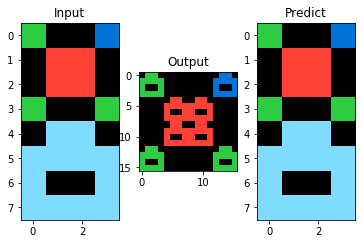

275it [06:29,  1.57s/it]

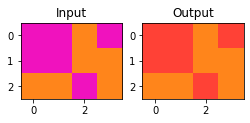

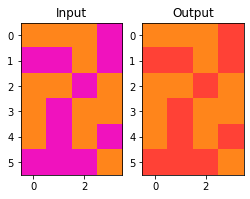

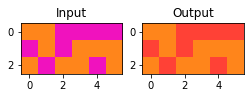

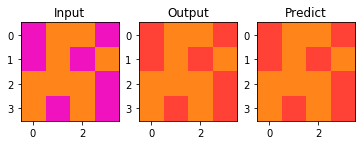

276it [06:31,  1.48s/it]

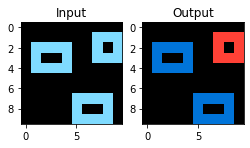

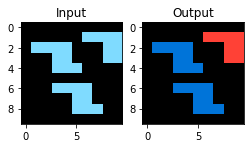

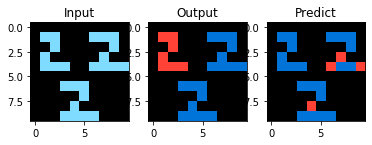

277it [06:32,  1.34s/it]

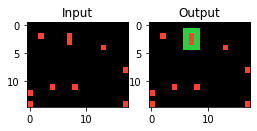

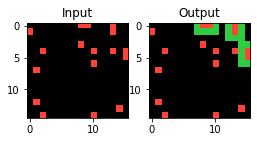

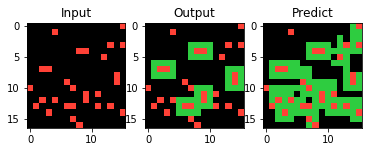

278it [06:33,  1.26s/it]

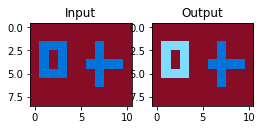

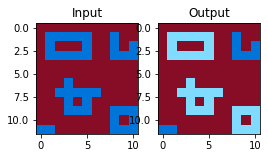

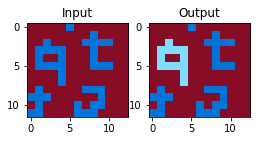

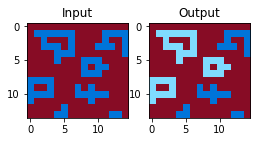

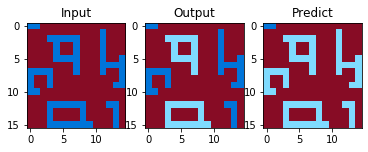

279it [06:34,  1.36s/it]

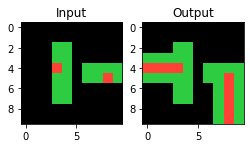

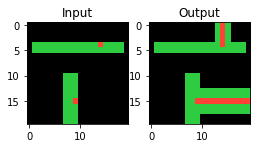

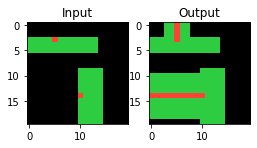

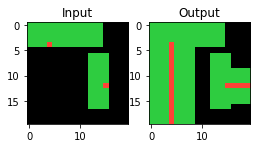

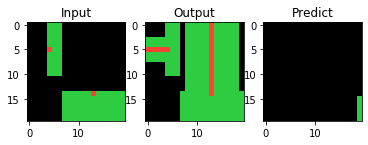

280it [06:36,  1.45s/it]

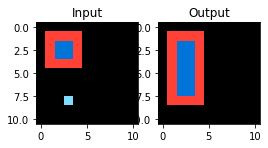

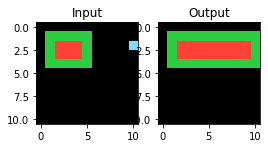

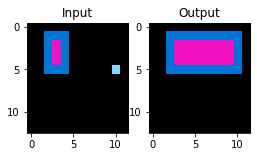

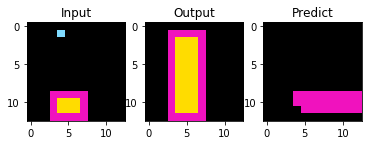

281it [06:37,  1.40s/it]

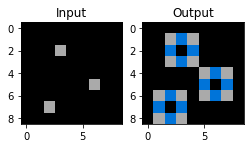

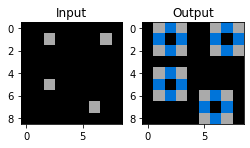

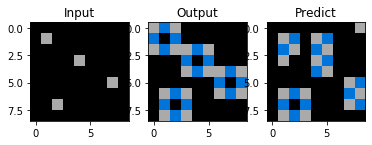

282it [06:38,  1.29s/it]

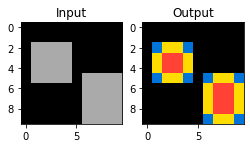

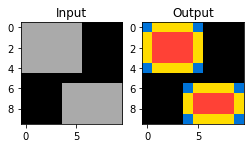

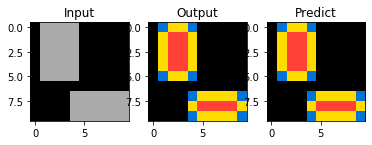

283it [06:39,  1.22s/it]

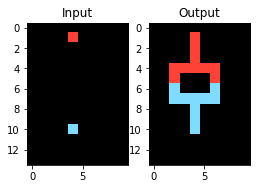

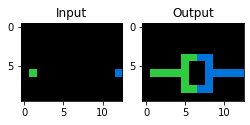

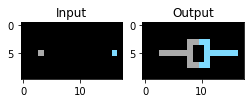

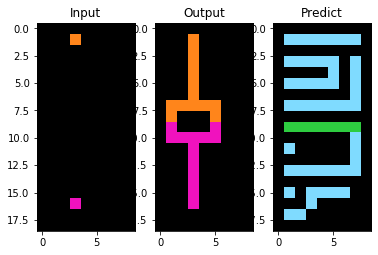

284it [06:41,  1.25s/it]

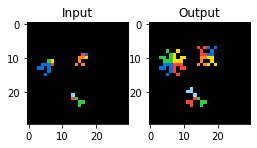

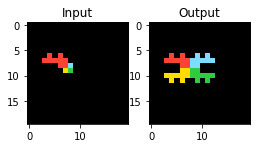

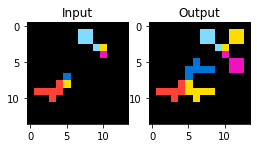

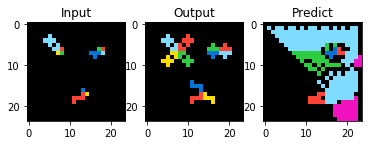

285it [06:42,  1.26s/it]

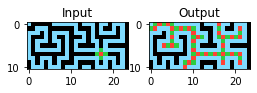

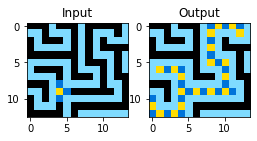

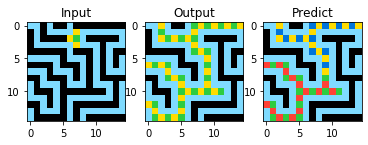

286it [06:43,  1.20s/it]

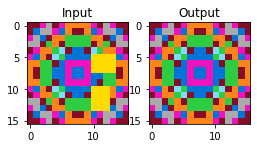

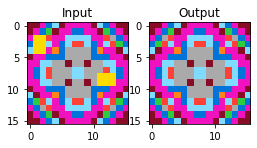

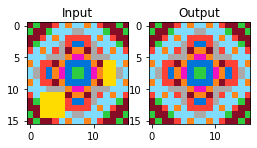

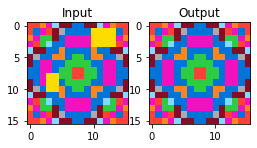

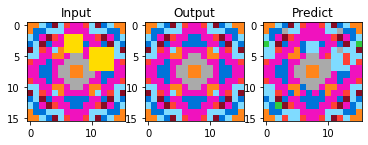

287it [06:45,  1.31s/it]

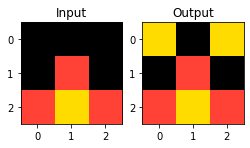

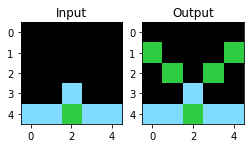

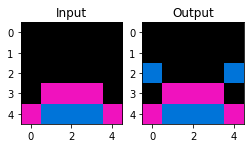

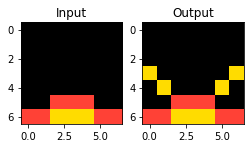

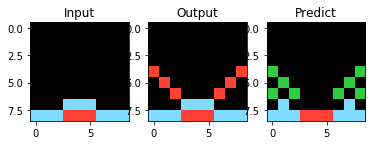

288it [06:46,  1.42s/it]

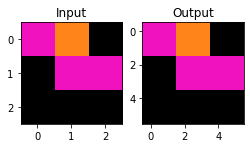

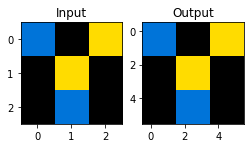

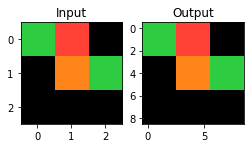

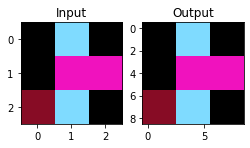

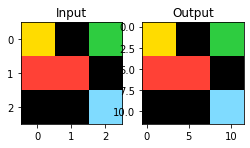

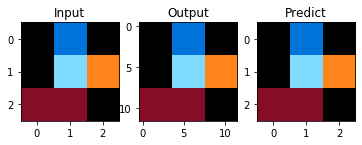

289it [06:48,  1.56s/it]

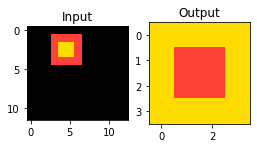

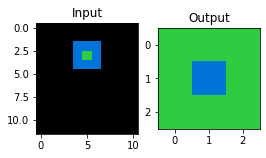

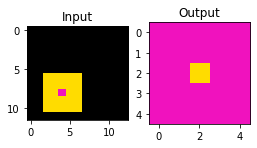

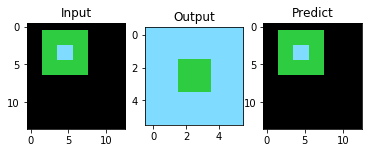

290it [06:49,  1.51s/it]

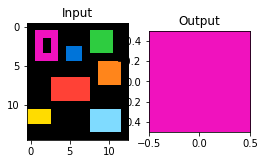

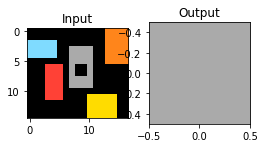

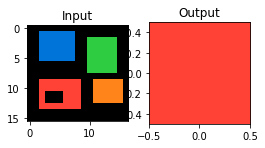

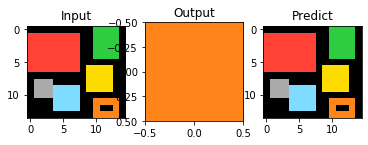

291it [06:51,  1.45s/it]

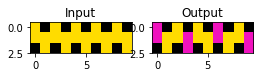

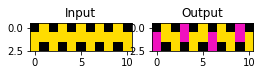

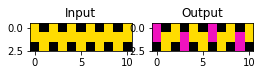

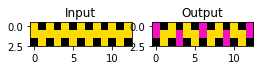

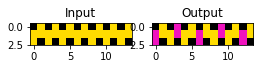

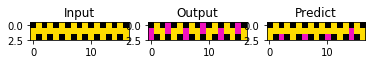

292it [06:53,  1.55s/it]

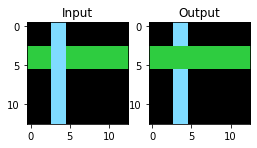

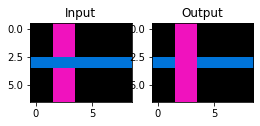

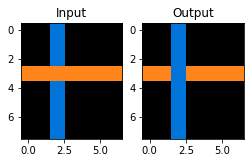

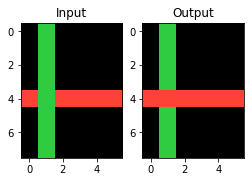

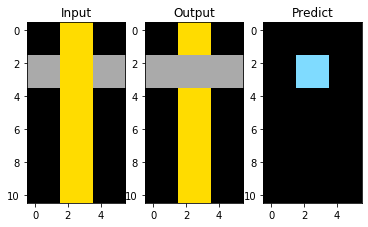

293it [06:54,  1.59s/it]

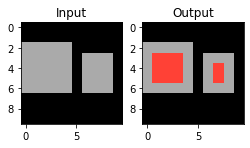

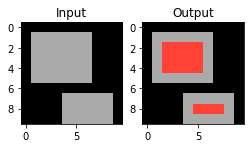

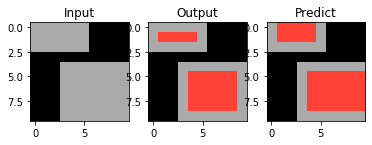

294it [06:55,  1.41s/it]

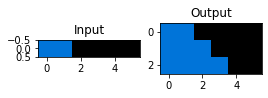

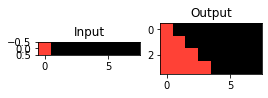

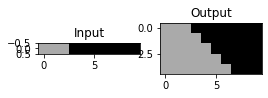

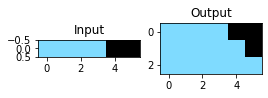

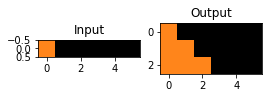

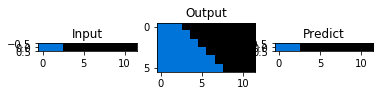

295it [06:57,  1.56s/it]

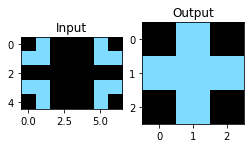

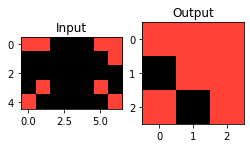

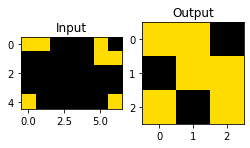

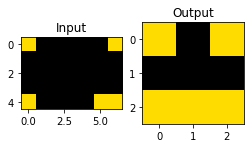

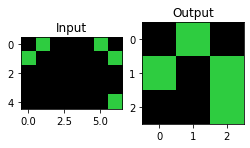

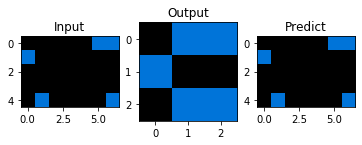

296it [06:59,  1.65s/it]

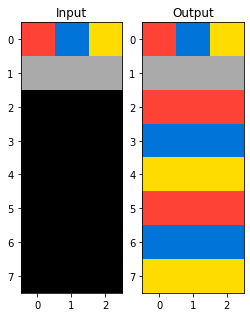

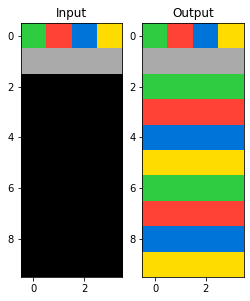

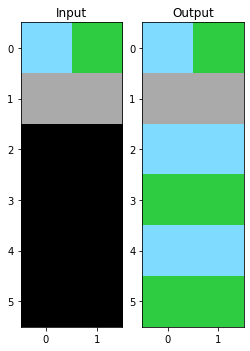

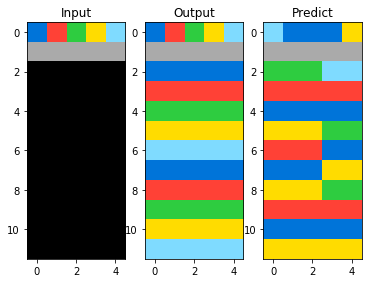

297it [07:00,  1.59s/it]

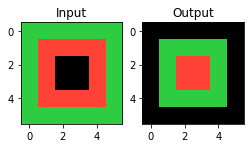

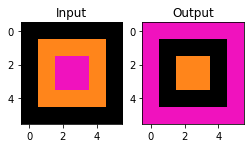

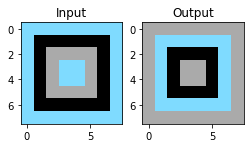

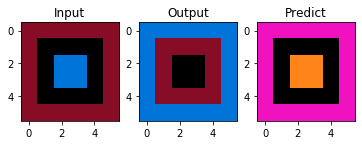

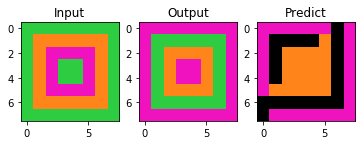

298it [07:02,  1.62s/it]

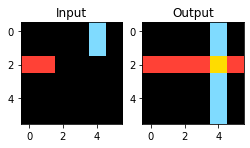

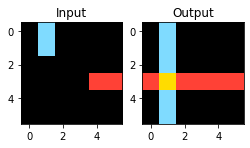

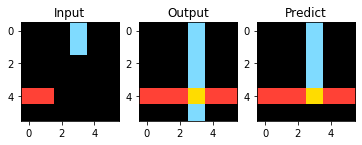

299it [07:03,  1.43s/it]

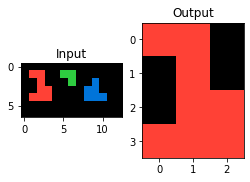

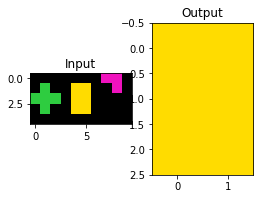

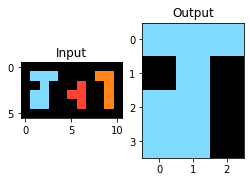

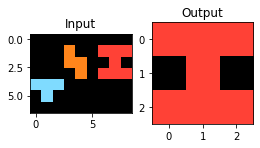

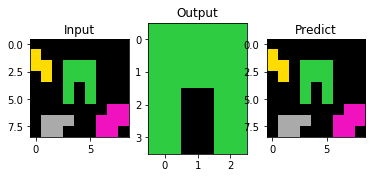

300it [07:05,  1.50s/it]

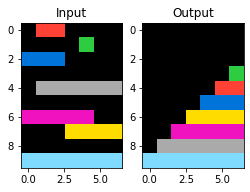

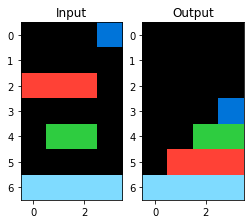

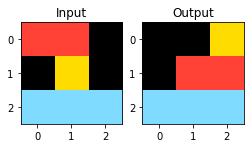

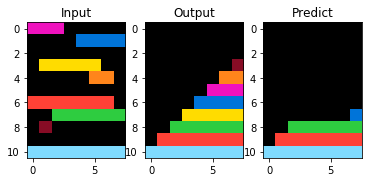

301it [07:06,  1.45s/it]

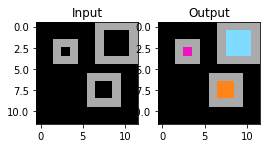

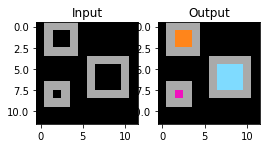

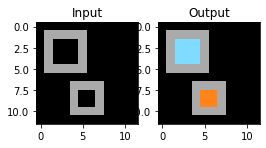

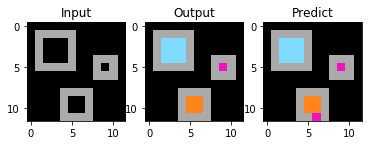

302it [07:08,  1.43s/it]

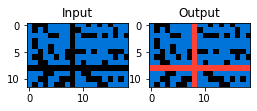

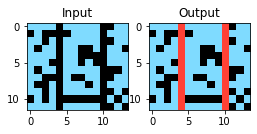

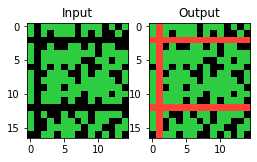

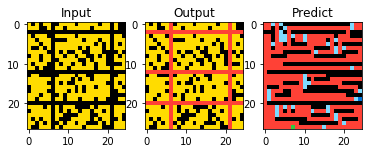

303it [07:09,  1.39s/it]

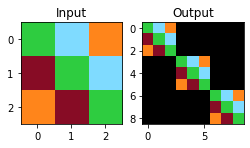

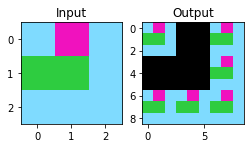

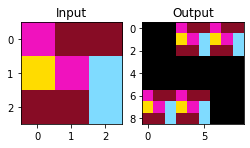

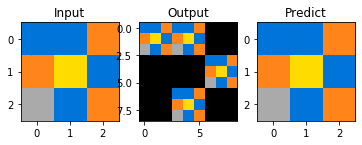

304it [07:10,  1.36s/it]

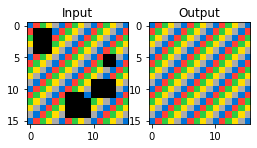

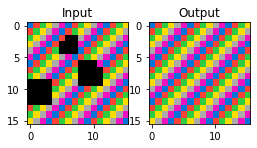

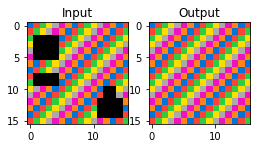

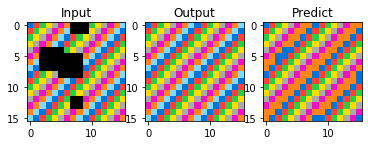

305it [07:11,  1.37s/it]

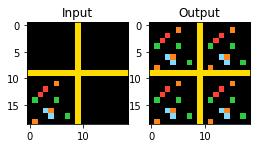

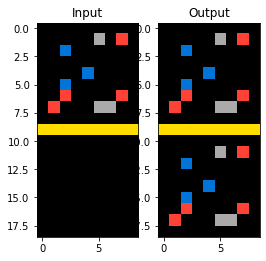

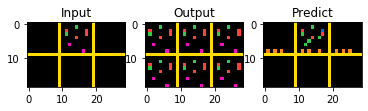

306it [07:12,  1.26s/it]

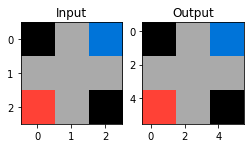

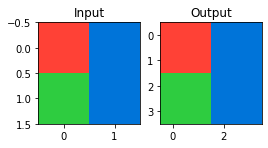

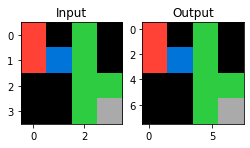

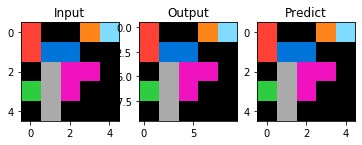

307it [07:14,  1.29s/it]

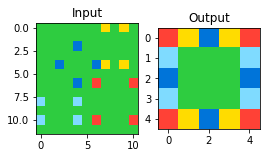

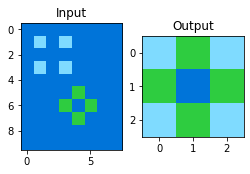

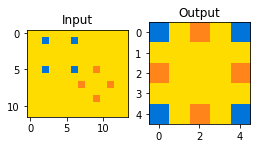

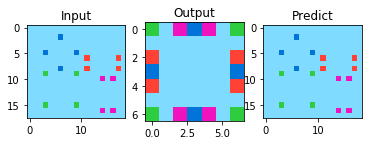

308it [07:15,  1.30s/it]

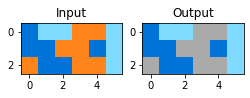

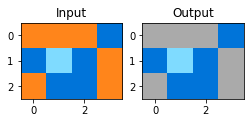

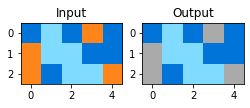

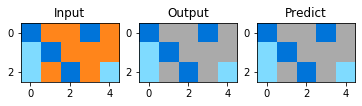

309it [07:16,  1.28s/it]

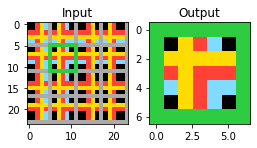

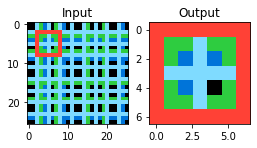

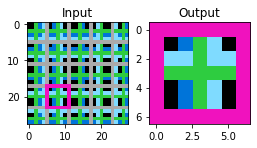

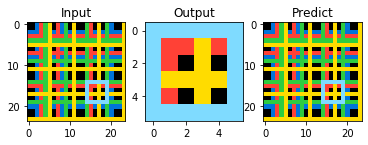

310it [07:18,  1.32s/it]

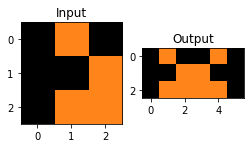

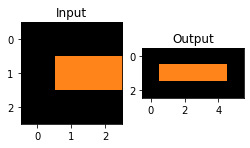

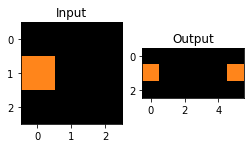

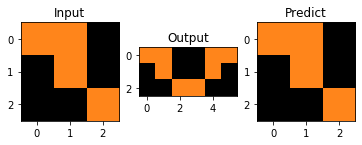

311it [07:19,  1.30s/it]

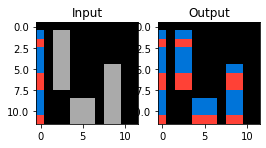

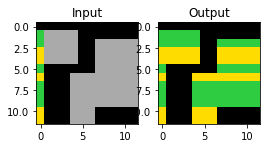

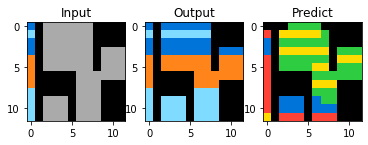

312it [07:20,  1.22s/it]

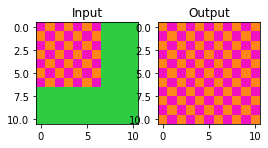

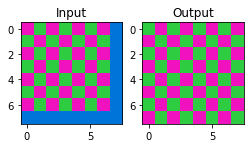

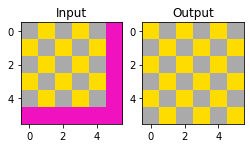

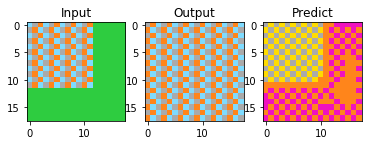

313it [07:21,  1.26s/it]

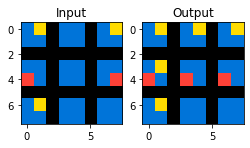

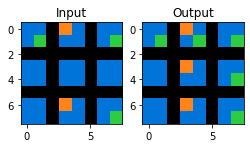

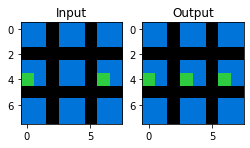

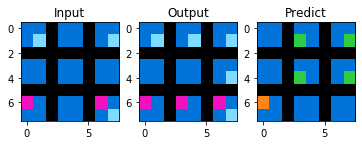

314it [07:23,  1.27s/it]

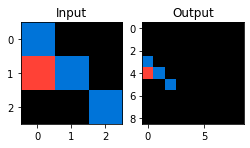

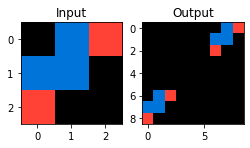

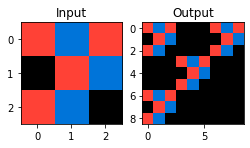

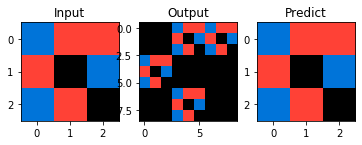

315it [07:24,  1.30s/it]

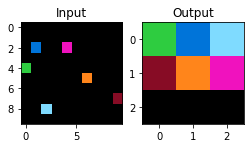

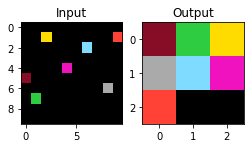

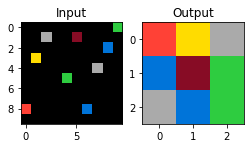

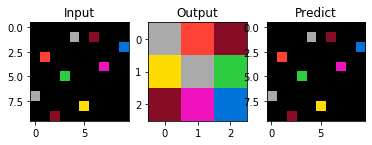

316it [07:25,  1.30s/it]

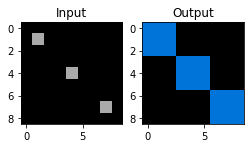

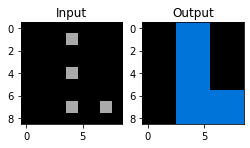

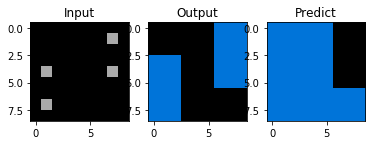

317it [07:26,  1.21s/it]

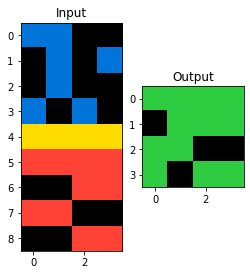

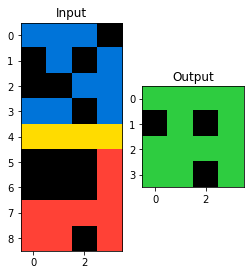

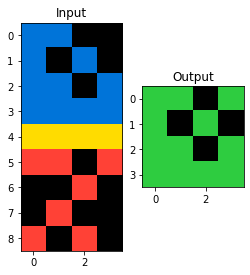

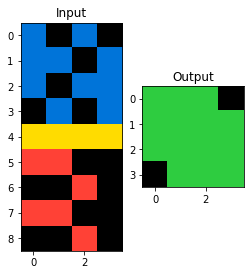

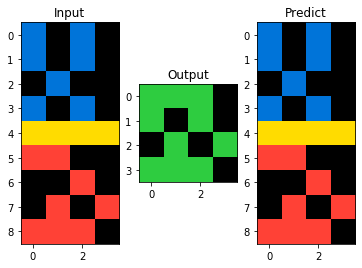

318it [07:28,  1.37s/it]

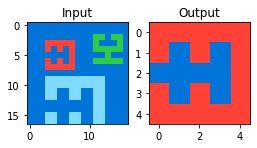

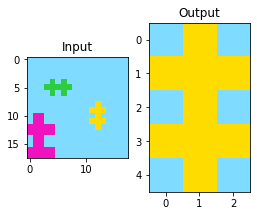

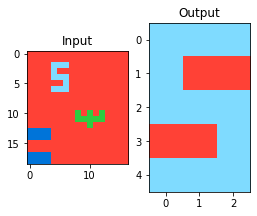

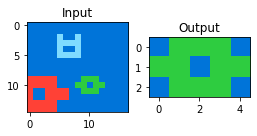

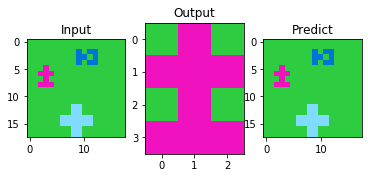

319it [07:30,  1.44s/it]

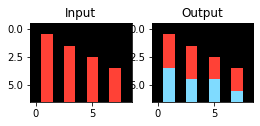

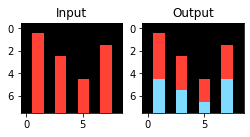

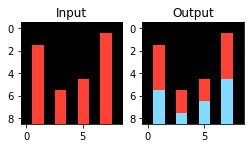

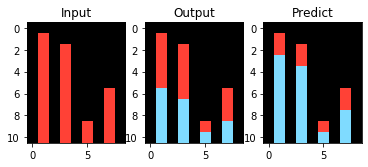

320it [07:31,  1.42s/it]

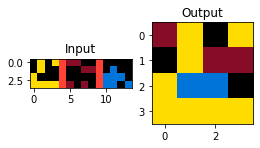

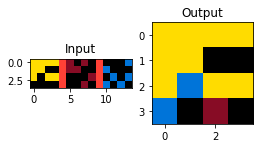

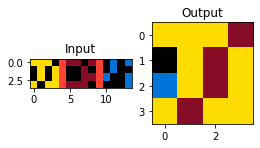

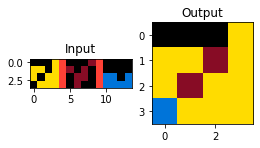

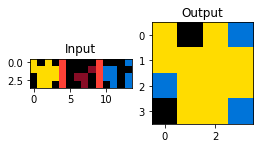

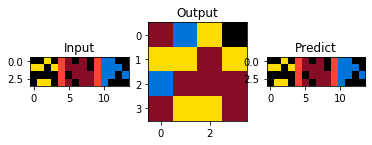

321it [07:33,  1.56s/it]

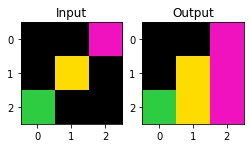

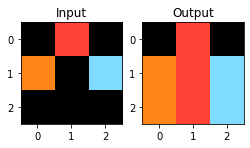

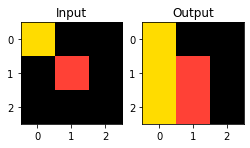

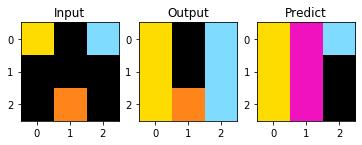

322it [07:34,  1.47s/it]

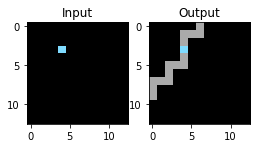

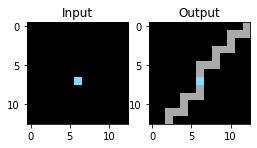

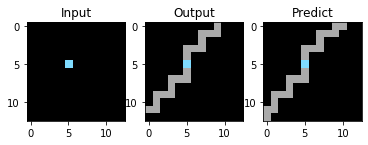

323it [07:35,  1.36s/it]

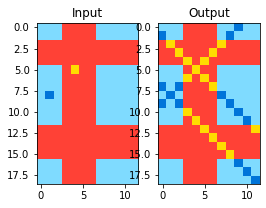

In [ ]:
for task, prediction, solved in tqdm(zip(train_tasks.values(), train_predictions, train_solved)):
    #if solved:
    for i in range(len(task['train'])):
        plot_sample(task['train'][i])
            
    for i in range(len(task['test'])):
        plot_sample(task['test'][i], prediction[i])

That's all for now, thanks for reading!